# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. **Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment.** For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

In [1]:
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, test_data,
        num_epochs, stats_interval, notebook=True):
    """
    Modified version of the properitory function. 
    1) Inclusion of `test_data` so that we can get some test statistics for the performance of 
    the model
    2) See changes in the respective `mlp` package functions too.
    """
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    # Include the test_data so that optimiser will run the test_data and collect some data!
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, test_data,
        data_monitors, notebook=notebook)

    # Run the optimiser for the given num_epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, 
                                            stats_interval=stats_interval)
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

In [2]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)
batch_size = 50 # DO NOT CHANGE
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = MNISTDataProvider('test', batch_size=batch_size, rng=rng)

In [108]:
print("\t\t\tnum_batches * batch_size = size of inputs")
print("train_data\t\t", train_data.num_batches, " * ", train_data.batch_size, " = ", len(train_data.inputs))
print("valid_data\t\t", valid_data.num_batches, " * ", valid_data.batch_size, " = ", len(valid_data.inputs))
print("test_data\t\t", test_data.num_batches, " * ", test_data.batch_size, " = ", len(test_data.inputs))

			num_batches * batch_size = size of inputs
train_data		 1000  *  50  =  50000
valid_data		 200  *  50  =  10000
test_data		 200  *  50  =  10000


In [3]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit, SELUInit
from mlp.learning_rules import GradientDescentLearningRule, MomentumLearningRule
from mlp.optimisers import Optimiser

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100 # DO NOT CHANGE
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 10, 100 # DO NOT CHANGE

---
# Part 1: Implementing Activation Functions
## Baseline Models

Training the MNIST data by minimising the multi-class cross entropy error function using a basic gradient descent learning rule. The model will use the recommended `GlorotUniformInit` for weights initialisation

In [4]:
# For reusability, define a function that train a model that uses a given activation function.

def train_model_4_func(func):
    """
    Given an activation function func(), use it as the activation function for
    the multilayer NN with 2 hidden layer with 100 unit each.
    """
    
    # Always reset the dataset before experiment:
    train_data.reset()
    valid_data.reset()
    test_data.reset()

    # Initialise the weights and biases
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    m = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        func,
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        func,
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])
    
    # Log the information about the layers
    print(m)
    
    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    output = train_model_and_plot_stats(
        m, error, learning_rule, train_data, valid_data, test_data,
        num_epochs, stats_interval, notebook=True)

    return output

In [5]:
%%capture baseline_models
# The baseline models for our experiment
baseline_models = {'RELU': ReluLayer(),
                   'Sigmoid':SigmoidLayer()
                  }

# Store the output from running the models
results_baseline_models = {}

for (name, func) in baseline_models.items():
        results_baseline_models[name] = train_model_4_func(func)

Epoch 1: 1.2s to complete
    error(train)=1.80e-01, acc(train)=9.47e-01, error(valid)=1.78e-01, acc(valid)=9.49e-01, error(test)=1.75e-01, acc(test)=9.47e-01, params_penalty=0.00e+00
Epoch 2: 1.2s to complete
    error(train)=1.23e-01, acc(train)=9.64e-01, error(valid)=1.34e-01, acc(valid)=9.60e-01, error(test)=1.35e-01, acc(test)=9.59e-01, params_penalty=0.00e+00
Epoch 3: 1.2s to complete
    error(train)=1.01e-01, acc(train)=9.70e-01, error(valid)=1.25e-01, acc(valid)=9.64e-01, error(test)=1.25e-01, acc(test)=9.62e-01, params_penalty=0.00e+00
Epoch 4: 1.2s to complete
    error(train)=7.13e-02, acc(train)=9.79e-01, error(valid)=1.05e-01, acc(valid)=9.70e-01, error(test)=1.05e-01, acc(test)=9.67e-01, params_penalty=0.00e+00
Epoch 5: 1.2s to complete
    error(train)=6.05e-02, acc(train)=9.82e-01, error(valid)=9.63e-02, acc(valid)=9.70e-01, error(test)=9.95e-02, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 6: 1.2s to complete
    error(train)=5.77e-02, acc(train)=9.82e-01, error(

Epoch 46: 1.2s to complete
    error(train)=4.21e-04, acc(train)=1.00e+00, error(valid)=9.84e-02, acc(valid)=9.82e-01, error(test)=9.26e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 47: 1.2s to complete
    error(train)=4.08e-04, acc(train)=1.00e+00, error(valid)=9.82e-02, acc(valid)=9.82e-01, error(test)=9.25e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 48: 1.2s to complete
    error(train)=3.94e-04, acc(train)=1.00e+00, error(valid)=9.81e-02, acc(valid)=9.82e-01, error(test)=9.27e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 49: 1.2s to complete
    error(train)=3.86e-04, acc(train)=1.00e+00, error(valid)=9.87e-02, acc(valid)=9.82e-01, error(test)=9.31e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 50: 1.2s to complete
    error(train)=3.77e-04, acc(train)=1.00e+00, error(valid)=9.89e-02, acc(valid)=9.82e-01, error(test)=9.33e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 51: 1.2s to complete
    error(train)=3.64e-04, acc(train)=1.00e+00, 

Epoch 91: 1.2s to complete
    error(train)=1.62e-04, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.82e-01, error(test)=1.02e-01, acc(test)=9.81e-01, params_penalty=0.00e+00
Epoch 92: 1.2s to complete
    error(train)=1.59e-04, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.82e-01, error(test)=1.02e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 93: 1.2s to complete
    error(train)=1.57e-04, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.82e-01, error(test)=1.02e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 94: 1.2s to complete
    error(train)=1.55e-04, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.82e-01, error(test)=1.03e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 95: 1.2s to complete
    error(train)=1.52e-04, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.82e-01, error(test)=1.03e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 96: 1.2s to complete
    error(train)=1.52e-04, acc(train)=1.00e+00, 

Epoch 36: 1.3s to complete
    error(train)=4.76e-02, acc(train)=9.88e-01, error(valid)=8.79e-02, acc(valid)=9.74e-01, error(test)=8.53e-02, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 37: 1.3s to complete
    error(train)=4.70e-02, acc(train)=9.88e-01, error(valid)=8.75e-02, acc(valid)=9.75e-01, error(test)=8.48e-02, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 38: 1.3s to complete
    error(train)=4.45e-02, acc(train)=9.89e-01, error(valid)=8.58e-02, acc(valid)=9.76e-01, error(test)=8.39e-02, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 39: 1.3s to complete
    error(train)=4.29e-02, acc(train)=9.89e-01, error(valid)=8.81e-02, acc(valid)=9.75e-01, error(test)=8.42e-02, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 40: 1.3s to complete
    error(train)=4.15e-02, acc(train)=9.90e-01, error(valid)=8.70e-02, acc(valid)=9.76e-01, error(test)=8.21e-02, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 41: 1.3s to complete
    error(train)=3.95e-02, acc(train)=9.90e-01, 

Epoch 81: 1.3s to complete
    error(train)=9.66e-03, acc(train)=9.99e-01, error(valid)=8.28e-02, acc(valid)=9.77e-01, error(test)=7.85e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 82: 1.3s to complete
    error(train)=8.84e-03, acc(train)=9.99e-01, error(valid)=8.27e-02, acc(valid)=9.77e-01, error(test)=7.83e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 83: 1.3s to complete
    error(train)=9.16e-03, acc(train)=9.99e-01, error(valid)=8.51e-02, acc(valid)=9.77e-01, error(test)=8.06e-02, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 84: 1.3s to complete
    error(train)=8.57e-03, acc(train)=9.99e-01, error(valid)=8.36e-02, acc(valid)=9.77e-01, error(test)=7.83e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 85: 1.3s to complete
    error(train)=8.42e-03, acc(train)=9.99e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, error(test)=7.88e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 86: 1.3s to complete
    error(train)=8.10e-03, acc(train)=1.00e+00, 

In [36]:
# Now, want to find the score for the test result for the 'best' learned representation of these models:
# using the function to search for an epoch that satisfy the following conditions
# 1) Validation error is near the local minima, while
# 2) Validation accuracy is highest
def find_best_epoch(stats, keys):
    """
    stats: results of each epochs,
    keys: index of properties of our interest. 
    We find the best epoch iff the validation accuracy is at least 9.81
    """
    final_val_err = stats[-1, keys['error(valid)']]
    final_val_acc = stats[-1, keys['acc(valid)']]
    val_err = stats[:, keys['error(valid)']]
    val_acc = stats[:, keys['acc(valid)']]

    # 1) find if a minimum point exists in the validation error:
    # scale the errors so that the minimum points will be below less than 0
    # Then multiply the scaled error with accuracy, so that the products 
    # tells us when the accuracy is high (close to 1) while the error is relatively low 
    val_err_scaled = val_err - final_val_err
    val_acc_scaled = val_acc - final_val_acc
    mul = np.multiply(val_acc,val_err_scaled)

    # Points that are reaching the best val results, 
    # but not overfitting
    idx = np.where(val_acc_scaled[25:]>=val_acc_scaled[-1]-.0025)

    # Now, find the lowest multiplied value amongst these values:
    best_epoch = np.argmin(mul[25:][idx])+25    
    # print(best_epoch)

    val_acc_scaled = val_acc - final_val_acc
    fig_1 = plt.figure(figsize=(8,4));
    ax1 = fig_1.add_subplot(111)

    ax1.plot(val_err_scaled,label="error(val)");
    ax1.plot(val_acc_scaled, label="acc(val)");
    ax1.plot(mul, label="acc(val)*error(val)");
    ax1.plot(np.repeat(best_epoch,10), 
             np.linspace(start=mul[best_epoch]-.2, stop=mul[best_epoch]+.2, num=10),
             label="early-stop")
    ax1.set_ylim([mul[best_epoch]-.2, mul[best_epoch]+.2])
    
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
        
    return best_epoch, stats[best_epoch, keys['acc(valid)']], stats[best_epoch, keys['acc(test)']], fig_1, ax1

---
# Part 2A: Comparing Activation Function 
Create and calculate the statistics for activation functions: 1) LeakyReLU 2) ELU 3) SELU. All other hyperparameters are held constant, and default values for each functions are used.

In [7]:
%%capture _results_act_funcs
# Defining all the activation functions that we are inetersted in:
act_funcs = {'LRELU':LeakyReluLayer(), 
             'ELU': ELULayer(),
             'SELU':SELULayer()
            }

# Store the results of the activation function
results_act_funcs = {}

# Run the experiments:
for (name,func) in act_funcs.items():
    results_act_funcs[name] = train_model_4_func(func)

Epoch 1: 1.3s to complete
    error(train)=2.01e-01, acc(train)=9.40e-01, error(valid)=1.95e-01, acc(valid)=9.43e-01, error(test)=2.04e-01, acc(test)=9.39e-01, params_penalty=0.00e+00
Epoch 2: 1.3s to complete
    error(train)=1.19e-01, acc(train)=9.64e-01, error(valid)=1.27e-01, acc(valid)=9.63e-01, error(test)=1.26e-01, acc(test)=9.61e-01, params_penalty=0.00e+00
Epoch 3: 1.3s to complete
    error(train)=9.01e-02, acc(train)=9.74e-01, error(valid)=1.05e-01, acc(valid)=9.67e-01, error(test)=1.05e-01, acc(test)=9.67e-01, params_penalty=0.00e+00
Epoch 4: 1.3s to complete
    error(train)=7.44e-02, acc(train)=9.78e-01, error(valid)=9.97e-02, acc(valid)=9.70e-01, error(test)=1.03e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 5: 1.3s to complete
    error(train)=5.90e-02, acc(train)=9.83e-01, error(valid)=9.30e-02, acc(valid)=9.71e-01, error(test)=9.32e-02, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 6: 1.3s to complete
    error(train)=4.63e-02, acc(train)=9.86e-01, error(

Epoch 46: 1.3s to complete
    error(train)=4.32e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, error(test)=9.37e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 47: 1.3s to complete
    error(train)=4.21e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, error(test)=9.36e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 48: 1.3s to complete
    error(train)=4.02e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, error(test)=9.41e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 49: 1.3s to complete
    error(train)=3.89e-04, acc(train)=1.00e+00, error(valid)=1.05e-01, acc(valid)=9.79e-01, error(test)=9.44e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 50: 1.3s to complete
    error(train)=3.81e-04, acc(train)=1.00e+00, error(valid)=1.05e-01, acc(valid)=9.79e-01, error(test)=9.46e-02, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 51: 1.3s to complete
    error(train)=3.72e-04, acc(train)=1.00e+00, 

Epoch 91: 1.3s to complete
    error(train)=1.65e-04, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.79e-01, error(test)=1.04e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 92: 1.3s to complete
    error(train)=1.62e-04, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.79e-01, error(test)=1.04e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 93: 1.3s to complete
    error(train)=1.60e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.79e-01, error(test)=1.04e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 94: 1.3s to complete
    error(train)=1.57e-04, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.79e-01, error(test)=1.04e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 95: 1.3s to complete
    error(train)=1.55e-04, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.79e-01, error(test)=1.05e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 96: 1.3s to complete
    error(train)=1.53e-04, acc(train)=1.00e+00, 

Epoch 36: 1.4s to complete
    error(train)=1.17e-03, acc(train)=1.00e+00, error(valid)=9.59e-02, acc(valid)=9.79e-01, error(test)=9.51e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 37: 1.4s to complete
    error(train)=1.19e-03, acc(train)=1.00e+00, error(valid)=9.76e-02, acc(valid)=9.80e-01, error(test)=9.68e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 38: 1.4s to complete
    error(train)=1.05e-03, acc(train)=1.00e+00, error(valid)=9.78e-02, acc(valid)=9.79e-01, error(test)=9.70e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 39: 1.4s to complete
    error(train)=1.02e-03, acc(train)=1.00e+00, error(valid)=9.95e-02, acc(valid)=9.79e-01, error(test)=9.92e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 40: 1.4s to complete
    error(train)=9.35e-04, acc(train)=1.00e+00, error(valid)=9.97e-02, acc(valid)=9.79e-01, error(test)=9.82e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 41: 1.4s to complete
    error(train)=8.93e-04, acc(train)=1.00e+00, 

Epoch 81: 1.4s to complete
    error(train)=2.73e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.80e-01, error(test)=1.14e-01, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 82: 1.4s to complete
    error(train)=2.68e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.80e-01, error(test)=1.14e-01, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 83: 1.4s to complete
    error(train)=2.65e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.80e-01, error(test)=1.14e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 84: 1.4s to complete
    error(train)=2.62e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.80e-01, error(test)=1.15e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 85: 1.4s to complete
    error(train)=2.54e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.80e-01, error(test)=1.14e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 86: 1.4s to complete
    error(train)=2.51e-04, acc(train)=1.00e+00, 

Epoch 26: 1.4s to complete
    error(train)=2.53e-03, acc(train)=1.00e+00, error(valid)=8.97e-02, acc(valid)=9.78e-01, error(test)=8.57e-02, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 27: 1.4s to complete
    error(train)=2.14e-03, acc(train)=1.00e+00, error(valid)=8.83e-02, acc(valid)=9.79e-01, error(test)=8.39e-02, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 28: 1.4s to complete
    error(train)=2.11e-03, acc(train)=1.00e+00, error(valid)=9.19e-02, acc(valid)=9.78e-01, error(test)=8.85e-02, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 29: 1.4s to complete
    error(train)=1.75e-03, acc(train)=1.00e+00, error(valid)=9.11e-02, acc(valid)=9.79e-01, error(test)=8.80e-02, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.4s to complete
    error(train)=1.83e-03, acc(train)=1.00e+00, error(valid)=9.16e-02, acc(valid)=9.79e-01, error(test)=8.73e-02, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 31: 1.4s to complete
    error(train)=1.43e-03, acc(train)=1.00e+00, 

Epoch 71: 1.4s to complete
    error(train)=3.36e-04, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.79e-01, error(test)=1.05e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 72: 1.4s to complete
    error(train)=3.32e-04, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.79e-01, error(test)=1.05e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 73: 1.4s to complete
    error(train)=3.22e-04, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.79e-01, error(test)=1.06e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 74: 1.4s to complete
    error(train)=3.17e-04, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.80e-01, error(test)=1.06e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 75: 1.4s to complete
    error(train)=3.09e-04, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.79e-01, error(test)=1.06e-01, acc(test)=9.80e-01, params_penalty=0.00e+00
Epoch 76: 1.4s to complete
    error(train)=3.03e-04, acc(train)=1.00e+00, 

26
46
27
25
27


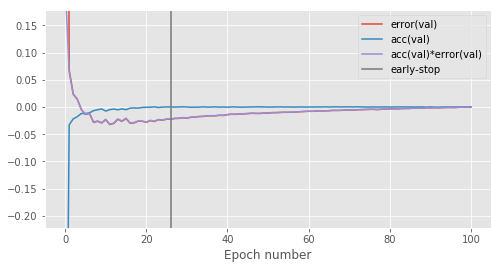

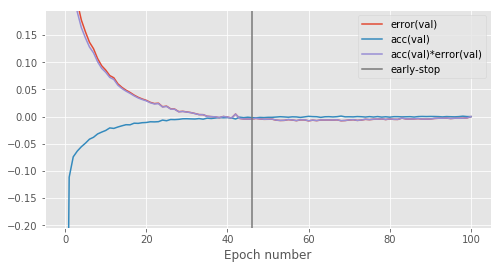

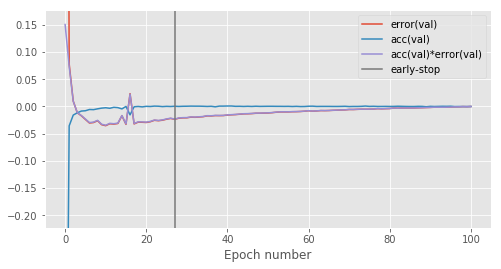

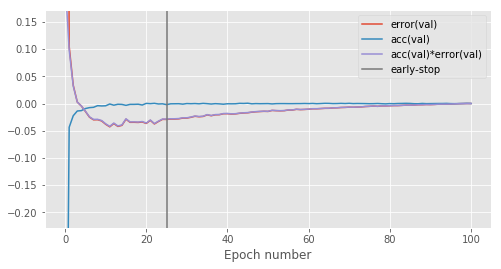

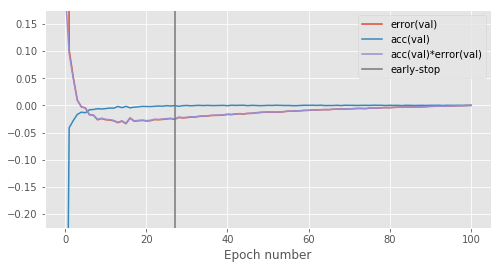

In [8]:
final_valid_err= []
final_valid_acc = []
early_stopping_val_acc = []
early_stopping_val_err = []
test_err = []
test_acc = []
names = []

for results in [results_baseline_models, results_act_funcs]:
    for (name, output) in results.items():
        keys = output[1]
        stats=output[0]
        best_epoch, best_valid_acc, best_test_acc, fig1, ax1 = find_best_epoch(stats, keys)
        
        # Store the statistics for this model
        final_valid_err.append(stats[-1, keys['error(valid)']])
        final_valid_acc.append(stats[-1, keys['acc(valid)']])
        early_stopping_val_err.append(stats[best_epoch, keys['error(valid)']])
        early_stopping_val_acc.append(stats[best_epoch, keys['acc(valid)']])
        test_err.append(stats[best_epoch, keys['error(test)']])
        test_acc.append(stats[best_epoch, keys['acc(test)']])
        names.append(name)
        
        # save the figures
        fig = output[3]
        fig.savefig("{}-err.pdf".format(name), format="pdf")
        fig = output[5]
        fig.savefig("{}-acc.pdf".format(name),format="pdf")
        fig1.savefig("{}-best-epoch.pdf".format(name), format="pdf")
        

In [21]:
print('|             |              FINAL            |                          EARLY STOPPING                     |')
print('| activation  | error(valid)   | acc(valid)   | error(valid)   |  acc(valid)   |  error(test) |  acc(test)  |')
print('|-------------|----------------|--------------|----------------|---------------|--------------|-------------|')
for i in range(len(names)):
    print('|{0:7s}      | {1:.3e}      | {2:.3e}    | {3:.3e}      | {4:.3e}     | {5:.3e}    | {6:.3e}   |'
          .format(names[i], final_valid_err[i], final_valid_acc[i], 
                  early_stopping_val_err[i], early_stopping_val_acc[i],
                  test_err[i], test_acc[i]))
    

|             |              FINAL            |                          EARLY STOPPING                     |
| activation  | error(valid)   | acc(valid)   | error(valid)   |  acc(valid)   |  error(test) |  acc(test)  |
|-------------|----------------|--------------|----------------|---------------|--------------|-------------|
|RELU         | 1.100e-01      | 9.819e-01    | 8.741e-02      | 9.821e-01     | 8.171e-02    | 9.802e-01   |
|Sigmoid      | 8.790e-02      | 9.775e-01    | 8.326e-02      | 9.756e-01     | 7.962e-02    | 9.750e-01   |
|LRELU        | 1.168e-01      | 9.789e-01    | 9.319e-02      | 9.794e-01     | 8.442e-02    | 9.796e-01   |
|ELU          | 1.184e-01      | 9.800e-01    | 8.909e-02      | 9.779e-01     | 8.798e-02    | 9.775e-01   |
|SELU         | 1.141e-01      | 9.795e-01    | 8.831e-02      | 9.790e-01     | 8.386e-02    | 9.791e-01   |


(0.94, 0.99)

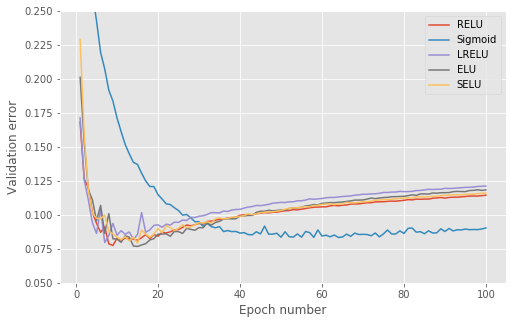

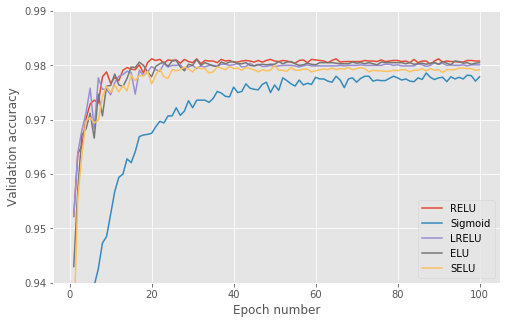

In [182]:
fig_1 = plt.figure(figsize=(8,5))
ax_1 = fig_1.add_subplot(111)
fig_2 = plt.figure(figsize=(8,5))
ax_2 = fig_2.add_subplot(111)

for results in [results_baseline_models, results_act_funcs]:
    for (name, output) in results.items():
        keys=output[1]; stats=output[0]
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
                 stats[1:, keys['error(valid)']], label=name)
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
                   stats[1:, keys['acc(valid)']], label=name)
ax_1.legend(loc=0); ax_2.legend(loc=0)
ax_1.set_xlabel('Epoch number'); ax_2.set_xlabel('Epoch number')
ax_1.set_ylabel('Validation error')
ax_2.set_ylabel('Validation accuracy')
ax_1.set_ylim([.05,.25])
ax_2.set_ylim([.94,.99])

`Comparing the validation accuracy from the networks trained using different activation functions`:

---
# Part 2B: DNN Experiments

In [22]:
func = SELULayer()

### 1)  Compare networks with 2-8 hidden layers

Similar to the previous experiments, we train each of the model with the same hyperparameters, and fixing the activation function to be `ELULayer()`.The only difference, however is the number of hidden layers, from 2-8 hidden layers.

In [66]:
%%capture sgdcompare

experiment_layers = {}
for i in range(1,8):

    # Always reset the dataset before experiment:
    train_data.reset()
    valid_data.reset()
    test_data.reset()

    # Initialise the weights and biases
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [AffineLayer(input_dim, hidden_dim, weights_init, biases_init)]
    output_layer = [func,
                    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)]
    each_hidden_layer = [func,
                    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)]


    # append additional layers
    model = MultipleLayerModel(input_layer + each_hidden_layer * i + output_layer)
    print(model, "{} layers".format(i+1))
    
    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    experiment_layers[i+1] = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, test_data, num_epochs, stats_interval, notebook=True)

Epoch 1: 1.4s to complete
    error(train)=2.13e-01, acc(train)=9.38e-01, error(valid)=2.07e-01, acc(valid)=9.41e-01, error(test)=2.16e-01, acc(test)=9.38e-01, params_penalty=0.00e+00
Epoch 2: 1.4s to complete
    error(train)=1.47e-01, acc(train)=9.56e-01, error(valid)=1.56e-01, acc(valid)=9.57e-01, error(test)=1.58e-01, acc(test)=9.52e-01, params_penalty=0.00e+00
Epoch 3: 1.4s to complete
    error(train)=1.06e-01, acc(train)=9.69e-01, error(valid)=1.23e-01, acc(valid)=9.67e-01, error(test)=1.24e-01, acc(test)=9.63e-01, params_penalty=0.00e+00
Epoch 4: 1.4s to complete
    error(train)=8.68e-02, acc(train)=9.74e-01, error(valid)=1.11e-01, acc(valid)=9.68e-01, error(test)=1.15e-01, acc(test)=9.66e-01, params_penalty=0.00e+00
Epoch 5: 1.4s to complete
    error(train)=6.95e-02, acc(train)=9.80e-01, error(valid)=1.01e-01, acc(valid)=9.71e-01, error(test)=9.76e-02, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 6: 1.4s to complete
    error(train)=5.83e-02, acc(train)=9.83e-01, error(

Epoch 46: 1.4s to complete
    error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.78e-01, error(test)=9.55e-02, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 47: 1.4s to complete
    error(train)=6.06e-04, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.78e-01, error(test)=9.57e-02, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 48: 1.4s to complete
    error(train)=5.85e-04, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.78e-01, error(test)=9.60e-02, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 49: 1.4s to complete
    error(train)=5.68e-04, acc(train)=1.00e+00, error(valid)=1.07e-01, acc(valid)=9.78e-01, error(test)=9.62e-02, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 50: 1.4s to complete
    error(train)=5.46e-04, acc(train)=1.00e+00, error(valid)=1.07e-01, acc(valid)=9.78e-01, error(test)=9.68e-02, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 51: 1.4s to complete
    error(train)=5.29e-04, acc(train)=1.00e+00, 

Epoch 91: 1.4s to complete
    error(train)=2.25e-04, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.78e-01, error(test)=1.07e-01, acc(test)=9.76e-01, params_penalty=0.00e+00
Epoch 92: 1.4s to complete
    error(train)=2.20e-04, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.78e-01, error(test)=1.07e-01, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 93: 1.4s to complete
    error(train)=2.19e-04, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.77e-01, error(test)=1.07e-01, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 94: 1.4s to complete
    error(train)=2.15e-04, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.78e-01, error(test)=1.07e-01, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 95: 1.4s to complete
    error(train)=2.13e-04, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.78e-01, error(test)=1.08e-01, acc(test)=9.77e-01, params_penalty=0.00e+00
Epoch 96: 1.4s to complete
    error(train)=2.09e-04, acc(train)=1.00e+00, 

Epoch 36: 1.7s to complete
    error(train)=2.21e-04, acc(train)=1.00e+00, error(valid)=1.12e-01, acc(valid)=9.81e-01, error(test)=1.06e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 37: 1.8s to complete
    error(train)=2.13e-04, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.81e-01, error(test)=1.06e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 38: 2.4s to complete
    error(train)=2.08e-04, acc(train)=1.00e+00, error(valid)=1.14e-01, acc(valid)=9.81e-01, error(test)=1.08e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 39: 1.7s to complete
    error(train)=2.02e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.81e-01, error(test)=1.08e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 40: 1.7s to complete
    error(train)=1.91e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.80e-01, error(test)=1.08e-01, acc(test)=9.78e-01, params_penalty=0.00e+00
Epoch 41: 1.7s to complete
    error(train)=1.86e-04, acc(train)=1.00e+00, 

Epoch 81: 1.7s to complete
    error(train)=7.64e-05, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.81e-01, error(test)=1.20e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 82: 1.7s to complete
    error(train)=7.53e-05, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.81e-01, error(test)=1.20e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 83: 1.7s to complete
    error(train)=7.42e-05, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.81e-01, error(test)=1.20e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 84: 1.7s to complete
    error(train)=7.30e-05, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.81e-01, error(test)=1.20e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 85: 1.7s to complete
    error(train)=7.20e-05, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.81e-01, error(test)=1.21e-01, acc(test)=9.79e-01, params_penalty=0.00e+00
Epoch 86: 1.8s to complete
    error(train)=7.13e-05, acc(train)=1.00e+00, 

Epoch 26: 2.0s to complete
    error(train)=2.46e-02, acc(train)=9.92e-01, error(valid)=1.53e-01, acc(valid)=9.74e-01, error(test)=1.67e-01, acc(test)=9.68e-01, params_penalty=0.00e+00
Epoch 27: 2.0s to complete
    error(train)=1.87e-02, acc(train)=9.94e-01, error(valid)=1.49e-01, acc(valid)=9.73e-01, error(test)=1.59e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 28: 2.0s to complete
    error(train)=1.55e-02, acc(train)=9.95e-01, error(valid)=1.41e-01, acc(valid)=9.75e-01, error(test)=1.35e-01, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 29: 2.0s to complete
    error(train)=2.45e-02, acc(train)=9.93e-01, error(valid)=1.59e-01, acc(valid)=9.75e-01, error(test)=1.60e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 2.0s to complete
    error(train)=2.81e-02, acc(train)=9.92e-01, error(valid)=1.60e-01, acc(valid)=9.75e-01, error(test)=1.59e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 31: 2.6s to complete
    error(train)=1.62e-02, acc(train)=9.95e-01, 

Epoch 71: 2.0s to complete
    error(train)=4.78e-02, acc(train)=9.90e-01, error(valid)=2.72e-01, acc(valid)=9.69e-01, error(test)=2.87e-01, acc(test)=9.68e-01, params_penalty=0.00e+00
Epoch 72: 1.9s to complete
    error(train)=7.45e-02, acc(train)=9.89e-01, error(valid)=3.06e-01, acc(valid)=9.68e-01, error(test)=3.30e-01, acc(test)=9.66e-01, params_penalty=0.00e+00
Epoch 73: 2.0s to complete
    error(train)=2.44e-02, acc(train)=9.94e-01, error(valid)=2.43e-01, acc(valid)=9.75e-01, error(test)=2.59e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 74: 2.6s to complete
    error(train)=4.98e-02, acc(train)=9.89e-01, error(valid)=2.89e-01, acc(valid)=9.69e-01, error(test)=2.70e-01, acc(test)=9.67e-01, params_penalty=0.00e+00
Epoch 75: 1.9s to complete
    error(train)=2.90e-02, acc(train)=9.93e-01, error(valid)=2.60e-01, acc(valid)=9.72e-01, error(test)=2.49e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 76: 2.0s to complete
    error(train)=6.92e-02, acc(train)=9.85e-01, 

Epoch 17: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 18: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 19: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 20: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 21: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 22: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, para

Epoch 66: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 67: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 68: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 69: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 70: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 71: 2.0s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, para

Epoch 15: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 16: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 17: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 18: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 19: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 20: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, para

Epoch 64: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 65: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 66: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 67: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 68: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 69: 2.2s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, para

Epoch 13: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 14: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 15: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 16: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 17: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 18: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, para

Epoch 62: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 63: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 64: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 65: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 66: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 67: 2.4s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, para

Epoch 11: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 12: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 13: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 14: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 15: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 16: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, para

Epoch 60: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 61: 2.8s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 62: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 63: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 64: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, params_penalty=0.00e+00
Epoch 65: 2.7s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02, error(test)=nan, acc(test)=9.80e-02, para

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 2 layers

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 3 layers

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 4 layers

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=

/Users/weiting/MLP2k1718/mlp/layers.py:392: RuntimeWarning: overflow encountered in exp
  return np.where(inputs <= 0., self.a * self.l * (np.exp(inputs) - 1), inputs * self.l)
/Users/weiting/MLP2k1718/mlp/layers.py:392: RuntimeWarning: overflow encountered in multiply
  return np.where(inputs <= 0., self.a * self.l * (np.exp(inputs) - 1), inputs * self.l)
/Users/weiting/MLP2k1718/mlp/errors.py:171: RuntimeWarning: invalid value encountered in subtract
  probs = np.exp(outputs)
/Users/weiting/MLP2k1718/mlp/layers.py:392: RuntimeWarning: invalid value encountered in less_equal
  return np.where(inputs <= 0., self.a * self.l * (np.exp(inputs) - 1), inputs * self.l)
/Users/weiting/MLP2k1718/mlp/layers.py:402: RuntimeWarning: invalid value encountered in less_equal
  print('hello')


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

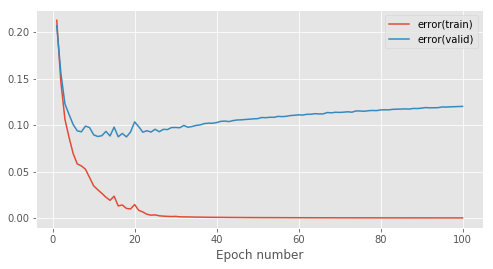

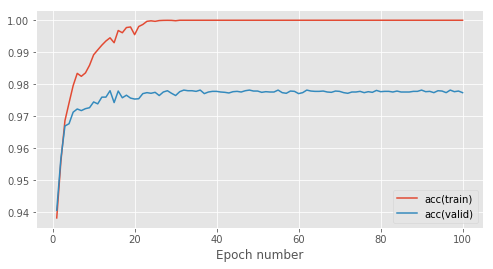

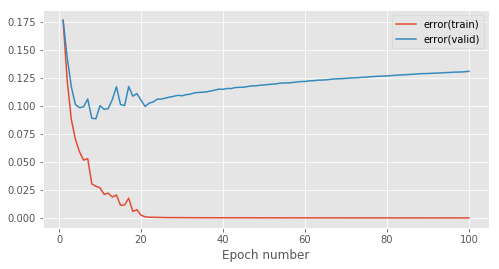

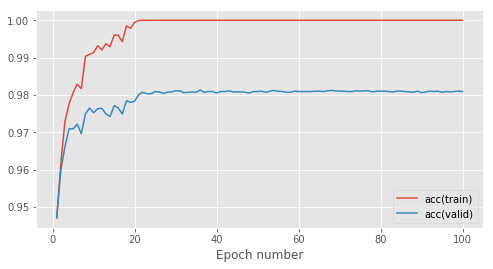

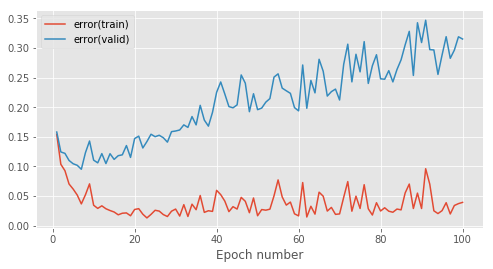

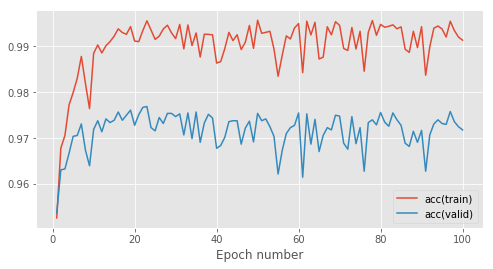

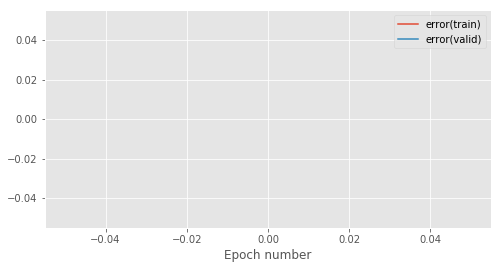

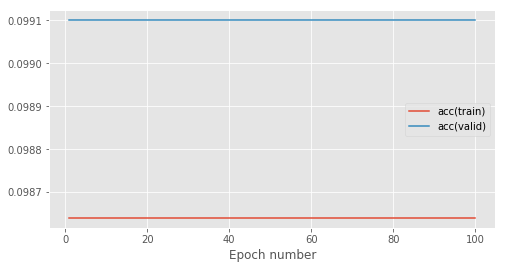

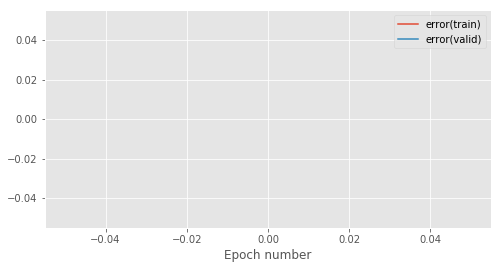

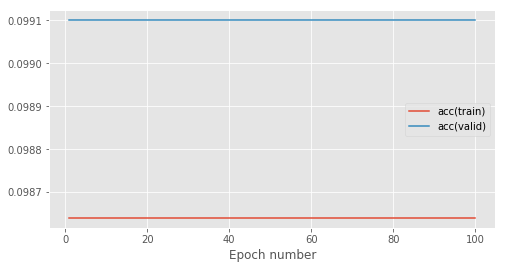

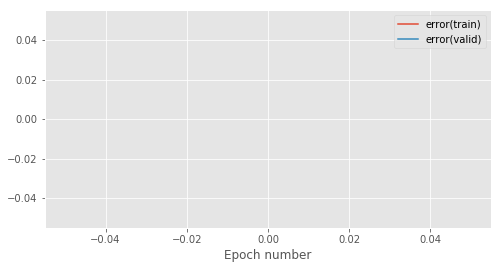

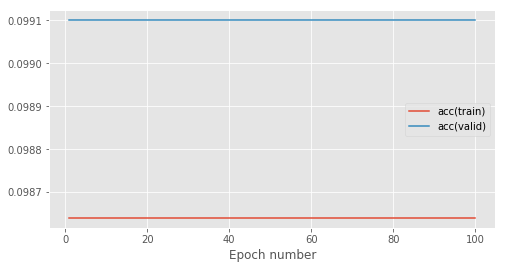

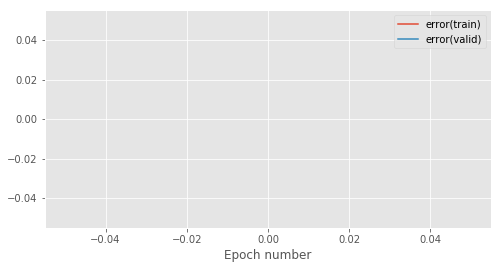

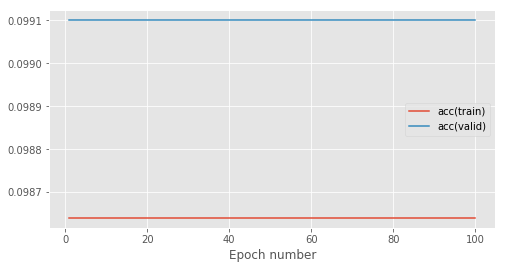

In [67]:
sgdcompare()

In [69]:
experiment_layers_l234 = dict((a,experiment_layers[a]) for a in [2,3,4])

`Analysis of first experiment`:

From the graphs, we can see that as the number of layers increases, convergence takes longer, and validation set error and accuracy fluctuates drastically. This means that we are not exaclty reaching the local minimum for deeper models (models with 6 and more hidden layers), but moving around. This is noted in: http://ufldl.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
    
    If the objective has the form of a long shallow ravine leading to the optimum and steep walls on the sides, standard SGD will tend to oscillate across the narrow ravine since the negative gradient will point down one of the steep sides rather than along the ravine towards the optimum.

Henceforth, instead of using stochastic gadient descent with fix learning rate, we will be using the proprietary `MomentumLearningRule()`:

### Experiment  with Momentum Learning Rule

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 2 layers
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 1.6s to complete
    error(train)=3.71e-01, acc(train)=8.94e-01, error(valid)=3.38e-01, acc(valid)=9.06e-01, error(test)=3.50e-01, acc(test)=9.02e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 1.7s to complete
    error(train)=3.15e-01, acc(train)=9.09e-01, error(valid)=2.93e-01, acc(valid)=9.17e-01, error(test)=3.00e-01, acc(test)=9.15e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 1.6s to complete
    error(train)=2.89e-01, acc(train)=9.16e-01, error(valid)=2.73e-01, acc(valid)=9.21e-01, error(test)=2.80e-01, acc(test)=9.23e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 1.6s to complete
    error(train)=2.68e-01, acc(train)=9.23e-01, error(valid)=2.54e-01, acc(valid)=9.27e-01, error(test)=2.62e-01, acc(test)=9.27e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 1.6s to complete
    error(train)=2.53e-01, acc(train)=9.28e-01, error(valid)=2.44e-01, acc(valid)=9.29e-01, error(test)=2.50e-01, acc(test)=9.27e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 1.7s to complete
    error(train)=2.38e-01, acc(train)=9.32e-01, error(valid)=2.30e-01, acc(valid)=9.33e-01, error(test)=2.39e-01, acc(test)=9.32e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 1.6s to complete
    error(train)=2.29e-01, acc(train)=9.34e-01, error(valid)=2.25e-01, acc(valid)=9.35e-01, error(test)=2.30e-01, acc(test)=9.34e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 1.7s to complete
    error(train)=2.16e-01, acc(train)=9.39e-01, error(valid)=2.12e-01, acc(valid)=9.40e-01, error(test)=2.17e-01, acc(test)=9.38e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 1.6s to complete
    error(train)=2.02e-01, acc(train)=9.42e-01, error(valid)=2.00e-01, acc(valid)=9.42e-01, error(test)=2.08e-01, acc(test)=9.41e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 1.7s to complete
    error(train)=1.92e-01, acc(train)=9.45e-01, error(valid)=1.91e-01, acc(valid)=9.45e-01, error(test)=1.98e-01, acc(test)=9.44e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 1.6s to complete
    error(train)=1.82e-01, acc(train)=9.48e-01, error(valid)=1.83e-01, acc(valid)=9.49e-01, error(test)=1.90e-01, acc(test)=9.44e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 1.6s to complete
    error(train)=1.73e-01, acc(train)=9.51e-01, error(valid)=1.76e-01, acc(valid)=9.51e-01, error(test)=1.82e-01, acc(test)=9.46e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 1.6s to complete
    error(train)=1.65e-01, acc(train)=9.53e-01, error(valid)=1.71e-01, acc(valid)=9.53e-01, error(test)=1.76e-01, acc(test)=9.47e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 1.7s to complete
    error(train)=1.58e-01, acc(train)=9.54e-01, error(valid)=1.64e-01, acc(valid)=9.54e-01, error(test)=1.71e-01, acc(test)=9.49e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 1.6s to complete
    error(train)=1.51e-01, acc(train)=9.57e-01, error(valid)=1.60e-01, acc(valid)=9.55e-01, error(test)=1.65e-01, acc(test)=9.51e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 1.7s to complete
    error(train)=1.44e-01, acc(train)=9.59e-01, error(valid)=1.54e-01, acc(valid)=9.56e-01, error(test)=1.58e-01, acc(test)=9.53e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 1.6s to complete
    error(train)=1.38e-01, acc(train)=9.61e-01, error(valid)=1.50e-01, acc(valid)=9.58e-01, error(test)=1.54e-01, acc(test)=9.55e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 1.6s to complete
    error(train)=1.37e-01, acc(train)=9.60e-01, error(valid)=1.49e-01, acc(valid)=9.58e-01, error(test)=1.56e-01, acc(test)=9.56e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 1.6s to complete
    error(train)=1.29e-01, acc(train)=9.64e-01, error(valid)=1.44e-01, acc(valid)=9.58e-01, error(test)=1.46e-01, acc(test)=9.58e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 1.6s to complete
    error(train)=1.25e-01, acc(train)=9.64e-01, error(valid)=1.40e-01, acc(valid)=9.60e-01, error(test)=1.44e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 1.6s to complete
    error(train)=1.18e-01, acc(train)=9.66e-01, error(valid)=1.35e-01, acc(valid)=9.61e-01, error(test)=1.39e-01, acc(test)=9.60e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 1.6s to complete
    error(train)=1.16e-01, acc(train)=9.66e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, error(test)=1.40e-01, acc(test)=9.60e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 1.6s to complete
    error(train)=1.11e-01, acc(train)=9.68e-01, error(valid)=1.31e-01, acc(valid)=9.62e-01, error(test)=1.35e-01, acc(test)=9.61e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 1.6s to complete
    error(train)=1.08e-01, acc(train)=9.70e-01, error(valid)=1.28e-01, acc(valid)=9.62e-01, error(test)=1.30e-01, acc(test)=9.61e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 1.6s to complete
    error(train)=1.04e-01, acc(train)=9.70e-01, error(valid)=1.26e-01, acc(valid)=9.63e-01, error(test)=1.29e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 1.6s to complete
    error(train)=1.01e-01, acc(train)=9.72e-01, error(valid)=1.24e-01, acc(valid)=9.65e-01, error(test)=1.27e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 1.6s to complete
    error(train)=9.67e-02, acc(train)=9.73e-01, error(valid)=1.21e-01, acc(valid)=9.64e-01, error(test)=1.24e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 1.6s to complete
    error(train)=9.40e-02, acc(train)=9.73e-01, error(valid)=1.20e-01, acc(valid)=9.64e-01, error(test)=1.23e-01, acc(test)=9.64e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 1.6s to complete
    error(train)=9.10e-02, acc(train)=9.75e-01, error(valid)=1.17e-01, acc(valid)=9.66e-01, error(test)=1.19e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 1.6s to complete
    error(train)=8.88e-02, acc(train)=9.75e-01, error(valid)=1.15e-01, acc(valid)=9.66e-01, error(test)=1.19e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 1.6s to complete
    error(train)=8.66e-02, acc(train)=9.76e-01, error(valid)=1.15e-01, acc(valid)=9.66e-01, error(test)=1.19e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 1.6s to complete
    error(train)=8.37e-02, acc(train)=9.76e-01, error(valid)=1.13e-01, acc(valid)=9.67e-01, error(test)=1.18e-01, acc(test)=9.64e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 1.7s to complete
    error(train)=8.07e-02, acc(train)=9.77e-01, error(valid)=1.13e-01, acc(valid)=9.67e-01, error(test)=1.15e-01, acc(test)=9.64e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 1.6s to complete
    error(train)=7.91e-02, acc(train)=9.78e-01, error(valid)=1.10e-01, acc(valid)=9.67e-01, error(test)=1.13e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 1.7s to complete
    error(train)=7.62e-02, acc(train)=9.79e-01, error(valid)=1.08e-01, acc(valid)=9.68e-01, error(test)=1.10e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 1.6s to complete
    error(train)=7.56e-02, acc(train)=9.79e-01, error(valid)=1.07e-01, acc(valid)=9.68e-01, error(test)=1.11e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 1.7s to complete
    error(train)=7.24e-02, acc(train)=9.80e-01, error(valid)=1.07e-01, acc(valid)=9.68e-01, error(test)=1.09e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 1.6s to complete
    error(train)=7.02e-02, acc(train)=9.81e-01, error(valid)=1.05e-01, acc(valid)=9.69e-01, error(test)=1.08e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 1.7s to complete
    error(train)=6.81e-02, acc(train)=9.82e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, error(test)=1.06e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 1.6s to complete
    error(train)=6.61e-02, acc(train)=9.82e-01, error(valid)=1.03e-01, acc(valid)=9.70e-01, error(test)=1.08e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 1.7s to complete
    error(train)=6.41e-02, acc(train)=9.83e-01, error(valid)=1.02e-01, acc(valid)=9.69e-01, error(test)=1.05e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 1.6s to complete
    error(train)=6.29e-02, acc(train)=9.83e-01, error(valid)=1.01e-01, acc(valid)=9.70e-01, error(test)=1.05e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 1.7s to complete
    error(train)=6.09e-02, acc(train)=9.84e-01, error(valid)=9.92e-02, acc(valid)=9.70e-01, error(test)=1.03e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 1.6s to complete
    error(train)=5.95e-02, acc(train)=9.84e-01, error(valid)=9.88e-02, acc(valid)=9.71e-01, error(test)=1.03e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 1.7s to complete
    error(train)=5.84e-02, acc(train)=9.85e-01, error(valid)=9.96e-02, acc(valid)=9.70e-01, error(test)=1.03e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 1.7s to complete
    error(train)=5.61e-02, acc(train)=9.85e-01, error(valid)=9.74e-02, acc(valid)=9.71e-01, error(test)=1.01e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 1.7s to complete
    error(train)=5.57e-02, acc(train)=9.86e-01, error(valid)=9.71e-02, acc(valid)=9.71e-01, error(test)=1.01e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 1.6s to complete
    error(train)=5.45e-02, acc(train)=9.86e-01, error(valid)=9.97e-02, acc(valid)=9.70e-01, error(test)=1.02e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 1.7s to complete
    error(train)=5.26e-02, acc(train)=9.86e-01, error(valid)=9.71e-02, acc(valid)=9.71e-01, error(test)=1.01e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 1.6s to complete
    error(train)=5.15e-02, acc(train)=9.87e-01, error(valid)=9.72e-02, acc(valid)=9.72e-01, error(test)=9.93e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 1.7s to complete
    error(train)=4.98e-02, acc(train)=9.88e-01, error(valid)=9.54e-02, acc(valid)=9.72e-01, error(test)=9.77e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 1.7s to complete
    error(train)=4.91e-02, acc(train)=9.88e-01, error(valid)=9.43e-02, acc(valid)=9.72e-01, error(test)=9.74e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 1.7s to complete
    error(train)=4.76e-02, acc(train)=9.88e-01, error(valid)=9.45e-02, acc(valid)=9.72e-01, error(test)=9.67e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 1.6s to complete
    error(train)=4.61e-02, acc(train)=9.89e-01, error(valid)=9.42e-02, acc(valid)=9.71e-01, error(test)=9.68e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 1.6s to complete
    error(train)=4.49e-02, acc(train)=9.89e-01, error(valid)=9.37e-02, acc(valid)=9.73e-01, error(test)=9.70e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 1.7s to complete
    error(train)=4.56e-02, acc(train)=9.89e-01, error(valid)=9.36e-02, acc(valid)=9.73e-01, error(test)=9.82e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 1.6s to complete
    error(train)=4.29e-02, acc(train)=9.90e-01, error(valid)=9.28e-02, acc(valid)=9.73e-01, error(test)=9.67e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 1.7s to complete
    error(train)=4.14e-02, acc(train)=9.90e-01, error(valid)=9.17e-02, acc(valid)=9.72e-01, error(test)=9.47e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 1.6s to complete
    error(train)=4.06e-02, acc(train)=9.90e-01, error(valid)=9.17e-02, acc(valid)=9.73e-01, error(test)=9.49e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 1.7s to complete
    error(train)=4.03e-02, acc(train)=9.90e-01, error(valid)=9.26e-02, acc(valid)=9.72e-01, error(test)=9.28e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 1.6s to complete
    error(train)=3.88e-02, acc(train)=9.91e-01, error(valid)=9.09e-02, acc(valid)=9.73e-01, error(test)=9.35e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 1.8s to complete
    error(train)=3.81e-02, acc(train)=9.91e-01, error(valid)=9.09e-02, acc(valid)=9.73e-01, error(test)=9.30e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 1.7s to complete
    error(train)=3.74e-02, acc(train)=9.91e-01, error(valid)=9.15e-02, acc(valid)=9.73e-01, error(test)=9.35e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 1.7s to complete
    error(train)=3.59e-02, acc(train)=9.92e-01, error(valid)=9.03e-02, acc(valid)=9.73e-01, error(test)=9.38e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 1.6s to complete
    error(train)=3.55e-02, acc(train)=9.92e-01, error(valid)=9.09e-02, acc(valid)=9.73e-01, error(test)=9.45e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 1.7s to complete
    error(train)=3.60e-02, acc(train)=9.92e-01, error(valid)=9.19e-02, acc(valid)=9.72e-01, error(test)=9.55e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 1.6s to complete
    error(train)=3.39e-02, acc(train)=9.92e-01, error(valid)=9.00e-02, acc(valid)=9.73e-01, error(test)=9.22e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 1.7s to complete
    error(train)=3.28e-02, acc(train)=9.92e-01, error(valid)=8.94e-02, acc(valid)=9.73e-01, error(test)=9.21e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 1.6s to complete
    error(train)=3.24e-02, acc(train)=9.93e-01, error(valid)=9.02e-02, acc(valid)=9.74e-01, error(test)=9.32e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 1.7s to complete
    error(train)=3.14e-02, acc(train)=9.93e-01, error(valid)=9.04e-02, acc(valid)=9.73e-01, error(test)=9.31e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 1.6s to complete
    error(train)=3.05e-02, acc(train)=9.93e-01, error(valid)=8.89e-02, acc(valid)=9.75e-01, error(test)=9.34e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 1.7s to complete
    error(train)=3.03e-02, acc(train)=9.93e-01, error(valid)=8.97e-02, acc(valid)=9.74e-01, error(test)=9.21e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 1.6s to complete
    error(train)=2.94e-02, acc(train)=9.94e-01, error(valid)=8.88e-02, acc(valid)=9.74e-01, error(test)=9.22e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 1.7s to complete
    error(train)=2.87e-02, acc(train)=9.94e-01, error(valid)=8.86e-02, acc(valid)=9.74e-01, error(test)=9.23e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 1.6s to complete
    error(train)=2.83e-02, acc(train)=9.94e-01, error(valid)=8.97e-02, acc(valid)=9.74e-01, error(test)=9.23e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 1.6s to complete
    error(train)=2.79e-02, acc(train)=9.94e-01, error(valid)=9.06e-02, acc(valid)=9.74e-01, error(test)=9.19e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 1.6s to complete
    error(train)=2.70e-02, acc(train)=9.94e-01, error(valid)=9.01e-02, acc(valid)=9.73e-01, error(test)=9.13e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 1.6s to complete
    error(train)=2.57e-02, acc(train)=9.95e-01, error(valid)=8.75e-02, acc(valid)=9.75e-01, error(test)=9.05e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 1.6s to complete
    error(train)=2.60e-02, acc(train)=9.95e-01, error(valid)=8.95e-02, acc(valid)=9.74e-01, error(test)=9.30e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 1.6s to complete
    error(train)=2.46e-02, acc(train)=9.95e-01, error(valid)=8.79e-02, acc(valid)=9.76e-01, error(test)=9.18e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 1.6s to complete
    error(train)=2.43e-02, acc(train)=9.95e-01, error(valid)=8.77e-02, acc(valid)=9.75e-01, error(test)=9.06e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 1.6s to complete
    error(train)=2.46e-02, acc(train)=9.95e-01, error(valid)=8.89e-02, acc(valid)=9.75e-01, error(test)=9.19e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 1.7s to complete
    error(train)=2.30e-02, acc(train)=9.96e-01, error(valid)=8.73e-02, acc(valid)=9.75e-01, error(test)=9.11e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 1.7s to complete
    error(train)=2.32e-02, acc(train)=9.96e-01, error(valid)=8.90e-02, acc(valid)=9.75e-01, error(test)=9.19e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 1.6s to complete
    error(train)=2.22e-02, acc(train)=9.96e-01, error(valid)=8.78e-02, acc(valid)=9.75e-01, error(test)=9.03e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 1.7s to complete
    error(train)=2.18e-02, acc(train)=9.96e-01, error(valid)=8.81e-02, acc(valid)=9.75e-01, error(test)=9.17e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 1.6s to complete
    error(train)=2.15e-02, acc(train)=9.96e-01, error(valid)=8.89e-02, acc(valid)=9.74e-01, error(test)=9.18e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 1.6s to complete
    error(train)=2.11e-02, acc(train)=9.96e-01, error(valid)=8.79e-02, acc(valid)=9.75e-01, error(test)=9.07e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 1.6s to complete
    error(train)=2.04e-02, acc(train)=9.96e-01, error(valid)=8.92e-02, acc(valid)=9.75e-01, error(test)=9.29e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 1.6s to complete
    error(train)=1.98e-02, acc(train)=9.97e-01, error(valid)=8.88e-02, acc(valid)=9.75e-01, error(test)=9.14e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 1.7s to complete
    error(train)=1.98e-02, acc(train)=9.97e-01, error(valid)=8.77e-02, acc(valid)=9.75e-01, error(test)=9.12e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 1.6s to complete
    error(train)=1.90e-02, acc(train)=9.97e-01, error(valid)=8.97e-02, acc(valid)=9.75e-01, error(test)=9.24e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 1.7s to complete
    error(train)=1.89e-02, acc(train)=9.97e-01, error(valid)=8.92e-02, acc(valid)=9.75e-01, error(test)=9.20e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 1.6s to complete
    error(train)=1.84e-02, acc(train)=9.97e-01, error(valid)=8.83e-02, acc(valid)=9.76e-01, error(test)=9.12e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 1.7s to complete
    error(train)=1.83e-02, acc(train)=9.97e-01, error(valid)=9.09e-02, acc(valid)=9.75e-01, error(test)=9.42e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 1.6s to complete
    error(train)=1.81e-02, acc(train)=9.97e-01, error(valid)=9.14e-02, acc(valid)=9.74e-01, error(test)=9.40e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 1.7s to complete
    error(train)=1.69e-02, acc(train)=9.98e-01, error(valid)=8.86e-02, acc(valid)=9.75e-01, error(test)=9.14e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 1.6s to complete
    error(train)=1.67e-02, acc(train)=9.98e-01, error(valid)=8.94e-02, acc(valid)=9.76e-01, error(test)=9.26e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 1.7s to complete
    error(train)=1.64e-02, acc(train)=9.98e-01, error(valid)=8.88e-02, acc(valid)=9.76e-01, error(test)=9.27e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 1.6s to complete
    error(train)=1.64e-02, acc(train)=9.98e-01, error(valid)=8.88e-02, acc(valid)=9.76e-01, error(test)=9.17e-02, acc(test)=9.75e-01, params_penalty=0.00e+00



MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 3 layers
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 1.9s to complete
    error(train)=3.33e-01, acc(train)=9.03e-01, error(valid)=3.10e-01, acc(valid)=9.10e-01, error(test)=3.16e-01, acc(test)=9.09e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 2.0s to complete
    error(train)=2.82e-01, acc(train)=9.20e-01, error(valid)=2.70e-01, acc(valid)=9.22e-01, error(test)=2.74e-01, acc(test)=9.21e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 1.9s to complete
    error(train)=2.51e-01, acc(train)=9.28e-01, error(valid)=2.45e-01, acc(valid)=9.30e-01, error(test)=2.46e-01, acc(test)=9.28e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 1.9s to complete
    error(train)=2.29e-01, acc(train)=9.34e-01, error(valid)=2.29e-01, acc(valid)=9.34e-01, error(test)=2.31e-01, acc(test)=9.32e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 1.9s to complete
    error(train)=2.07e-01, acc(train)=9.40e-01, error(valid)=2.09e-01, acc(valid)=9.42e-01, error(test)=2.12e-01, acc(test)=9.39e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 1.9s to complete
    error(train)=1.90e-01, acc(train)=9.45e-01, error(valid)=1.95e-01, acc(valid)=9.47e-01, error(test)=1.96e-01, acc(test)=9.42e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 2.0s to complete
    error(train)=1.73e-01, acc(train)=9.50e-01, error(valid)=1.82e-01, acc(valid)=9.49e-01, error(test)=1.83e-01, acc(test)=9.47e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 1.9s to complete
    error(train)=1.59e-01, acc(train)=9.55e-01, error(valid)=1.70e-01, acc(valid)=9.53e-01, error(test)=1.71e-01, acc(test)=9.50e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 1.9s to complete
    error(train)=1.50e-01, acc(train)=9.57e-01, error(valid)=1.64e-01, acc(valid)=9.54e-01, error(test)=1.64e-01, acc(test)=9.51e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 2.0s to complete
    error(train)=1.35e-01, acc(train)=9.62e-01, error(valid)=1.52e-01, acc(valid)=9.57e-01, error(test)=1.50e-01, acc(test)=9.56e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 1.9s to complete
    error(train)=1.25e-01, acc(train)=9.65e-01, error(valid)=1.43e-01, acc(valid)=9.60e-01, error(test)=1.42e-01, acc(test)=9.58e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 2.0s to complete
    error(train)=1.18e-01, acc(train)=9.66e-01, error(valid)=1.40e-01, acc(valid)=9.61e-01, error(test)=1.38e-01, acc(test)=9.58e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 2.0s to complete
    error(train)=1.10e-01, acc(train)=9.69e-01, error(valid)=1.33e-01, acc(valid)=9.62e-01, error(test)=1.31e-01, acc(test)=9.60e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 1.9s to complete
    error(train)=1.04e-01, acc(train)=9.71e-01, error(valid)=1.30e-01, acc(valid)=9.63e-01, error(test)=1.26e-01, acc(test)=9.61e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 1.9s to complete
    error(train)=9.66e-02, acc(train)=9.73e-01, error(valid)=1.24e-01, acc(valid)=9.64e-01, error(test)=1.21e-01, acc(test)=9.62e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 1.9s to complete
    error(train)=9.16e-02, acc(train)=9.75e-01, error(valid)=1.20e-01, acc(valid)=9.66e-01, error(test)=1.17e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 2.0s to complete
    error(train)=8.62e-02, acc(train)=9.76e-01, error(valid)=1.16e-01, acc(valid)=9.67e-01, error(test)=1.16e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 1.9s to complete
    error(train)=8.39e-02, acc(train)=9.76e-01, error(valid)=1.15e-01, acc(valid)=9.67e-01, error(test)=1.12e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 1.9s to complete
    error(train)=7.84e-02, acc(train)=9.78e-01, error(valid)=1.15e-01, acc(valid)=9.66e-01, error(test)=1.09e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 2.0s to complete
    error(train)=7.38e-02, acc(train)=9.79e-01, error(valid)=1.12e-01, acc(valid)=9.67e-01, error(test)=1.06e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 1.9s to complete
    error(train)=7.00e-02, acc(train)=9.80e-01, error(valid)=1.08e-01, acc(valid)=9.69e-01, error(test)=1.04e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 2.0s to complete
    error(train)=7.02e-02, acc(train)=9.80e-01, error(valid)=1.09e-01, acc(valid)=9.69e-01, error(test)=1.06e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 1.9s to complete
    error(train)=6.54e-02, acc(train)=9.82e-01, error(valid)=1.06e-01, acc(valid)=9.69e-01, error(test)=1.02e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 1.9s to complete
    error(train)=6.07e-02, acc(train)=9.83e-01, error(valid)=1.03e-01, acc(valid)=9.70e-01, error(test)=9.89e-02, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 2.0s to complete
    error(train)=5.89e-02, acc(train)=9.83e-01, error(valid)=1.02e-01, acc(valid)=9.70e-01, error(test)=9.78e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 1.9s to complete
    error(train)=5.77e-02, acc(train)=9.84e-01, error(valid)=1.03e-01, acc(valid)=9.70e-01, error(test)=9.98e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 2.0s to complete
    error(train)=5.24e-02, acc(train)=9.86e-01, error(valid)=9.84e-02, acc(valid)=9.71e-01, error(test)=9.54e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 2.0s to complete
    error(train)=4.97e-02, acc(train)=9.87e-01, error(valid)=9.74e-02, acc(valid)=9.71e-01, error(test)=9.27e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 1.9s to complete
    error(train)=4.76e-02, acc(train)=9.87e-01, error(valid)=9.66e-02, acc(valid)=9.72e-01, error(test)=9.24e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 2.0s to complete
    error(train)=4.60e-02, acc(train)=9.88e-01, error(valid)=9.60e-02, acc(valid)=9.73e-01, error(test)=9.25e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 1.9s to complete
    error(train)=4.36e-02, acc(train)=9.89e-01, error(valid)=9.82e-02, acc(valid)=9.71e-01, error(test)=9.09e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 1.9s to complete
    error(train)=4.20e-02, acc(train)=9.89e-01, error(valid)=9.71e-02, acc(valid)=9.72e-01, error(test)=9.24e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 2.0s to complete
    error(train)=3.88e-02, acc(train)=9.91e-01, error(valid)=9.53e-02, acc(valid)=9.73e-01, error(test)=8.89e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 1.9s to complete
    error(train)=3.75e-02, acc(train)=9.91e-01, error(valid)=9.44e-02, acc(valid)=9.73e-01, error(test)=8.74e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 2.0s to complete
    error(train)=3.88e-02, acc(train)=9.89e-01, error(valid)=9.72e-02, acc(valid)=9.71e-01, error(test)=9.07e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 1.9s to complete
    error(train)=3.48e-02, acc(train)=9.92e-01, error(valid)=9.49e-02, acc(valid)=9.72e-01, error(test)=8.80e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 2.0s to complete
    error(train)=3.34e-02, acc(train)=9.92e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, error(test)=8.63e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 2.0s to complete
    error(train)=3.19e-02, acc(train)=9.93e-01, error(valid)=9.48e-02, acc(valid)=9.73e-01, error(test)=8.85e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 1.9s to complete
    error(train)=3.14e-02, acc(train)=9.93e-01, error(valid)=9.59e-02, acc(valid)=9.71e-01, error(test)=8.81e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 2.0s to complete
    error(train)=2.85e-02, acc(train)=9.94e-01, error(valid)=9.29e-02, acc(valid)=9.73e-01, error(test)=8.67e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 2.0s to complete
    error(train)=2.73e-02, acc(train)=9.94e-01, error(valid)=9.23e-02, acc(valid)=9.74e-01, error(test)=8.78e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 1.9s to complete
    error(train)=2.83e-02, acc(train)=9.94e-01, error(valid)=9.32e-02, acc(valid)=9.73e-01, error(test)=8.66e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 2.0s to complete
    error(train)=2.66e-02, acc(train)=9.94e-01, error(valid)=9.32e-02, acc(valid)=9.73e-01, error(test)=8.62e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 1.9s to complete
    error(train)=2.44e-02, acc(train)=9.95e-01, error(valid)=9.21e-02, acc(valid)=9.74e-01, error(test)=8.72e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 1.9s to complete
    error(train)=2.36e-02, acc(train)=9.95e-01, error(valid)=9.46e-02, acc(valid)=9.73e-01, error(test)=8.82e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 1.9s to complete
    error(train)=2.24e-02, acc(train)=9.96e-01, error(valid)=9.18e-02, acc(valid)=9.74e-01, error(test)=8.52e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 1.9s to complete
    error(train)=2.23e-02, acc(train)=9.96e-01, error(valid)=9.20e-02, acc(valid)=9.74e-01, error(test)=8.68e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 2.0s to complete
    error(train)=2.07e-02, acc(train)=9.96e-01, error(valid)=9.43e-02, acc(valid)=9.75e-01, error(test)=8.85e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 1.9s to complete
    error(train)=1.94e-02, acc(train)=9.97e-01, error(valid)=9.28e-02, acc(valid)=9.74e-01, error(test)=8.54e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 1.9s to complete
    error(train)=2.24e-02, acc(train)=9.95e-01, error(valid)=1.00e-01, acc(valid)=9.72e-01, error(test)=8.96e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 2.0s to complete
    error(train)=1.78e-02, acc(train)=9.97e-01, error(valid)=9.40e-02, acc(valid)=9.73e-01, error(test)=8.75e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 1.9s to complete
    error(train)=1.70e-02, acc(train)=9.97e-01, error(valid)=9.42e-02, acc(valid)=9.74e-01, error(test)=8.75e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 2.0s to complete
    error(train)=1.61e-02, acc(train)=9.97e-01, error(valid)=9.47e-02, acc(valid)=9.75e-01, error(test)=8.71e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 1.9s to complete
    error(train)=1.66e-02, acc(train)=9.97e-01, error(valid)=9.47e-02, acc(valid)=9.75e-01, error(test)=8.82e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 1.9s to complete
    error(train)=1.48e-02, acc(train)=9.98e-01, error(valid)=9.36e-02, acc(valid)=9.74e-01, error(test)=8.51e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 2.0s to complete
    error(train)=1.46e-02, acc(train)=9.98e-01, error(valid)=9.58e-02, acc(valid)=9.75e-01, error(test)=8.88e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 1.9s to complete
    error(train)=1.34e-02, acc(train)=9.98e-01, error(valid)=9.39e-02, acc(valid)=9.75e-01, error(test)=8.58e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 2.0s to complete
    error(train)=1.33e-02, acc(train)=9.98e-01, error(valid)=9.31e-02, acc(valid)=9.74e-01, error(test)=8.62e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 2.1s to complete
    error(train)=1.25e-02, acc(train)=9.99e-01, error(valid)=9.53e-02, acc(valid)=9.75e-01, error(test)=8.66e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 1.9s to complete
    error(train)=1.21e-02, acc(train)=9.98e-01, error(valid)=9.61e-02, acc(valid)=9.74e-01, error(test)=8.96e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 2.0s to complete
    error(train)=1.14e-02, acc(train)=9.99e-01, error(valid)=9.66e-02, acc(valid)=9.73e-01, error(test)=8.84e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 1.9s to complete
    error(train)=1.09e-02, acc(train)=9.99e-01, error(valid)=9.67e-02, acc(valid)=9.74e-01, error(test)=8.95e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 1.9s to complete
    error(train)=1.11e-02, acc(train)=9.99e-01, error(valid)=9.81e-02, acc(valid)=9.73e-01, error(test)=8.85e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 2.0s to complete
    error(train)=1.05e-02, acc(train)=9.99e-01, error(valid)=9.68e-02, acc(valid)=9.74e-01, error(test)=9.00e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 1.9s to complete
    error(train)=1.05e-02, acc(train)=9.99e-01, error(valid)=9.95e-02, acc(valid)=9.75e-01, error(test)=9.21e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 2.0s to complete
    error(train)=9.77e-03, acc(train)=9.99e-01, error(valid)=9.71e-02, acc(valid)=9.75e-01, error(test)=9.04e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 1.9s to complete
    error(train)=9.10e-03, acc(train)=9.99e-01, error(valid)=1.00e-01, acc(valid)=9.74e-01, error(test)=9.21e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 1.9s to complete
    error(train)=8.47e-03, acc(train)=9.99e-01, error(valid)=9.93e-02, acc(valid)=9.74e-01, error(test)=9.11e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 2.0s to complete
    error(train)=8.48e-03, acc(train)=9.99e-01, error(valid)=9.80e-02, acc(valid)=9.74e-01, error(test)=9.17e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 1.9s to complete
    error(train)=8.61e-03, acc(train)=9.99e-01, error(valid)=9.82e-02, acc(valid)=9.74e-01, error(test)=9.16e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 2.0s to complete
    error(train)=8.25e-03, acc(train)=9.99e-01, error(valid)=1.02e-01, acc(valid)=9.73e-01, error(test)=9.14e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 1.9s to complete
    error(train)=7.47e-03, acc(train)=1.00e+00, error(valid)=9.95e-02, acc(valid)=9.75e-01, error(test)=9.19e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 1.9s to complete
    error(train)=7.53e-03, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.75e-01, error(test)=9.34e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 2.0s to complete
    error(train)=6.95e-03, acc(train)=1.00e+00, error(valid)=9.93e-02, acc(valid)=9.75e-01, error(test)=9.23e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 1.9s to complete
    error(train)=6.56e-03, acc(train)=1.00e+00, error(valid)=1.02e-01, acc(valid)=9.74e-01, error(test)=9.34e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 2.0s to complete
    error(train)=6.49e-03, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.74e-01, error(test)=9.28e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 1.9s to complete
    error(train)=6.12e-03, acc(train)=1.00e+00, error(valid)=1.02e-01, acc(valid)=9.75e-01, error(test)=9.41e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 1.9s to complete
    error(train)=5.87e-03, acc(train)=1.00e+00, error(valid)=1.02e-01, acc(valid)=9.74e-01, error(test)=9.45e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 2.0s to complete
    error(train)=5.62e-03, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.74e-01, error(test)=9.38e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 1.9s to complete
    error(train)=5.44e-03, acc(train)=1.00e+00, error(valid)=1.03e-01, acc(valid)=9.74e-01, error(test)=9.53e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 1.9s to complete
    error(train)=5.12e-03, acc(train)=1.00e+00, error(valid)=1.03e-01, acc(valid)=9.75e-01, error(test)=9.48e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 2.0s to complete
    error(train)=5.29e-03, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.75e-01, error(test)=9.60e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 1.9s to complete
    error(train)=5.17e-03, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.74e-01, error(test)=9.51e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 2.0s to complete
    error(train)=4.74e-03, acc(train)=1.00e+00, error(valid)=1.05e-01, acc(valid)=9.74e-01, error(test)=9.64e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 1.9s to complete
    error(train)=4.71e-03, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.74e-01, error(test)=9.56e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 1.9s to complete
    error(train)=4.40e-03, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.74e-01, error(test)=9.59e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 2.0s to complete
    error(train)=4.31e-03, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.75e-01, error(test)=9.68e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 1.9s to complete
    error(train)=4.14e-03, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.75e-01, error(test)=9.70e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 2.0s to complete
    error(train)=4.07e-03, acc(train)=1.00e+00, error(valid)=1.05e-01, acc(valid)=9.75e-01, error(test)=9.66e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 1.9s to complete
    error(train)=4.13e-03, acc(train)=1.00e+00, error(valid)=1.07e-01, acc(valid)=9.74e-01, error(test)=9.67e-02, acc(test)=9.77e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 1.9s to complete
    error(train)=3.79e-03, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.75e-01, error(test)=9.75e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 2.0s to complete
    error(train)=3.86e-03, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.75e-01, error(test)=9.75e-02, acc(test)=9.77e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 1.9s to complete
    error(train)=3.66e-03, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.75e-01, error(test)=9.80e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 2.0s to complete
    error(train)=3.59e-03, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.74e-01, error(test)=9.93e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 1.9s to complete
    error(train)=3.64e-03, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.75e-01, error(test)=9.97e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 2.0s to complete
    error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=1.10e-01, acc(valid)=9.75e-01, error(test)=9.99e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 2.0s to complete
    error(train)=3.26e-03, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.74e-01, error(test)=9.98e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 1.9s to complete
    error(train)=3.19e-03, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.75e-01, error(test)=9.96e-02, acc(test)=9.77e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 2.0s to complete
    error(train)=3.29e-03, acc(train)=1.00e+00, error(valid)=1.10e-01, acc(valid)=9.75e-01, error(test)=9.99e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 2.0s to complete
    error(train)=3.04e-03, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.75e-01, error(test)=1.00e-01, acc(test)=9.76e-01, params_penalty=0.00e+00



MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 4 layers
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 2.2s to complete
    error(train)=2.99e-01, acc(train)=9.13e-01, error(valid)=2.76e-01, acc(valid)=9.21e-01, error(test)=2.92e-01, acc(test)=9.16e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 2.2s to complete
    error(train)=2.51e-01, acc(train)=9.27e-01, error(valid)=2.40e-01, acc(valid)=9.30e-01, error(test)=2.55e-01, acc(test)=9.26e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 2.2s to complete
    error(train)=2.13e-01, acc(train)=9.37e-01, error(valid)=2.08e-01, acc(valid)=9.40e-01, error(test)=2.22e-01, acc(test)=9.34e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 2.4s to complete
    error(train)=1.84e-01, acc(train)=9.47e-01, error(valid)=1.85e-01, acc(valid)=9.46e-01, error(test)=1.95e-01, acc(test)=9.41e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 2.2s to complete
    error(train)=1.67e-01, acc(train)=9.51e-01, error(valid)=1.73e-01, acc(valid)=9.49e-01, error(test)=1.80e-01, acc(test)=9.44e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 2.2s to complete
    error(train)=1.44e-01, acc(train)=9.57e-01, error(valid)=1.55e-01, acc(valid)=9.54e-01, error(test)=1.62e-01, acc(test)=9.52e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 2.2s to complete
    error(train)=1.35e-01, acc(train)=9.60e-01, error(valid)=1.47e-01, acc(valid)=9.55e-01, error(test)=1.56e-01, acc(test)=9.52e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 2.2s to complete
    error(train)=1.18e-01, acc(train)=9.65e-01, error(valid)=1.36e-01, acc(valid)=9.62e-01, error(test)=1.41e-01, acc(test)=9.57e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 2.2s to complete
    error(train)=1.09e-01, acc(train)=9.68e-01, error(valid)=1.33e-01, acc(valid)=9.61e-01, error(test)=1.36e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 2.2s to complete
    error(train)=9.89e-02, acc(train)=9.71e-01, error(valid)=1.22e-01, acc(valid)=9.65e-01, error(test)=1.25e-01, acc(test)=9.62e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 2.2s to complete
    error(train)=9.54e-02, acc(train)=9.72e-01, error(valid)=1.25e-01, acc(valid)=9.64e-01, error(test)=1.29e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 2.2s to complete
    error(train)=8.78e-02, acc(train)=9.74e-01, error(valid)=1.20e-01, acc(valid)=9.65e-01, error(test)=1.25e-01, acc(test)=9.61e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 2.2s to complete
    error(train)=7.99e-02, acc(train)=9.76e-01, error(valid)=1.13e-01, acc(valid)=9.67e-01, error(test)=1.16e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 2.2s to complete
    error(train)=7.48e-02, acc(train)=9.77e-01, error(valid)=1.13e-01, acc(valid)=9.66e-01, error(test)=1.12e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 2.2s to complete
    error(train)=6.93e-02, acc(train)=9.79e-01, error(valid)=1.10e-01, acc(valid)=9.68e-01, error(test)=1.12e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 2.2s to complete
    error(train)=6.58e-02, acc(train)=9.81e-01, error(valid)=1.08e-01, acc(valid)=9.68e-01, error(test)=1.11e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 2.2s to complete
    error(train)=6.12e-02, acc(train)=9.82e-01, error(valid)=1.08e-01, acc(valid)=9.70e-01, error(test)=1.10e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 2.2s to complete
    error(train)=5.63e-02, acc(train)=9.84e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, error(test)=1.05e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 2.2s to complete
    error(train)=5.33e-02, acc(train)=9.84e-01, error(valid)=1.05e-01, acc(valid)=9.70e-01, error(test)=1.04e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 2.2s to complete
    error(train)=5.12e-02, acc(train)=9.85e-01, error(valid)=1.05e-01, acc(valid)=9.70e-01, error(test)=1.05e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 2.2s to complete
    error(train)=4.81e-02, acc(train)=9.86e-01, error(valid)=1.03e-01, acc(valid)=9.69e-01, error(test)=1.02e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 2.2s to complete
    error(train)=4.27e-02, acc(train)=9.89e-01, error(valid)=9.91e-02, acc(valid)=9.73e-01, error(test)=9.88e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 2.2s to complete
    error(train)=4.07e-02, acc(train)=9.89e-01, error(valid)=9.94e-02, acc(valid)=9.70e-01, error(test)=9.74e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 2.3s to complete
    error(train)=3.74e-02, acc(train)=9.90e-01, error(valid)=9.65e-02, acc(valid)=9.72e-01, error(test)=9.58e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 2.2s to complete
    error(train)=4.08e-02, acc(train)=9.89e-01, error(valid)=1.06e-01, acc(valid)=9.71e-01, error(test)=1.04e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 2.2s to complete
    error(train)=3.66e-02, acc(train)=9.90e-01, error(valid)=1.01e-01, acc(valid)=9.71e-01, error(test)=9.76e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 2.2s to complete
    error(train)=3.12e-02, acc(train)=9.92e-01, error(valid)=9.75e-02, acc(valid)=9.73e-01, error(test)=9.63e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 2.2s to complete
    error(train)=2.93e-02, acc(train)=9.93e-01, error(valid)=9.81e-02, acc(valid)=9.73e-01, error(test)=9.56e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 2.2s to complete
    error(train)=2.75e-02, acc(train)=9.93e-01, error(valid)=9.84e-02, acc(valid)=9.74e-01, error(test)=9.67e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 2.2s to complete
    error(train)=2.54e-02, acc(train)=9.94e-01, error(valid)=9.85e-02, acc(valid)=9.74e-01, error(test)=9.60e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 2.2s to complete
    error(train)=2.65e-02, acc(train)=9.94e-01, error(valid)=1.02e-01, acc(valid)=9.72e-01, error(test)=9.78e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 2.2s to complete
    error(train)=2.22e-02, acc(train)=9.95e-01, error(valid)=9.97e-02, acc(valid)=9.75e-01, error(test)=9.61e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 2.2s to complete
    error(train)=2.06e-02, acc(train)=9.96e-01, error(valid)=1.00e-01, acc(valid)=9.73e-01, error(test)=9.70e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 2.2s to complete
    error(train)=1.94e-02, acc(train)=9.96e-01, error(valid)=9.97e-02, acc(valid)=9.73e-01, error(test)=9.71e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 2.2s to complete
    error(train)=1.81e-02, acc(train)=9.96e-01, error(valid)=9.96e-02, acc(valid)=9.72e-01, error(test)=9.49e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 2.2s to complete
    error(train)=1.72e-02, acc(train)=9.97e-01, error(valid)=9.89e-02, acc(valid)=9.74e-01, error(test)=9.65e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 2.2s to complete
    error(train)=1.84e-02, acc(train)=9.96e-01, error(valid)=1.05e-01, acc(valid)=9.73e-01, error(test)=1.01e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 2.2s to complete
    error(train)=1.57e-02, acc(train)=9.97e-01, error(valid)=1.00e-01, acc(valid)=9.74e-01, error(test)=9.87e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 2.2s to complete
    error(train)=1.46e-02, acc(train)=9.97e-01, error(valid)=1.02e-01, acc(valid)=9.73e-01, error(test)=1.01e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 2.2s to complete
    error(train)=1.34e-02, acc(train)=9.98e-01, error(valid)=1.03e-01, acc(valid)=9.75e-01, error(test)=1.01e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 2.2s to complete
    error(train)=1.23e-02, acc(train)=9.98e-01, error(valid)=1.01e-01, acc(valid)=9.74e-01, error(test)=9.94e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 2.2s to complete
    error(train)=1.20e-02, acc(train)=9.98e-01, error(valid)=1.04e-01, acc(valid)=9.74e-01, error(test)=1.01e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 2.3s to complete
    error(train)=1.19e-02, acc(train)=9.98e-01, error(valid)=1.07e-01, acc(valid)=9.73e-01, error(test)=1.02e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 2.2s to complete
    error(train)=1.31e-02, acc(train)=9.98e-01, error(valid)=1.09e-01, acc(valid)=9.72e-01, error(test)=1.06e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 2.2s to complete
    error(train)=9.69e-03, acc(train)=9.99e-01, error(valid)=1.04e-01, acc(valid)=9.73e-01, error(test)=1.02e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 2.2s to complete
    error(train)=9.26e-03, acc(train)=9.99e-01, error(valid)=1.06e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 2.3s to complete
    error(train)=8.87e-03, acc(train)=9.99e-01, error(valid)=1.04e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 2.2s to complete
    error(train)=7.83e-03, acc(train)=9.99e-01, error(valid)=1.05e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 2.3s to complete
    error(train)=7.42e-03, acc(train)=9.99e-01, error(valid)=1.06e-01, acc(valid)=9.75e-01, error(test)=1.03e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 2.2s to complete
    error(train)=7.24e-03, acc(train)=9.99e-01, error(valid)=1.06e-01, acc(valid)=9.74e-01, error(test)=1.04e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 2.2s to complete
    error(train)=6.38e-03, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.74e-01, error(test)=1.06e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 2.3s to complete
    error(train)=5.72e-03, acc(train)=1.00e+00, error(valid)=1.07e-01, acc(valid)=9.73e-01, error(test)=1.05e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 2.2s to complete
    error(train)=5.39e-03, acc(train)=1.00e+00, error(valid)=1.07e-01, acc(valid)=9.74e-01, error(test)=1.04e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 2.2s to complete
    error(train)=5.16e-03, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.73e-01, error(test)=1.06e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 2.4s to complete
    error(train)=5.15e-03, acc(train)=1.00e+00, error(valid)=1.10e-01, acc(valid)=9.74e-01, error(test)=1.08e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 2.2s to complete
    error(train)=4.63e-03, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.74e-01, error(test)=1.07e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 2.2s to complete
    error(train)=5.05e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.73e-01, error(test)=1.09e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 2.2s to complete
    error(train)=4.13e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.74e-01, error(test)=1.10e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 2.3s to complete
    error(train)=3.85e-03, acc(train)=1.00e+00, error(valid)=1.11e-01, acc(valid)=9.74e-01, error(test)=1.10e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 2.3s to complete
    error(train)=4.26e-03, acc(train)=1.00e+00, error(valid)=1.14e-01, acc(valid)=9.73e-01, error(test)=1.11e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 2.2s to complete
    error(train)=3.45e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.74e-01, error(test)=1.11e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 2.2s to complete
    error(train)=3.23e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.74e-01, error(test)=1.12e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 2.2s to complete
    error(train)=3.17e-03, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.74e-01, error(test)=1.12e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 2.2s to complete
    error(train)=2.92e-03, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.74e-01, error(test)=1.12e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 2.3s to complete
    error(train)=2.82e-03, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.73e-01, error(test)=1.14e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 2.2s to complete
    error(train)=2.76e-03, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.74e-01, error(test)=1.12e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 2.2s to complete
    error(train)=2.55e-03, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.74e-01, error(test)=1.15e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 2.2s to complete
    error(train)=2.48e-03, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.74e-01, error(test)=1.15e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 2.2s to complete
    error(train)=2.39e-03, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.74e-01, error(test)=1.15e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 2.2s to complete
    error(train)=2.35e-03, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.74e-01, error(test)=1.15e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 2.2s to complete
    error(train)=2.26e-03, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.74e-01, error(test)=1.16e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 2.3s to complete
    error(train)=2.08e-03, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.74e-01, error(test)=1.17e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 2.2s to complete
    error(train)=2.01e-03, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.74e-01, error(test)=1.18e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 2.2s to complete
    error(train)=1.91e-03, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.74e-01, error(test)=1.18e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 2.5s to complete
    error(train)=1.94e-03, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.75e-01, error(test)=1.19e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 2.3s to complete
    error(train)=1.84e-03, acc(train)=1.00e+00, error(valid)=1.21e-01, acc(valid)=9.74e-01, error(test)=1.19e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 2.2s to complete
    error(train)=1.80e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.74e-01, error(test)=1.19e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 2.2s to complete
    error(train)=1.71e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.74e-01, error(test)=1.20e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 2.2s to complete
    error(train)=1.70e-03, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.74e-01, error(test)=1.20e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 2.2s to complete
    error(train)=1.66e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.73e-01, error(test)=1.21e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 2.2s to complete
    error(train)=1.56e-03, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.74e-01, error(test)=1.21e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 2.2s to complete
    error(train)=1.50e-03, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.74e-01, error(test)=1.22e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 2.5s to complete
    error(train)=1.49e-03, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.74e-01, error(test)=1.21e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 2.6s to complete
    error(train)=1.43e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.74e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 2.6s to complete
    error(train)=1.39e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.22e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 2.5s to complete
    error(train)=1.39e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 2.5s to complete
    error(train)=1.29e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.24e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 2.8s to complete
    error(train)=1.27e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.74e-01, error(test)=1.24e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 2.5s to complete
    error(train)=1.28e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.24e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 2.5s to complete
    error(train)=1.21e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.74e-01, error(test)=1.25e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 2.6s to complete
    error(train)=1.20e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.74e-01, error(test)=1.26e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 2.6s to complete
    error(train)=1.16e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.74e-01, error(test)=1.26e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 2.4s to complete
    error(train)=1.14e-03, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.74e-01, error(test)=1.27e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 2.4s to complete
    error(train)=1.11e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.74e-01, error(test)=1.26e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 2.5s to complete
    error(train)=1.11e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.74e-01, error(test)=1.27e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 2.5s to complete
    error(train)=1.06e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.74e-01, error(test)=1.27e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 2.6s to complete
    error(train)=1.05e-03, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.73e-01, error(test)=1.28e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 2.6s to complete
    error(train)=1.02e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.74e-01, error(test)=1.27e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 2.5s to complete
    error(train)=9.97e-04, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.74e-01, error(test)=1.28e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 2.6s to complete
    error(train)=9.60e-04, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.74e-01, error(test)=1.28e-01, acc(test)=9.74e-01, params_penalty=0.00e+00



MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 5 layers
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 2.8s to complete
    error(train)=2.87e-01, acc(train)=9.16e-01, error(valid)=2.69e-01, acc(valid)=9.24e-01, error(test)=2.78e-01, acc(test)=9.20e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 2.8s to complete
    error(train)=2.25e-01, acc(train)=9.33e-01, error(valid)=2.16e-01, acc(valid)=9.38e-01, error(test)=2.25e-01, acc(test)=9.35e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 2.9s to complete
    error(train)=1.82e-01, acc(train)=9.46e-01, error(valid)=1.81e-01, acc(valid)=9.49e-01, error(test)=1.88e-01, acc(test)=9.45e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 2.8s to complete
    error(train)=1.56e-01, acc(train)=9.53e-01, error(valid)=1.58e-01, acc(valid)=9.55e-01, error(test)=1.66e-01, acc(test)=9.51e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 2.8s to complete
    error(train)=1.31e-01, acc(train)=9.60e-01, error(valid)=1.41e-01, acc(valid)=9.59e-01, error(test)=1.49e-01, acc(test)=9.56e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 2.8s to complete
    error(train)=1.21e-01, acc(train)=9.64e-01, error(valid)=1.38e-01, acc(valid)=9.61e-01, error(test)=1.45e-01, acc(test)=9.55e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 2.9s to complete
    error(train)=1.02e-01, acc(train)=9.70e-01, error(valid)=1.24e-01, acc(valid)=9.64e-01, error(test)=1.30e-01, acc(test)=9.61e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 3.0s to complete
    error(train)=9.96e-02, acc(train)=9.71e-01, error(valid)=1.26e-01, acc(valid)=9.61e-01, error(test)=1.28e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 2.7s to complete
    error(train)=8.28e-02, acc(train)=9.76e-01, error(valid)=1.13e-01, acc(valid)=9.67e-01, error(test)=1.18e-01, acc(test)=9.62e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 2.5s to complete
    error(train)=7.48e-02, acc(train)=9.78e-01, error(valid)=1.09e-01, acc(valid)=9.68e-01, error(test)=1.14e-01, acc(test)=9.64e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 2.6s to complete
    error(train)=6.77e-02, acc(train)=9.80e-01, error(valid)=1.05e-01, acc(valid)=9.68e-01, error(test)=1.06e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 2.6s to complete
    error(train)=6.52e-02, acc(train)=9.81e-01, error(valid)=1.09e-01, acc(valid)=9.67e-01, error(test)=1.12e-01, acc(test)=9.64e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 2.5s to complete
    error(train)=5.82e-02, acc(train)=9.83e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01, error(test)=1.04e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 2.5s to complete
    error(train)=5.23e-02, acc(train)=9.85e-01, error(valid)=9.95e-02, acc(valid)=9.72e-01, error(test)=1.03e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 2.6s to complete
    error(train)=5.12e-02, acc(train)=9.85e-01, error(valid)=1.02e-01, acc(valid)=9.70e-01, error(test)=1.05e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 2.8s to complete
    error(train)=4.84e-02, acc(train)=9.86e-01, error(valid)=1.02e-01, acc(valid)=9.69e-01, error(test)=1.03e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 2.5s to complete
    error(train)=3.93e-02, acc(train)=9.89e-01, error(valid)=9.51e-02, acc(valid)=9.72e-01, error(test)=9.86e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 2.5s to complete
    error(train)=3.77e-02, acc(train)=9.89e-01, error(valid)=9.65e-02, acc(valid)=9.71e-01, error(test)=9.91e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 2.5s to complete
    error(train)=3.73e-02, acc(train)=9.90e-01, error(valid)=1.06e-01, acc(valid)=9.70e-01, error(test)=1.02e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 2.7s to complete
    error(train)=3.49e-02, acc(train)=9.91e-01, error(valid)=9.91e-02, acc(valid)=9.72e-01, error(test)=1.06e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 2.5s to complete
    error(train)=3.20e-02, acc(train)=9.91e-01, error(valid)=9.62e-02, acc(valid)=9.73e-01, error(test)=1.00e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 2.5s to complete
    error(train)=2.72e-02, acc(train)=9.93e-01, error(valid)=9.45e-02, acc(valid)=9.72e-01, error(test)=9.38e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 2.5s to complete
    error(train)=2.81e-02, acc(train)=9.93e-01, error(valid)=9.80e-02, acc(valid)=9.71e-01, error(test)=1.02e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 2.5s to complete
    error(train)=2.20e-02, acc(train)=9.95e-01, error(valid)=9.75e-02, acc(valid)=9.72e-01, error(test)=9.96e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 2.5s to complete
    error(train)=2.06e-02, acc(train)=9.95e-01, error(valid)=1.00e-01, acc(valid)=9.73e-01, error(test)=9.78e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 2.5s to complete
    error(train)=1.99e-02, acc(train)=9.96e-01, error(valid)=9.90e-02, acc(valid)=9.72e-01, error(test)=9.70e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 2.5s to complete
    error(train)=1.74e-02, acc(train)=9.96e-01, error(valid)=9.85e-02, acc(valid)=9.72e-01, error(test)=9.81e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 2.5s to complete
    error(train)=1.79e-02, acc(train)=9.96e-01, error(valid)=9.95e-02, acc(valid)=9.73e-01, error(test)=9.75e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 2.5s to complete
    error(train)=1.35e-02, acc(train)=9.98e-01, error(valid)=9.70e-02, acc(valid)=9.73e-01, error(test)=9.54e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 2.5s to complete
    error(train)=1.53e-02, acc(train)=9.97e-01, error(valid)=1.06e-01, acc(valid)=9.72e-01, error(test)=1.03e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 2.6s to complete
    error(train)=1.27e-02, acc(train)=9.98e-01, error(valid)=9.99e-02, acc(valid)=9.74e-01, error(test)=1.03e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 2.5s to complete
    error(train)=1.05e-02, acc(train)=9.98e-01, error(valid)=1.01e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 2.5s to complete
    error(train)=1.08e-02, acc(train)=9.98e-01, error(valid)=1.04e-01, acc(valid)=9.73e-01, error(test)=1.07e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 2.5s to complete
    error(train)=8.90e-03, acc(train)=9.99e-01, error(valid)=1.04e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 2.5s to complete
    error(train)=9.13e-03, acc(train)=9.99e-01, error(valid)=1.05e-01, acc(valid)=9.73e-01, error(test)=1.08e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 2.5s to complete
    error(train)=7.88e-03, acc(train)=9.99e-01, error(valid)=1.08e-01, acc(valid)=9.73e-01, error(test)=1.08e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 2.5s to complete
    error(train)=7.03e-03, acc(train)=9.99e-01, error(valid)=1.05e-01, acc(valid)=9.74e-01, error(test)=1.07e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 2.5s to complete
    error(train)=6.16e-03, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.73e-01, error(test)=1.08e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 2.5s to complete
    error(train)=5.27e-03, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.73e-01, error(test)=1.09e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 2.5s to complete
    error(train)=4.56e-03, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.74e-01, error(test)=1.07e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 2.5s to complete
    error(train)=4.68e-03, acc(train)=1.00e+00, error(valid)=1.12e-01, acc(valid)=9.73e-01, error(test)=1.11e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 2.5s to complete
    error(train)=4.31e-03, acc(train)=1.00e+00, error(valid)=1.11e-01, acc(valid)=9.74e-01, error(test)=1.12e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 2.5s to complete
    error(train)=4.19e-03, acc(train)=1.00e+00, error(valid)=1.11e-01, acc(valid)=9.74e-01, error(test)=1.16e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 2.5s to complete
    error(train)=3.90e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.74e-01, error(test)=1.12e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 2.5s to complete
    error(train)=3.37e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.73e-01, error(test)=1.15e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 2.6s to complete
    error(train)=2.88e-03, acc(train)=1.00e+00, error(valid)=1.14e-01, acc(valid)=9.74e-01, error(test)=1.14e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 2.5s to complete
    error(train)=2.85e-03, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.74e-01, error(test)=1.15e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 2.5s to complete
    error(train)=2.55e-03, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.73e-01, error(test)=1.18e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 2.5s to complete
    error(train)=2.33e-03, acc(train)=1.00e+00, error(valid)=1.17e-01, acc(valid)=9.73e-01, error(test)=1.18e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 2.5s to complete
    error(train)=2.33e-03, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.73e-01, error(test)=1.21e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 2.6s to complete
    error(train)=2.07e-03, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.73e-01, error(test)=1.20e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 2.5s to complete
    error(train)=1.99e-03, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.74e-01, error(test)=1.22e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 2.5s to complete
    error(train)=1.79e-03, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.74e-01, error(test)=1.22e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 2.5s to complete
    error(train)=1.80e-03, acc(train)=1.00e+00, error(valid)=1.21e-01, acc(valid)=9.73e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 2.5s to complete
    error(train)=1.63e-03, acc(train)=1.00e+00, error(valid)=1.21e-01, acc(valid)=9.73e-01, error(test)=1.22e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 2.5s to complete
    error(train)=1.66e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.73e-01, error(test)=1.24e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 2.5s to complete
    error(train)=1.53e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.73e-01, error(test)=1.24e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 2.5s to complete
    error(train)=1.51e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.73e-01, error(test)=1.27e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 2.5s to complete
    error(train)=1.37e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.74e-01, error(test)=1.26e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 2.5s to complete
    error(train)=1.33e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.27e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 2.6s to complete
    error(train)=1.27e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.74e-01, error(test)=1.27e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 2.5s to complete
    error(train)=1.26e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.27e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 2.5s to complete
    error(train)=1.16e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.28e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 2.5s to complete
    error(train)=1.14e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.73e-01, error(test)=1.30e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 2.5s to complete
    error(train)=1.09e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.74e-01, error(test)=1.30e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 2.5s to complete
    error(train)=1.07e-03, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.73e-01, error(test)=1.31e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 2.5s to complete
    error(train)=1.02e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.73e-01, error(test)=1.32e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 2.5s to complete
    error(train)=1.02e-03, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.74e-01, error(test)=1.32e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 2.5s to complete
    error(train)=9.85e-04, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.73e-01, error(test)=1.32e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 2.5s to complete
    error(train)=9.56e-04, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.73e-01, error(test)=1.34e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 2.5s to complete
    error(train)=8.88e-04, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.74e-01, error(test)=1.32e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 2.5s to complete
    error(train)=8.76e-04, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.74e-01, error(test)=1.34e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 2.5s to complete
    error(train)=8.50e-04, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.73e-01, error(test)=1.35e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 2.5s to complete
    error(train)=8.49e-04, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.74e-01, error(test)=1.35e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 2.5s to complete
    error(train)=7.92e-04, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.73e-01, error(test)=1.35e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 2.6s to complete
    error(train)=7.60e-04, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.74e-01, error(test)=1.36e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 2.6s to complete
    error(train)=7.47e-04, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.74e-01, error(test)=1.36e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 2.5s to complete
    error(train)=7.26e-04, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.73e-01, error(test)=1.37e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 2.5s to complete
    error(train)=7.12e-04, acc(train)=1.00e+00, error(valid)=1.34e-01, acc(valid)=9.74e-01, error(test)=1.38e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 2.5s to complete
    error(train)=7.04e-04, acc(train)=1.00e+00, error(valid)=1.34e-01, acc(valid)=9.74e-01, error(test)=1.38e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 2.5s to complete
    error(train)=6.66e-04, acc(train)=1.00e+00, error(valid)=1.35e-01, acc(valid)=9.74e-01, error(test)=1.38e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 2.5s to complete
    error(train)=6.57e-04, acc(train)=1.00e+00, error(valid)=1.35e-01, acc(valid)=9.73e-01, error(test)=1.39e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 2.5s to complete
    error(train)=6.49e-04, acc(train)=1.00e+00, error(valid)=1.36e-01, acc(valid)=9.73e-01, error(test)=1.39e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 2.5s to complete
    error(train)=6.29e-04, acc(train)=1.00e+00, error(valid)=1.36e-01, acc(valid)=9.74e-01, error(test)=1.40e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 2.5s to complete
    error(train)=6.04e-04, acc(train)=1.00e+00, error(valid)=1.36e-01, acc(valid)=9.74e-01, error(test)=1.40e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 2.6s to complete
    error(train)=5.94e-04, acc(train)=1.00e+00, error(valid)=1.37e-01, acc(valid)=9.73e-01, error(test)=1.41e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 2.5s to complete
    error(train)=5.85e-04, acc(train)=1.00e+00, error(valid)=1.37e-01, acc(valid)=9.73e-01, error(test)=1.41e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 2.5s to complete
    error(train)=5.70e-04, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.73e-01, error(test)=1.42e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 2.5s to complete
    error(train)=5.53e-04, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.74e-01, error(test)=1.41e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 2.5s to complete
    error(train)=5.43e-04, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.74e-01, error(test)=1.42e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 2.6s to complete
    error(train)=5.34e-04, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.73e-01, error(test)=1.42e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 2.5s to complete
    error(train)=5.20e-04, acc(train)=1.00e+00, error(valid)=1.39e-01, acc(valid)=9.73e-01, error(test)=1.43e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 2.5s to complete
    error(train)=5.12e-04, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.73e-01, error(test)=1.43e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 2.5s to complete
    error(train)=5.01e-04, acc(train)=1.00e+00, error(valid)=1.39e-01, acc(valid)=9.74e-01, error(test)=1.44e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 2.5s to complete
    error(train)=4.98e-04, acc(train)=1.00e+00, error(valid)=1.41e-01, acc(valid)=9.73e-01, error(test)=1.44e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 2.5s to complete
    error(train)=4.83e-04, acc(train)=1.00e+00, error(valid)=1.40e-01, acc(valid)=9.74e-01, error(test)=1.44e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 2.5s to complete
    error(train)=4.78e-04, acc(train)=1.00e+00, error(valid)=1.41e-01, acc(valid)=9.73e-01, error(test)=1.45e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 2.5s to complete
    error(train)=4.64e-04, acc(train)=1.00e+00, error(valid)=1.41e-01, acc(valid)=9.73e-01, error(test)=1.45e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 2.5s to complete
    error(train)=4.61e-04, acc(train)=1.00e+00, error(valid)=1.41e-01, acc(valid)=9.73e-01, error(test)=1.46e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 2.5s to complete
    error(train)=4.45e-04, acc(train)=1.00e+00, error(valid)=1.42e-01, acc(valid)=9.73e-01, error(test)=1.45e-01, acc(test)=9.74e-01, params_penalty=0.00e+00



MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 6 layers
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 2.8s to complete
    error(train)=2.58e-01, acc(train)=9.24e-01, error(valid)=2.38e-01, acc(valid)=9.30e-01, error(test)=2.55e-01, acc(test)=9.25e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 2.8s to complete
    error(train)=2.04e-01, acc(train)=9.38e-01, error(valid)=1.98e-01, acc(valid)=9.44e-01, error(test)=2.10e-01, acc(test)=9.34e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 2.8s to complete
    error(train)=1.62e-01, acc(train)=9.53e-01, error(valid)=1.67e-01, acc(valid)=9.52e-01, error(test)=1.75e-01, acc(test)=9.45e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 2.8s to complete
    error(train)=1.35e-01, acc(train)=9.59e-01, error(valid)=1.45e-01, acc(valid)=9.57e-01, error(test)=1.53e-01, acc(test)=9.54e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 2.8s to complete
    error(train)=1.14e-01, acc(train)=9.67e-01, error(valid)=1.33e-01, acc(valid)=9.62e-01, error(test)=1.34e-01, acc(test)=9.58e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 2.8s to complete
    error(train)=1.06e-01, acc(train)=9.67e-01, error(valid)=1.29e-01, acc(valid)=9.63e-01, error(test)=1.31e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 2.8s to complete
    error(train)=9.16e-02, acc(train)=9.72e-01, error(valid)=1.20e-01, acc(valid)=9.66e-01, error(test)=1.23e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 2.8s to complete
    error(train)=8.28e-02, acc(train)=9.75e-01, error(valid)=1.17e-01, acc(valid)=9.67e-01, error(test)=1.17e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 2.8s to complete
    error(train)=7.35e-02, acc(train)=9.78e-01, error(valid)=1.09e-01, acc(valid)=9.68e-01, error(test)=1.15e-01, acc(test)=9.64e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 2.8s to complete
    error(train)=6.45e-02, acc(train)=9.81e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, error(test)=1.05e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 2.8s to complete
    error(train)=6.34e-02, acc(train)=9.80e-01, error(valid)=1.11e-01, acc(valid)=9.69e-01, error(test)=1.10e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 2.8s to complete
    error(train)=5.69e-02, acc(train)=9.83e-01, error(valid)=1.08e-01, acc(valid)=9.67e-01, error(test)=1.04e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 2.8s to complete
    error(train)=5.09e-02, acc(train)=9.85e-01, error(valid)=1.04e-01, acc(valid)=9.69e-01, error(test)=9.79e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 2.8s to complete
    error(train)=6.45e-02, acc(train)=9.79e-01, error(valid)=1.20e-01, acc(valid)=9.64e-01, error(test)=1.23e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 2.8s to complete
    error(train)=4.35e-02, acc(train)=9.88e-01, error(valid)=1.06e-01, acc(valid)=9.70e-01, error(test)=1.03e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 2.8s to complete
    error(train)=3.63e-02, acc(train)=9.90e-01, error(valid)=9.82e-02, acc(valid)=9.72e-01, error(test)=9.24e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 2.8s to complete
    error(train)=3.37e-02, acc(train)=9.91e-01, error(valid)=9.80e-02, acc(valid)=9.73e-01, error(test)=9.46e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 3.2s to complete
    error(train)=3.07e-02, acc(train)=9.92e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01, error(test)=1.00e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 2.8s to complete
    error(train)=2.97e-02, acc(train)=9.91e-01, error(valid)=1.04e-01, acc(valid)=9.73e-01, error(test)=9.78e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 2.8s to complete
    error(train)=2.37e-02, acc(train)=9.94e-01, error(valid)=1.00e-01, acc(valid)=9.73e-01, error(test)=9.38e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 2.8s to complete
    error(train)=2.11e-02, acc(train)=9.95e-01, error(valid)=1.01e-01, acc(valid)=9.76e-01, error(test)=9.33e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 2.8s to complete
    error(train)=2.02e-02, acc(train)=9.95e-01, error(valid)=1.03e-01, acc(valid)=9.73e-01, error(test)=9.68e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 2.8s to complete
    error(train)=1.87e-02, acc(train)=9.96e-01, error(valid)=1.05e-01, acc(valid)=9.74e-01, error(test)=9.39e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 2.8s to complete
    error(train)=1.59e-02, acc(train)=9.96e-01, error(valid)=1.05e-01, acc(valid)=9.73e-01, error(test)=9.57e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 2.8s to complete
    error(train)=1.53e-02, acc(train)=9.97e-01, error(valid)=1.07e-01, acc(valid)=9.74e-01, error(test)=9.55e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 2.8s to complete
    error(train)=1.49e-02, acc(train)=9.96e-01, error(valid)=1.10e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 2.8s to complete
    error(train)=1.20e-02, acc(train)=9.97e-01, error(valid)=1.08e-01, acc(valid)=9.75e-01, error(test)=9.92e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 2.8s to complete
    error(train)=1.18e-02, acc(train)=9.97e-01, error(valid)=1.11e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 2.8s to complete
    error(train)=1.06e-02, acc(train)=9.98e-01, error(valid)=1.16e-01, acc(valid)=9.73e-01, error(test)=1.03e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 2.8s to complete
    error(train)=8.43e-03, acc(train)=9.99e-01, error(valid)=1.16e-01, acc(valid)=9.74e-01, error(test)=1.01e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 2.8s to complete
    error(train)=6.34e-03, acc(train)=9.99e-01, error(valid)=1.14e-01, acc(valid)=9.74e-01, error(test)=1.06e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 2.8s to complete
    error(train)=8.59e-03, acc(train)=9.99e-01, error(valid)=1.24e-01, acc(valid)=9.72e-01, error(test)=1.07e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 2.8s to complete
    error(train)=5.81e-03, acc(train)=9.99e-01, error(valid)=1.21e-01, acc(valid)=9.74e-01, error(test)=1.09e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 2.8s to complete
    error(train)=5.26e-03, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.73e-01, error(test)=1.09e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 2.8s to complete
    error(train)=4.14e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.07e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 2.8s to complete
    error(train)=3.59e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.75e-01, error(test)=1.09e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 2.8s to complete
    error(train)=2.96e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.75e-01, error(test)=1.12e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 2.8s to complete
    error(train)=3.31e-03, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.74e-01, error(test)=1.14e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 2.8s to complete
    error(train)=2.57e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.74e-01, error(test)=1.12e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 2.8s to complete
    error(train)=2.47e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.74e-01, error(test)=1.14e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 2.8s to complete
    error(train)=2.08e-03, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.75e-01, error(test)=1.15e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 2.8s to complete
    error(train)=2.02e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.74e-01, error(test)=1.16e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 2.8s to complete
    error(train)=1.71e-03, acc(train)=1.00e+00, error(valid)=1.34e-01, acc(valid)=9.75e-01, error(test)=1.19e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 2.8s to complete
    error(train)=1.72e-03, acc(train)=1.00e+00, error(valid)=1.36e-01, acc(valid)=9.75e-01, error(test)=1.19e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 2.8s to complete
    error(train)=1.54e-03, acc(train)=1.00e+00, error(valid)=1.37e-01, acc(valid)=9.74e-01, error(test)=1.19e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 2.8s to complete
    error(train)=1.40e-03, acc(train)=1.00e+00, error(valid)=1.39e-01, acc(valid)=9.74e-01, error(test)=1.21e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 2.8s to complete
    error(train)=1.26e-03, acc(train)=1.00e+00, error(valid)=1.39e-01, acc(valid)=9.74e-01, error(test)=1.21e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 2.8s to complete
    error(train)=1.22e-03, acc(train)=1.00e+00, error(valid)=1.40e-01, acc(valid)=9.75e-01, error(test)=1.22e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 3.1s to complete
    error(train)=1.13e-03, acc(train)=1.00e+00, error(valid)=1.41e-01, acc(valid)=9.75e-01, error(test)=1.24e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 2.8s to complete
    error(train)=1.08e-03, acc(train)=1.00e+00, error(valid)=1.44e-01, acc(valid)=9.74e-01, error(test)=1.24e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 2.8s to complete
    error(train)=1.05e-03, acc(train)=1.00e+00, error(valid)=1.43e-01, acc(valid)=9.74e-01, error(test)=1.25e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 2.8s to complete
    error(train)=9.62e-04, acc(train)=1.00e+00, error(valid)=1.45e-01, acc(valid)=9.74e-01, error(test)=1.26e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 2.8s to complete
    error(train)=9.08e-04, acc(train)=1.00e+00, error(valid)=1.46e-01, acc(valid)=9.74e-01, error(test)=1.26e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 2.8s to complete
    error(train)=8.46e-04, acc(train)=1.00e+00, error(valid)=1.47e-01, acc(valid)=9.74e-01, error(test)=1.27e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 2.8s to complete
    error(train)=8.40e-04, acc(train)=1.00e+00, error(valid)=1.47e-01, acc(valid)=9.74e-01, error(test)=1.28e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 2.8s to complete
    error(train)=8.03e-04, acc(train)=1.00e+00, error(valid)=1.48e-01, acc(valid)=9.74e-01, error(test)=1.29e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 2.8s to complete
    error(train)=7.52e-04, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.74e-01, error(test)=1.29e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 2.8s to complete
    error(train)=7.13e-04, acc(train)=1.00e+00, error(valid)=1.50e-01, acc(valid)=9.74e-01, error(test)=1.30e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 2.8s to complete
    error(train)=7.01e-04, acc(train)=1.00e+00, error(valid)=1.50e-01, acc(valid)=9.75e-01, error(test)=1.30e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 2.8s to complete
    error(train)=6.70e-04, acc(train)=1.00e+00, error(valid)=1.52e-01, acc(valid)=9.74e-01, error(test)=1.32e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 2.8s to complete
    error(train)=6.48e-04, acc(train)=1.00e+00, error(valid)=1.53e-01, acc(valid)=9.74e-01, error(test)=1.32e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 2.8s to complete
    error(train)=6.20e-04, acc(train)=1.00e+00, error(valid)=1.52e-01, acc(valid)=9.74e-01, error(test)=1.33e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 2.8s to complete
    error(train)=6.02e-04, acc(train)=1.00e+00, error(valid)=1.54e-01, acc(valid)=9.74e-01, error(test)=1.34e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 2.8s to complete
    error(train)=5.70e-04, acc(train)=1.00e+00, error(valid)=1.54e-01, acc(valid)=9.74e-01, error(test)=1.35e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 2.8s to complete
    error(train)=5.53e-04, acc(train)=1.00e+00, error(valid)=1.54e-01, acc(valid)=9.74e-01, error(test)=1.35e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 2.8s to complete
    error(train)=5.39e-04, acc(train)=1.00e+00, error(valid)=1.56e-01, acc(valid)=9.74e-01, error(test)=1.35e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 2.8s to complete
    error(train)=5.17e-04, acc(train)=1.00e+00, error(valid)=1.57e-01, acc(valid)=9.74e-01, error(test)=1.36e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 2.8s to complete
    error(train)=5.08e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.74e-01, error(test)=1.37e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 2.8s to complete
    error(train)=4.94e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.74e-01, error(test)=1.37e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 2.8s to complete
    error(train)=4.69e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.74e-01, error(test)=1.37e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 2.8s to complete
    error(train)=4.57e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.74e-01, error(test)=1.38e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 2.8s to complete
    error(train)=4.50e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.74e-01, error(test)=1.39e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 2.8s to complete
    error(train)=4.31e-04, acc(train)=1.00e+00, error(valid)=1.60e-01, acc(valid)=9.74e-01, error(test)=1.39e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 2.8s to complete
    error(train)=4.14e-04, acc(train)=1.00e+00, error(valid)=1.61e-01, acc(valid)=9.74e-01, error(test)=1.40e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 2.8s to complete
    error(train)=4.06e-04, acc(train)=1.00e+00, error(valid)=1.61e-01, acc(valid)=9.74e-01, error(test)=1.40e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 2.8s to complete
    error(train)=3.96e-04, acc(train)=1.00e+00, error(valid)=1.62e-01, acc(valid)=9.74e-01, error(test)=1.41e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 2.8s to complete
    error(train)=3.85e-04, acc(train)=1.00e+00, error(valid)=1.62e-01, acc(valid)=9.74e-01, error(test)=1.42e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 2.8s to complete
    error(train)=3.76e-04, acc(train)=1.00e+00, error(valid)=1.63e-01, acc(valid)=9.74e-01, error(test)=1.42e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 2.8s to complete
    error(train)=3.68e-04, acc(train)=1.00e+00, error(valid)=1.63e-01, acc(valid)=9.74e-01, error(test)=1.42e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 2.8s to complete
    error(train)=3.58e-04, acc(train)=1.00e+00, error(valid)=1.64e-01, acc(valid)=9.74e-01, error(test)=1.43e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 2.8s to complete
    error(train)=3.50e-04, acc(train)=1.00e+00, error(valid)=1.64e-01, acc(valid)=9.74e-01, error(test)=1.44e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 2.8s to complete
    error(train)=3.42e-04, acc(train)=1.00e+00, error(valid)=1.65e-01, acc(valid)=9.74e-01, error(test)=1.43e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 2.8s to complete
    error(train)=3.33e-04, acc(train)=1.00e+00, error(valid)=1.65e-01, acc(valid)=9.74e-01, error(test)=1.44e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 2.8s to complete
    error(train)=3.28e-04, acc(train)=1.00e+00, error(valid)=1.66e-01, acc(valid)=9.74e-01, error(test)=1.45e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 2.8s to complete
    error(train)=3.16e-04, acc(train)=1.00e+00, error(valid)=1.67e-01, acc(valid)=9.74e-01, error(test)=1.44e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 2.8s to complete
    error(train)=3.16e-04, acc(train)=1.00e+00, error(valid)=1.67e-01, acc(valid)=9.74e-01, error(test)=1.46e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 2.8s to complete
    error(train)=3.07e-04, acc(train)=1.00e+00, error(valid)=1.67e-01, acc(valid)=9.74e-01, error(test)=1.45e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 2.8s to complete
    error(train)=3.00e-04, acc(train)=1.00e+00, error(valid)=1.68e-01, acc(valid)=9.74e-01, error(test)=1.46e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 2.8s to complete
    error(train)=2.90e-04, acc(train)=1.00e+00, error(valid)=1.68e-01, acc(valid)=9.74e-01, error(test)=1.46e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 2.8s to complete
    error(train)=2.85e-04, acc(train)=1.00e+00, error(valid)=1.69e-01, acc(valid)=9.74e-01, error(test)=1.47e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 2.8s to complete
    error(train)=2.79e-04, acc(train)=1.00e+00, error(valid)=1.69e-01, acc(valid)=9.74e-01, error(test)=1.47e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 2.8s to complete
    error(train)=2.76e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.74e-01, error(test)=1.47e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 2.8s to complete
    error(train)=2.71e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.74e-01, error(test)=1.49e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 2.8s to complete
    error(train)=2.67e-04, acc(train)=1.00e+00, error(valid)=1.71e-01, acc(valid)=9.74e-01, error(test)=1.48e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 2.8s to complete
    error(train)=2.61e-04, acc(train)=1.00e+00, error(valid)=1.71e-01, acc(valid)=9.75e-01, error(test)=1.49e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 2.8s to complete
    error(train)=2.53e-04, acc(train)=1.00e+00, error(valid)=1.71e-01, acc(valid)=9.74e-01, error(test)=1.49e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 2.8s to complete
    error(train)=2.52e-04, acc(train)=1.00e+00, error(valid)=1.72e-01, acc(valid)=9.74e-01, error(test)=1.49e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 2.8s to complete
    error(train)=2.45e-04, acc(train)=1.00e+00, error(valid)=1.72e-01, acc(valid)=9.74e-01, error(test)=1.50e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 2.8s to complete
    error(train)=2.40e-04, acc(train)=1.00e+00, error(valid)=1.72e-01, acc(valid)=9.74e-01, error(test)=1.50e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 2.8s to complete
    error(train)=2.38e-04, acc(train)=1.00e+00, error(valid)=1.73e-01, acc(valid)=9.74e-01, error(test)=1.50e-01, acc(test)=9.74e-01, params_penalty=0.00e+00



MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 7 layers
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 3.1s to complete
    error(train)=2.52e-01, acc(train)=9.25e-01, error(valid)=2.37e-01, acc(valid)=9.31e-01, error(test)=2.45e-01, acc(test)=9.27e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 3.1s to complete
    error(train)=1.88e-01, acc(train)=9.43e-01, error(valid)=1.89e-01, acc(valid)=9.43e-01, error(test)=2.01e-01, acc(test)=9.39e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 3.1s to complete
    error(train)=1.48e-01, acc(train)=9.55e-01, error(valid)=1.54e-01, acc(valid)=9.56e-01, error(test)=1.63e-01, acc(test)=9.48e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 3.1s to complete
    error(train)=1.27e-01, acc(train)=9.61e-01, error(valid)=1.46e-01, acc(valid)=9.56e-01, error(test)=1.55e-01, acc(test)=9.54e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 3.1s to complete
    error(train)=1.06e-01, acc(train)=9.67e-01, error(valid)=1.30e-01, acc(valid)=9.61e-01, error(test)=1.37e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 3.1s to complete
    error(train)=9.07e-02, acc(train)=9.73e-01, error(valid)=1.21e-01, acc(valid)=9.64e-01, error(test)=1.26e-01, acc(test)=9.61e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 3.1s to complete
    error(train)=8.36e-02, acc(train)=9.75e-01, error(valid)=1.22e-01, acc(valid)=9.65e-01, error(test)=1.25e-01, acc(test)=9.62e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 3.1s to complete
    error(train)=7.16e-02, acc(train)=9.79e-01, error(valid)=1.12e-01, acc(valid)=9.68e-01, error(test)=1.15e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 3.1s to complete
    error(train)=6.37e-02, acc(train)=9.82e-01, error(valid)=1.09e-01, acc(valid)=9.69e-01, error(test)=1.09e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 3.5s to complete
    error(train)=6.03e-02, acc(train)=9.82e-01, error(valid)=1.06e-01, acc(valid)=9.69e-01, error(test)=1.08e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 3.1s to complete
    error(train)=5.36e-02, acc(train)=9.84e-01, error(valid)=1.08e-01, acc(valid)=9.69e-01, error(test)=1.09e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 3.1s to complete
    error(train)=5.20e-02, acc(train)=9.84e-01, error(valid)=1.11e-01, acc(valid)=9.68e-01, error(test)=1.12e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 3.1s to complete
    error(train)=4.19e-02, acc(train)=9.88e-01, error(valid)=1.03e-01, acc(valid)=9.70e-01, error(test)=1.00e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 3.1s to complete
    error(train)=3.65e-02, acc(train)=9.90e-01, error(valid)=9.81e-02, acc(valid)=9.71e-01, error(test)=9.95e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 3.1s to complete
    error(train)=3.97e-02, acc(train)=9.88e-01, error(valid)=1.04e-01, acc(valid)=9.71e-01, error(test)=1.03e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 3.1s to complete
    error(train)=3.22e-02, acc(train)=9.90e-01, error(valid)=1.03e-01, acc(valid)=9.70e-01, error(test)=1.00e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 3.1s to complete
    error(train)=2.69e-02, acc(train)=9.93e-01, error(valid)=1.04e-01, acc(valid)=9.71e-01, error(test)=1.01e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 3.1s to complete
    error(train)=2.40e-02, acc(train)=9.94e-01, error(valid)=1.09e-01, acc(valid)=9.72e-01, error(test)=1.05e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 3.1s to complete
    error(train)=2.30e-02, acc(train)=9.94e-01, error(valid)=1.11e-01, acc(valid)=9.72e-01, error(test)=1.04e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 3.1s to complete
    error(train)=2.13e-02, acc(train)=9.94e-01, error(valid)=1.08e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 3.1s to complete
    error(train)=1.82e-02, acc(train)=9.95e-01, error(valid)=1.11e-01, acc(valid)=9.72e-01, error(test)=1.06e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 3.1s to complete
    error(train)=1.71e-02, acc(train)=9.96e-01, error(valid)=1.16e-01, acc(valid)=9.71e-01, error(test)=1.09e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 3.1s to complete
    error(train)=1.84e-02, acc(train)=9.94e-01, error(valid)=1.17e-01, acc(valid)=9.74e-01, error(test)=1.14e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 3.2s to complete
    error(train)=1.69e-02, acc(train)=9.95e-01, error(valid)=1.29e-01, acc(valid)=9.69e-01, error(test)=1.16e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 3.1s to complete
    error(train)=1.10e-02, acc(train)=9.98e-01, error(valid)=1.18e-01, acc(valid)=9.72e-01, error(test)=1.12e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 3.1s to complete
    error(train)=1.12e-02, acc(train)=9.97e-01, error(valid)=1.17e-01, acc(valid)=9.72e-01, error(test)=1.15e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 3.1s to complete
    error(train)=8.30e-03, acc(train)=9.98e-01, error(valid)=1.22e-01, acc(valid)=9.72e-01, error(test)=1.18e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 3.1s to complete
    error(train)=8.94e-03, acc(train)=9.98e-01, error(valid)=1.28e-01, acc(valid)=9.73e-01, error(test)=1.22e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 3.1s to complete
    error(train)=5.21e-03, acc(train)=9.99e-01, error(valid)=1.27e-01, acc(valid)=9.71e-01, error(test)=1.17e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 3.1s to complete
    error(train)=6.61e-03, acc(train)=9.99e-01, error(valid)=1.31e-01, acc(valid)=9.72e-01, error(test)=1.24e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 3.1s to complete
    error(train)=3.73e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.73e-01, error(test)=1.24e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 3.1s to complete
    error(train)=3.57e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.73e-01, error(test)=1.20e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 3.1s to complete
    error(train)=2.66e-03, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.72e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 3.1s to complete
    error(train)=2.20e-03, acc(train)=1.00e+00, error(valid)=1.36e-01, acc(valid)=9.73e-01, error(test)=1.26e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 3.1s to complete
    error(train)=2.01e-03, acc(train)=1.00e+00, error(valid)=1.35e-01, acc(valid)=9.73e-01, error(test)=1.27e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 3.1s to complete
    error(train)=1.58e-03, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.73e-01, error(test)=1.29e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 3.1s to complete
    error(train)=1.37e-03, acc(train)=1.00e+00, error(valid)=1.41e-01, acc(valid)=9.73e-01, error(test)=1.31e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 3.2s to complete
    error(train)=1.26e-03, acc(train)=1.00e+00, error(valid)=1.41e-01, acc(valid)=9.73e-01, error(test)=1.31e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 3.1s to complete
    error(train)=1.16e-03, acc(train)=1.00e+00, error(valid)=1.44e-01, acc(valid)=9.73e-01, error(test)=1.34e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 3.1s to complete
    error(train)=1.03e-03, acc(train)=1.00e+00, error(valid)=1.44e-01, acc(valid)=9.73e-01, error(test)=1.32e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 3.1s to complete
    error(train)=9.83e-04, acc(train)=1.00e+00, error(valid)=1.47e-01, acc(valid)=9.73e-01, error(test)=1.38e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 3.1s to complete
    error(train)=9.16e-04, acc(train)=1.00e+00, error(valid)=1.46e-01, acc(valid)=9.73e-01, error(test)=1.37e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 3.1s to complete
    error(train)=8.35e-04, acc(train)=1.00e+00, error(valid)=1.47e-01, acc(valid)=9.73e-01, error(test)=1.38e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 3.1s to complete
    error(train)=8.14e-04, acc(train)=1.00e+00, error(valid)=1.51e-01, acc(valid)=9.73e-01, error(test)=1.40e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 3.1s to complete
    error(train)=7.64e-04, acc(train)=1.00e+00, error(valid)=1.51e-01, acc(valid)=9.73e-01, error(test)=1.41e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 3.1s to complete
    error(train)=7.25e-04, acc(train)=1.00e+00, error(valid)=1.52e-01, acc(valid)=9.73e-01, error(test)=1.41e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 3.1s to complete
    error(train)=6.78e-04, acc(train)=1.00e+00, error(valid)=1.51e-01, acc(valid)=9.73e-01, error(test)=1.42e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 3.1s to complete
    error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.53e-01, acc(valid)=9.73e-01, error(test)=1.43e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 3.1s to complete
    error(train)=6.07e-04, acc(train)=1.00e+00, error(valid)=1.56e-01, acc(valid)=9.73e-01, error(test)=1.45e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 3.1s to complete
    error(train)=5.84e-04, acc(train)=1.00e+00, error(valid)=1.56e-01, acc(valid)=9.73e-01, error(test)=1.47e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 3.1s to complete
    error(train)=5.58e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.73e-01, error(test)=1.48e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 3.1s to complete
    error(train)=5.17e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.73e-01, error(test)=1.49e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 3.1s to complete
    error(train)=4.96e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.73e-01, error(test)=1.49e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 3.1s to complete
    error(train)=4.89e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.73e-01, error(test)=1.49e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 3.1s to complete
    error(train)=4.65e-04, acc(train)=1.00e+00, error(valid)=1.60e-01, acc(valid)=9.73e-01, error(test)=1.50e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 3.1s to complete
    error(train)=4.40e-04, acc(train)=1.00e+00, error(valid)=1.61e-01, acc(valid)=9.73e-01, error(test)=1.52e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 3.1s to complete
    error(train)=4.19e-04, acc(train)=1.00e+00, error(valid)=1.62e-01, acc(valid)=9.73e-01, error(test)=1.52e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 3.1s to complete
    error(train)=4.16e-04, acc(train)=1.00e+00, error(valid)=1.63e-01, acc(valid)=9.73e-01, error(test)=1.52e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 3.1s to complete
    error(train)=3.91e-04, acc(train)=1.00e+00, error(valid)=1.64e-01, acc(valid)=9.73e-01, error(test)=1.53e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 3.1s to complete
    error(train)=3.85e-04, acc(train)=1.00e+00, error(valid)=1.64e-01, acc(valid)=9.73e-01, error(test)=1.54e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 3.1s to complete
    error(train)=3.67e-04, acc(train)=1.00e+00, error(valid)=1.66e-01, acc(valid)=9.73e-01, error(test)=1.56e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 3.1s to complete
    error(train)=3.56e-04, acc(train)=1.00e+00, error(valid)=1.66e-01, acc(valid)=9.73e-01, error(test)=1.55e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 3.1s to complete
    error(train)=3.45e-04, acc(train)=1.00e+00, error(valid)=1.67e-01, acc(valid)=9.73e-01, error(test)=1.56e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 3.1s to complete
    error(train)=3.34e-04, acc(train)=1.00e+00, error(valid)=1.67e-01, acc(valid)=9.73e-01, error(test)=1.57e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 3.1s to complete
    error(train)=3.24e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.73e-01, error(test)=1.58e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 3.1s to complete
    error(train)=3.12e-04, acc(train)=1.00e+00, error(valid)=1.69e-01, acc(valid)=9.73e-01, error(test)=1.59e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 3.1s to complete
    error(train)=3.03e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.73e-01, error(test)=1.60e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 3.1s to complete
    error(train)=2.93e-04, acc(train)=1.00e+00, error(valid)=1.69e-01, acc(valid)=9.73e-01, error(test)=1.59e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 3.1s to complete
    error(train)=2.90e-04, acc(train)=1.00e+00, error(valid)=1.71e-01, acc(valid)=9.73e-01, error(test)=1.61e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 3.1s to complete
    error(train)=2.78e-04, acc(train)=1.00e+00, error(valid)=1.71e-01, acc(valid)=9.73e-01, error(test)=1.60e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 3.1s to complete
    error(train)=2.69e-04, acc(train)=1.00e+00, error(valid)=1.72e-01, acc(valid)=9.73e-01, error(test)=1.61e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 3.2s to complete
    error(train)=2.65e-04, acc(train)=1.00e+00, error(valid)=1.73e-01, acc(valid)=9.73e-01, error(test)=1.63e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 3.1s to complete
    error(train)=2.58e-04, acc(train)=1.00e+00, error(valid)=1.74e-01, acc(valid)=9.73e-01, error(test)=1.63e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 3.1s to complete
    error(train)=2.48e-04, acc(train)=1.00e+00, error(valid)=1.74e-01, acc(valid)=9.73e-01, error(test)=1.63e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 3.1s to complete
    error(train)=2.43e-04, acc(train)=1.00e+00, error(valid)=1.74e-01, acc(valid)=9.73e-01, error(test)=1.64e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 3.1s to complete
    error(train)=2.38e-04, acc(train)=1.00e+00, error(valid)=1.74e-01, acc(valid)=9.73e-01, error(test)=1.63e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 3.1s to complete
    error(train)=2.33e-04, acc(train)=1.00e+00, error(valid)=1.76e-01, acc(valid)=9.73e-01, error(test)=1.64e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 3.1s to complete
    error(train)=2.26e-04, acc(train)=1.00e+00, error(valid)=1.75e-01, acc(valid)=9.73e-01, error(test)=1.65e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 3.1s to complete
    error(train)=2.21e-04, acc(train)=1.00e+00, error(valid)=1.77e-01, acc(valid)=9.73e-01, error(test)=1.66e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 3.1s to complete
    error(train)=2.18e-04, acc(train)=1.00e+00, error(valid)=1.77e-01, acc(valid)=9.73e-01, error(test)=1.66e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 3.1s to complete
    error(train)=2.12e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.73e-01, error(test)=1.67e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 3.1s to complete
    error(train)=2.05e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.73e-01, error(test)=1.67e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 3.1s to complete
    error(train)=2.03e-04, acc(train)=1.00e+00, error(valid)=1.79e-01, acc(valid)=9.73e-01, error(test)=1.68e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 3.1s to complete
    error(train)=1.96e-04, acc(train)=1.00e+00, error(valid)=1.79e-01, acc(valid)=9.73e-01, error(test)=1.68e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 3.1s to complete
    error(train)=1.94e-04, acc(train)=1.00e+00, error(valid)=1.80e-01, acc(valid)=9.73e-01, error(test)=1.68e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 3.1s to complete
    error(train)=1.90e-04, acc(train)=1.00e+00, error(valid)=1.81e-01, acc(valid)=9.73e-01, error(test)=1.70e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 3.1s to complete
    error(train)=1.85e-04, acc(train)=1.00e+00, error(valid)=1.81e-01, acc(valid)=9.73e-01, error(test)=1.69e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 3.1s to complete
    error(train)=1.82e-04, acc(train)=1.00e+00, error(valid)=1.81e-01, acc(valid)=9.73e-01, error(test)=1.70e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 3.1s to complete
    error(train)=1.77e-04, acc(train)=1.00e+00, error(valid)=1.81e-01, acc(valid)=9.73e-01, error(test)=1.70e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 3.1s to complete
    error(train)=1.74e-04, acc(train)=1.00e+00, error(valid)=1.82e-01, acc(valid)=9.73e-01, error(test)=1.71e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 3.1s to complete
    error(train)=1.71e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.73e-01, error(test)=1.71e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 3.1s to complete
    error(train)=1.67e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.73e-01, error(test)=1.71e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 3.1s to complete
    error(train)=1.64e-04, acc(train)=1.00e+00, error(valid)=1.84e-01, acc(valid)=9.73e-01, error(test)=1.72e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 3.1s to complete
    error(train)=1.62e-04, acc(train)=1.00e+00, error(valid)=1.84e-01, acc(valid)=9.73e-01, error(test)=1.73e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 3.6s to complete
    error(train)=1.59e-04, acc(train)=1.00e+00, error(valid)=1.84e-01, acc(valid)=9.73e-01, error(test)=1.72e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 3.1s to complete
    error(train)=1.55e-04, acc(train)=1.00e+00, error(valid)=1.85e-01, acc(valid)=9.73e-01, error(test)=1.73e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 3.1s to complete
    error(train)=1.52e-04, acc(train)=1.00e+00, error(valid)=1.85e-01, acc(valid)=9.73e-01, error(test)=1.73e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 3.1s to complete
    error(train)=1.51e-04, acc(train)=1.00e+00, error(valid)=1.85e-01, acc(valid)=9.73e-01, error(test)=1.73e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 3.1s to complete
    error(train)=1.47e-04, acc(train)=1.00e+00, error(valid)=1.86e-01, acc(valid)=9.73e-01, error(test)=1.75e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 3.1s to complete
    error(train)=1.45e-04, acc(train)=1.00e+00, error(valid)=1.86e-01, acc(valid)=9.73e-01, error(test)=1.74e-01, acc(test)=9.73e-01, params_penalty=0.00e+00



MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
) 8 layers
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SEL

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 3.4s to complete
    error(train)=2.35e-01, acc(train)=9.31e-01, error(valid)=2.31e-01, acc(valid)=9.32e-01, error(test)=2.31e-01, acc(test)=9.33e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 3.4s to complete
    error(train)=1.80e-01, acc(train)=9.46e-01, error(valid)=1.89e-01, acc(valid)=9.43e-01, error(test)=1.87e-01, acc(test)=9.40e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 3.4s to complete
    error(train)=1.39e-01, acc(train)=9.58e-01, error(valid)=1.55e-01, acc(valid)=9.55e-01, error(test)=1.56e-01, acc(test)=9.53e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 3.4s to complete
    error(train)=1.13e-01, acc(train)=9.66e-01, error(valid)=1.38e-01, acc(valid)=9.59e-01, error(test)=1.39e-01, acc(test)=9.56e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 3.4s to complete
    error(train)=9.72e-02, acc(train)=9.71e-01, error(valid)=1.31e-01, acc(valid)=9.63e-01, error(test)=1.25e-01, acc(test)=9.60e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 3.4s to complete
    error(train)=8.52e-02, acc(train)=9.74e-01, error(valid)=1.24e-01, acc(valid)=9.65e-01, error(test)=1.24e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 3.4s to complete
    error(train)=7.59e-02, acc(train)=9.77e-01, error(valid)=1.24e-01, acc(valid)=9.63e-01, error(test)=1.20e-01, acc(test)=9.61e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 3.4s to complete
    error(train)=7.12e-02, acc(train)=9.79e-01, error(valid)=1.20e-01, acc(valid)=9.65e-01, error(test)=1.18e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 3.4s to complete
    error(train)=5.53e-02, acc(train)=9.84e-01, error(valid)=1.12e-01, acc(valid)=9.68e-01, error(test)=1.04e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 3.4s to complete
    error(train)=5.47e-02, acc(train)=9.83e-01, error(valid)=1.17e-01, acc(valid)=9.67e-01, error(test)=1.13e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 3.4s to complete
    error(train)=4.71e-02, acc(train)=9.86e-01, error(valid)=1.13e-01, acc(valid)=9.69e-01, error(test)=1.07e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 3.4s to complete
    error(train)=4.14e-02, acc(train)=9.88e-01, error(valid)=1.10e-01, acc(valid)=9.71e-01, error(test)=1.00e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 3.4s to complete
    error(train)=4.07e-02, acc(train)=9.88e-01, error(valid)=1.17e-01, acc(valid)=9.68e-01, error(test)=1.08e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 3.4s to complete
    error(train)=2.98e-02, acc(train)=9.92e-01, error(valid)=1.12e-01, acc(valid)=9.71e-01, error(test)=1.00e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 3.4s to complete
    error(train)=2.74e-02, acc(train)=9.93e-01, error(valid)=1.11e-01, acc(valid)=9.71e-01, error(test)=1.01e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 3.4s to complete
    error(train)=2.69e-02, acc(train)=9.93e-01, error(valid)=1.15e-01, acc(valid)=9.71e-01, error(test)=1.08e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 3.4s to complete
    error(train)=2.25e-02, acc(train)=9.94e-01, error(valid)=1.14e-01, acc(valid)=9.72e-01, error(test)=1.06e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 3.4s to complete
    error(train)=2.03e-02, acc(train)=9.94e-01, error(valid)=1.17e-01, acc(valid)=9.72e-01, error(test)=1.06e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 3.4s to complete
    error(train)=2.12e-02, acc(train)=9.94e-01, error(valid)=1.20e-01, acc(valid)=9.70e-01, error(test)=1.08e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 3.4s to complete
    error(train)=1.54e-02, acc(train)=9.96e-01, error(valid)=1.20e-01, acc(valid)=9.73e-01, error(test)=1.10e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 3.5s to complete
    error(train)=1.42e-02, acc(train)=9.96e-01, error(valid)=1.20e-01, acc(valid)=9.72e-01, error(test)=1.10e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 3.4s to complete
    error(train)=1.81e-02, acc(train)=9.95e-01, error(valid)=1.28e-01, acc(valid)=9.71e-01, error(test)=1.23e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 3.4s to complete
    error(train)=1.13e-02, acc(train)=9.97e-01, error(valid)=1.30e-01, acc(valid)=9.71e-01, error(test)=1.18e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 3.4s to complete
    error(train)=1.11e-02, acc(train)=9.97e-01, error(valid)=1.28e-01, acc(valid)=9.71e-01, error(test)=1.23e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 3.4s to complete
    error(train)=1.55e-02, acc(train)=9.95e-01, error(valid)=1.39e-01, acc(valid)=9.69e-01, error(test)=1.26e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 3.4s to complete
    error(train)=8.90e-03, acc(train)=9.98e-01, error(valid)=1.33e-01, acc(valid)=9.70e-01, error(test)=1.22e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 3.4s to complete
    error(train)=1.07e-02, acc(train)=9.97e-01, error(valid)=1.44e-01, acc(valid)=9.68e-01, error(test)=1.31e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 3.4s to complete
    error(train)=4.18e-03, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.74e-01, error(test)=1.18e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 3.4s to complete
    error(train)=4.99e-03, acc(train)=9.99e-01, error(valid)=1.39e-01, acc(valid)=9.73e-01, error(test)=1.28e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 3.4s to complete
    error(train)=3.26e-03, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.72e-01, error(test)=1.26e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 3.4s to complete
    error(train)=2.03e-03, acc(train)=1.00e+00, error(valid)=1.37e-01, acc(valid)=9.73e-01, error(test)=1.22e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 3.4s to complete
    error(train)=1.70e-03, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.73e-01, error(test)=1.24e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 3.4s to complete
    error(train)=1.46e-03, acc(train)=1.00e+00, error(valid)=1.40e-01, acc(valid)=9.73e-01, error(test)=1.28e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 3.4s to complete
    error(train)=1.30e-03, acc(train)=1.00e+00, error(valid)=1.42e-01, acc(valid)=9.73e-01, error(test)=1.27e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 3.4s to complete
    error(train)=1.15e-03, acc(train)=1.00e+00, error(valid)=1.44e-01, acc(valid)=9.73e-01, error(test)=1.28e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 3.4s to complete
    error(train)=1.13e-03, acc(train)=1.00e+00, error(valid)=1.46e-01, acc(valid)=9.72e-01, error(test)=1.30e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 3.4s to complete
    error(train)=9.65e-04, acc(train)=1.00e+00, error(valid)=1.48e-01, acc(valid)=9.73e-01, error(test)=1.32e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 3.4s to complete
    error(train)=8.75e-04, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.73e-01, error(test)=1.31e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 3.4s to complete
    error(train)=8.62e-04, acc(train)=1.00e+00, error(valid)=1.51e-01, acc(valid)=9.73e-01, error(test)=1.33e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 3.4s to complete
    error(train)=7.61e-04, acc(train)=1.00e+00, error(valid)=1.52e-01, acc(valid)=9.73e-01, error(test)=1.34e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 3.4s to complete
    error(train)=7.15e-04, acc(train)=1.00e+00, error(valid)=1.54e-01, acc(valid)=9.73e-01, error(test)=1.36e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 3.4s to complete
    error(train)=6.67e-04, acc(train)=1.00e+00, error(valid)=1.55e-01, acc(valid)=9.73e-01, error(test)=1.37e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 3.4s to complete
    error(train)=6.31e-04, acc(train)=1.00e+00, error(valid)=1.57e-01, acc(valid)=9.72e-01, error(test)=1.38e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 3.4s to complete
    error(train)=5.94e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.73e-01, error(test)=1.39e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 3.4s to complete
    error(train)=5.79e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.73e-01, error(test)=1.39e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 3.6s to complete
    error(train)=5.38e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.73e-01, error(test)=1.40e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 3.4s to complete
    error(train)=5.09e-04, acc(train)=1.00e+00, error(valid)=1.61e-01, acc(valid)=9.73e-01, error(test)=1.41e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 3.4s to complete
    error(train)=4.85e-04, acc(train)=1.00e+00, error(valid)=1.62e-01, acc(valid)=9.72e-01, error(test)=1.42e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 3.5s to complete
    error(train)=4.64e-04, acc(train)=1.00e+00, error(valid)=1.63e-01, acc(valid)=9.73e-01, error(test)=1.42e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 3.4s to complete
    error(train)=4.41e-04, acc(train)=1.00e+00, error(valid)=1.65e-01, acc(valid)=9.73e-01, error(test)=1.44e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 3.4s to complete
    error(train)=4.34e-04, acc(train)=1.00e+00, error(valid)=1.65e-01, acc(valid)=9.73e-01, error(test)=1.45e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 3.4s to complete
    error(train)=4.05e-04, acc(train)=1.00e+00, error(valid)=1.67e-01, acc(valid)=9.73e-01, error(test)=1.46e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 3.4s to complete
    error(train)=3.85e-04, acc(train)=1.00e+00, error(valid)=1.67e-01, acc(valid)=9.72e-01, error(test)=1.46e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 3.4s to complete
    error(train)=3.71e-04, acc(train)=1.00e+00, error(valid)=1.68e-01, acc(valid)=9.72e-01, error(test)=1.47e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 3.4s to complete
    error(train)=3.57e-04, acc(train)=1.00e+00, error(valid)=1.69e-01, acc(valid)=9.73e-01, error(test)=1.48e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 3.4s to complete
    error(train)=3.45e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.72e-01, error(test)=1.49e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 3.4s to complete
    error(train)=3.33e-04, acc(train)=1.00e+00, error(valid)=1.71e-01, acc(valid)=9.73e-01, error(test)=1.49e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 3.4s to complete
    error(train)=3.25e-04, acc(train)=1.00e+00, error(valid)=1.72e-01, acc(valid)=9.72e-01, error(test)=1.50e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 3.4s to complete
    error(train)=3.11e-04, acc(train)=1.00e+00, error(valid)=1.72e-01, acc(valid)=9.73e-01, error(test)=1.51e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 3.4s to complete
    error(train)=2.99e-04, acc(train)=1.00e+00, error(valid)=1.73e-01, acc(valid)=9.73e-01, error(test)=1.51e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 3.4s to complete
    error(train)=2.92e-04, acc(train)=1.00e+00, error(valid)=1.74e-01, acc(valid)=9.72e-01, error(test)=1.51e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 3.4s to complete
    error(train)=2.82e-04, acc(train)=1.00e+00, error(valid)=1.75e-01, acc(valid)=9.73e-01, error(test)=1.53e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 3.4s to complete
    error(train)=2.72e-04, acc(train)=1.00e+00, error(valid)=1.75e-01, acc(valid)=9.72e-01, error(test)=1.53e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 3.4s to complete
    error(train)=2.65e-04, acc(train)=1.00e+00, error(valid)=1.76e-01, acc(valid)=9.72e-01, error(test)=1.53e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 3.4s to complete
    error(train)=2.56e-04, acc(train)=1.00e+00, error(valid)=1.77e-01, acc(valid)=9.73e-01, error(test)=1.55e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 3.4s to complete
    error(train)=2.48e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.72e-01, error(test)=1.55e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 3.4s to complete
    error(train)=2.43e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.73e-01, error(test)=1.56e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 3.4s to complete
    error(train)=2.36e-04, acc(train)=1.00e+00, error(valid)=1.79e-01, acc(valid)=9.73e-01, error(test)=1.56e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 3.4s to complete
    error(train)=2.30e-04, acc(train)=1.00e+00, error(valid)=1.80e-01, acc(valid)=9.72e-01, error(test)=1.57e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 3.4s to complete
    error(train)=2.27e-04, acc(train)=1.00e+00, error(valid)=1.79e-01, acc(valid)=9.73e-01, error(test)=1.58e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 3.4s to complete
    error(train)=2.18e-04, acc(train)=1.00e+00, error(valid)=1.81e-01, acc(valid)=9.72e-01, error(test)=1.59e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 4.0s to complete
    error(train)=2.12e-04, acc(train)=1.00e+00, error(valid)=1.81e-01, acc(valid)=9.72e-01, error(test)=1.58e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 3.4s to complete
    error(train)=2.06e-04, acc(train)=1.00e+00, error(valid)=1.82e-01, acc(valid)=9.72e-01, error(test)=1.59e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 3.4s to complete
    error(train)=2.01e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.73e-01, error(test)=1.60e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 3.4s to complete
    error(train)=1.95e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.73e-01, error(test)=1.60e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 3.4s to complete
    error(train)=1.91e-04, acc(train)=1.00e+00, error(valid)=1.84e-01, acc(valid)=9.72e-01, error(test)=1.60e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 3.4s to complete
    error(train)=1.86e-04, acc(train)=1.00e+00, error(valid)=1.84e-01, acc(valid)=9.72e-01, error(test)=1.61e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 3.4s to complete
    error(train)=1.82e-04, acc(train)=1.00e+00, error(valid)=1.85e-01, acc(valid)=9.72e-01, error(test)=1.61e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 3.4s to complete
    error(train)=1.78e-04, acc(train)=1.00e+00, error(valid)=1.85e-01, acc(valid)=9.73e-01, error(test)=1.62e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 3.5s to complete
    error(train)=1.74e-04, acc(train)=1.00e+00, error(valid)=1.86e-01, acc(valid)=9.73e-01, error(test)=1.62e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 3.4s to complete
    error(train)=1.71e-04, acc(train)=1.00e+00, error(valid)=1.86e-01, acc(valid)=9.72e-01, error(test)=1.63e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 3.4s to complete
    error(train)=1.67e-04, acc(train)=1.00e+00, error(valid)=1.87e-01, acc(valid)=9.72e-01, error(test)=1.64e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 3.4s to complete
    error(train)=1.62e-04, acc(train)=1.00e+00, error(valid)=1.87e-01, acc(valid)=9.73e-01, error(test)=1.64e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 3.4s to complete
    error(train)=1.60e-04, acc(train)=1.00e+00, error(valid)=1.88e-01, acc(valid)=9.73e-01, error(test)=1.64e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 3.4s to complete
    error(train)=1.55e-04, acc(train)=1.00e+00, error(valid)=1.88e-01, acc(valid)=9.72e-01, error(test)=1.65e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 3.4s to complete
    error(train)=1.53e-04, acc(train)=1.00e+00, error(valid)=1.88e-01, acc(valid)=9.73e-01, error(test)=1.65e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 3.4s to complete
    error(train)=1.50e-04, acc(train)=1.00e+00, error(valid)=1.89e-01, acc(valid)=9.72e-01, error(test)=1.66e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 3.4s to complete
    error(train)=1.47e-04, acc(train)=1.00e+00, error(valid)=1.90e-01, acc(valid)=9.72e-01, error(test)=1.66e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 3.4s to complete
    error(train)=1.43e-04, acc(train)=1.00e+00, error(valid)=1.90e-01, acc(valid)=9.73e-01, error(test)=1.66e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 3.4s to complete
    error(train)=1.40e-04, acc(train)=1.00e+00, error(valid)=1.91e-01, acc(valid)=9.72e-01, error(test)=1.67e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 3.4s to complete
    error(train)=1.38e-04, acc(train)=1.00e+00, error(valid)=1.91e-01, acc(valid)=9.72e-01, error(test)=1.67e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 3.4s to complete
    error(train)=1.36e-04, acc(train)=1.00e+00, error(valid)=1.91e-01, acc(valid)=9.72e-01, error(test)=1.68e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 3.4s to complete
    error(train)=1.33e-04, acc(train)=1.00e+00, error(valid)=1.92e-01, acc(valid)=9.73e-01, error(test)=1.68e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 3.4s to complete
    error(train)=1.30e-04, acc(train)=1.00e+00, error(valid)=1.92e-01, acc(valid)=9.73e-01, error(test)=1.68e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 3.4s to complete
    error(train)=1.28e-04, acc(train)=1.00e+00, error(valid)=1.93e-01, acc(valid)=9.73e-01, error(test)=1.69e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 3.4s to complete
    error(train)=1.27e-04, acc(train)=1.00e+00, error(valid)=1.93e-01, acc(valid)=9.73e-01, error(test)=1.69e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 3.4s to complete
    error(train)=1.23e-04, acc(train)=1.00e+00, error(valid)=1.94e-01, acc(valid)=9.72e-01, error(test)=1.69e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 3.6s to complete
    error(train)=1.21e-04, acc(train)=1.00e+00, error(valid)=1.94e-01, acc(valid)=9.73e-01, error(test)=1.70e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 3.4s to complete
    error(train)=1.19e-04, acc(train)=1.00e+00, error(valid)=1.95e-01, acc(valid)=9.72e-01, error(test)=1.70e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 3.4s to complete
    error(train)=1.17e-04, acc(train)=1.00e+00, error(valid)=1.95e-01, acc(valid)=9.72e-01, error(test)=1.70e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


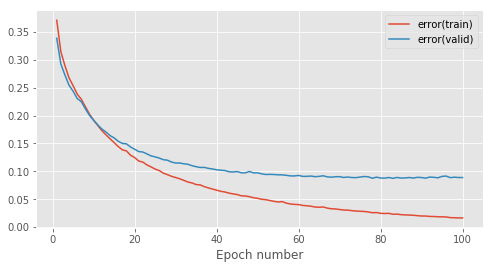

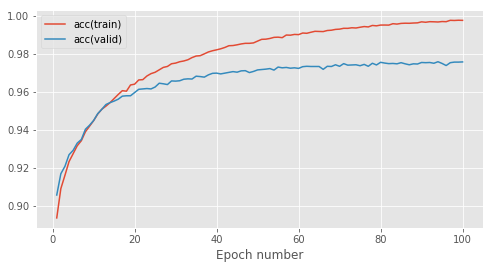

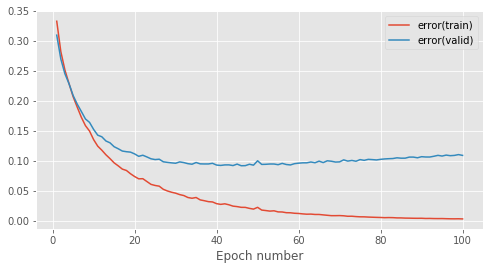

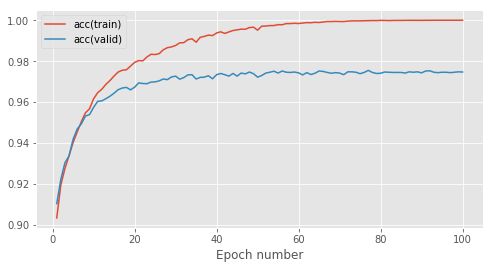

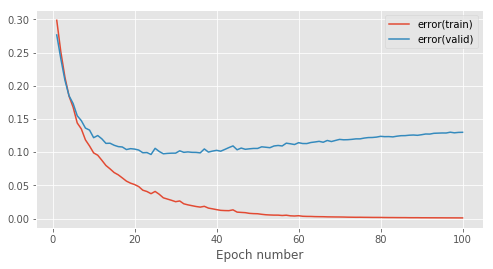

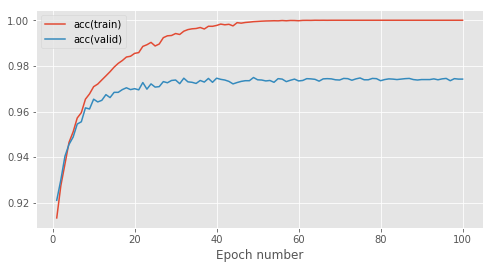

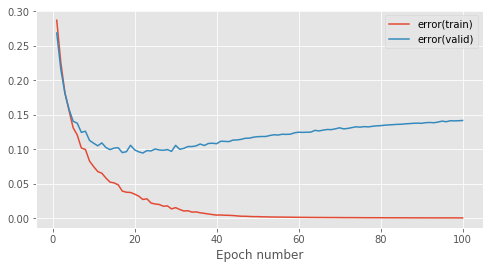

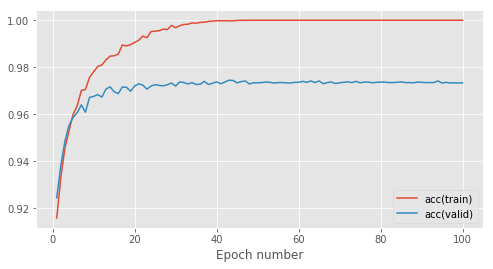

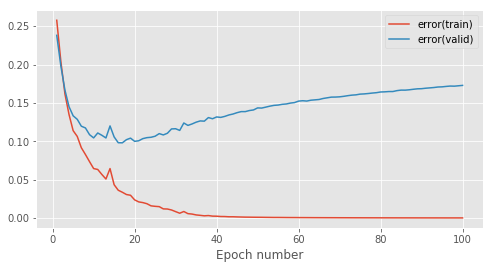

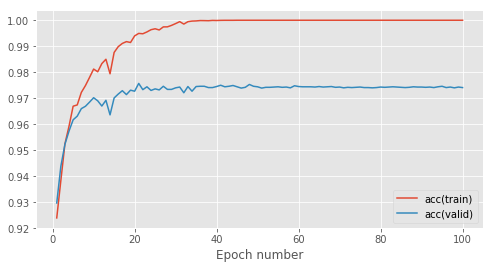

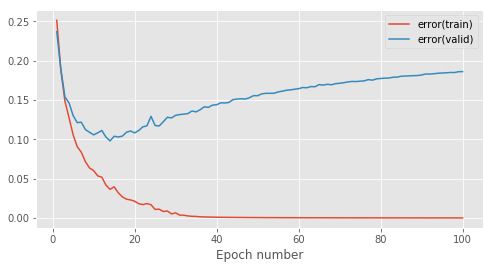

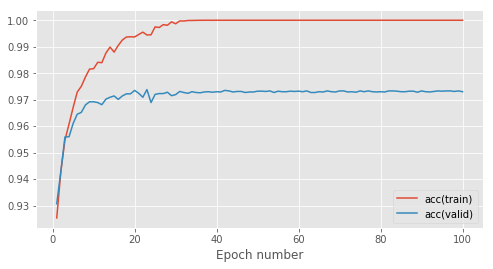

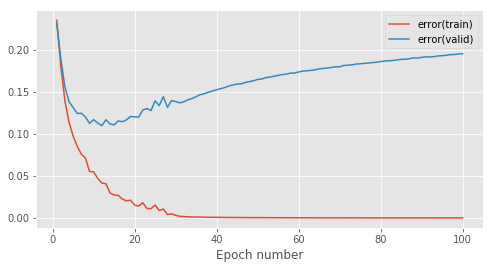

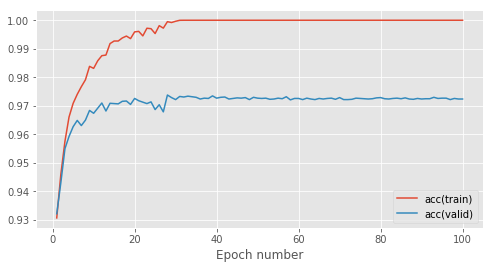

In [24]:
from mlp.learning_rules import MomentumLearningRule

experiment_layers_momentumLR = {}
for i in range(1,8):

    # Always reset the dataset before experiment:
    train_data.reset()
    valid_data.reset()
    test_data.reset()

    # Initialise the weights and biases
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [AffineLayer(input_dim, hidden_dim, weights_init, biases_init)]
    output_layer = [func,
                    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)]
    each_hidden_layer = [func,
                    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)]
    print(model, "{} layers".format(i+1))

    # append additional layers
    model = MultipleLayerModel(input_layer + each_hidden_layer * i + output_layer)
    print(model)
    
    error = CrossEntropySoftmaxError()
    # Use Momentum with Stochastic Gradient Descent. We use the default learning_rate and mom_coeff.
    learning_rule = MomentumLearningRule() 

    experiment_layers_momentumLR[i+1] = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, test_data, num_epochs, stats_interval, notebook=True)

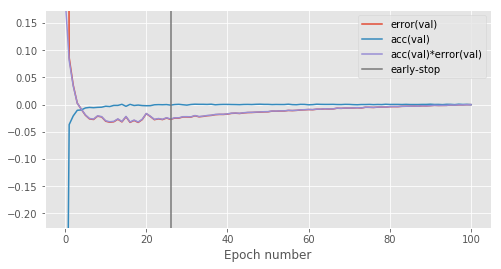

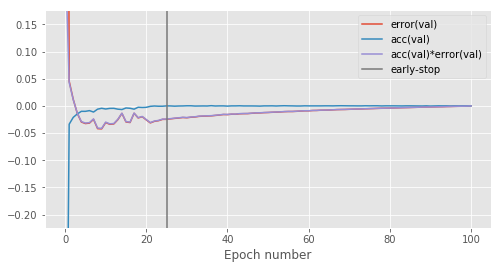

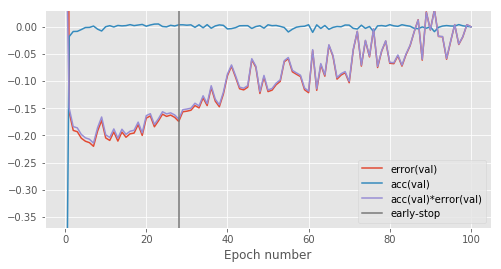

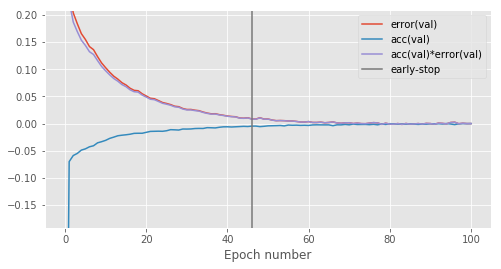

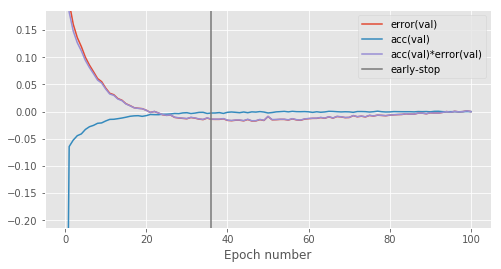

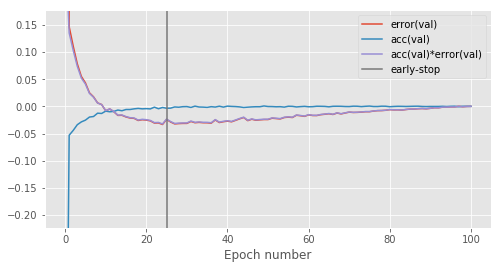

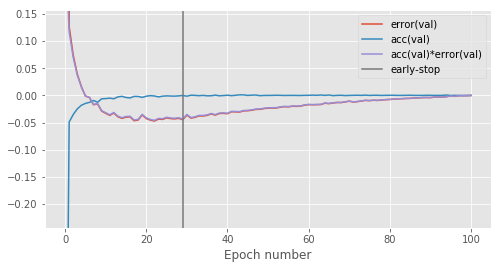

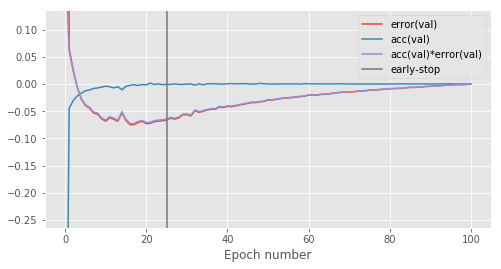

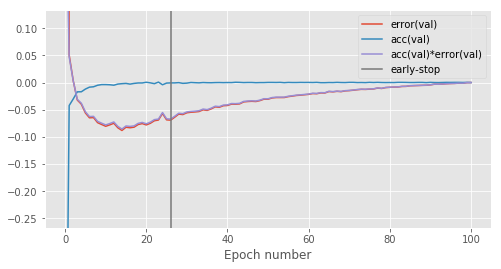

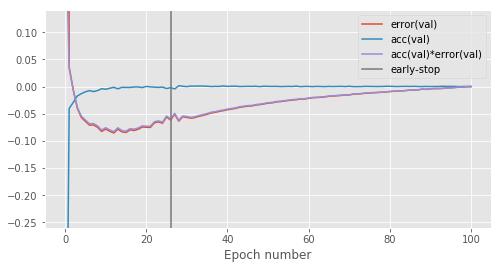

In [78]:
final_valid_err= []
final_valid_acc = []
early_stopping_val_acc = []
early_stopping_val_err = []
test_err = []
test_acc = []
names = []

for (name, output) in experiment_layers_l234.items():
    keys = output[1]
    stats = output[0]
    best_epoch, best_valid_acc, best_test_acc, fig1, ax1 = find_best_epoch(stats, keys)

    # Store the statistics for this model
    final_valid_err.append(stats[-1, keys['error(valid)']])
    final_valid_acc.append(stats[-1, keys['acc(valid)']])
    early_stopping_val_err.append(stats[best_epoch, keys['error(valid)']])
    early_stopping_val_acc.append(stats[best_epoch, keys['acc(valid)']])
    test_err.append(stats[best_epoch, keys['error(test)']])
    test_acc.append(stats[best_epoch, keys['acc(test)']])
    name = "SGD-{}".format(name)
    names.append(name)
    
    # save the figures
    fig = output[3]
    fig.savefig("DNN-{}-err.pdf".format(name), format="pdf")
    fig = output[5]
    fig.savefig("DNN-{}-acc.pdf".format(name),format="pdf")
    fig1.savefig("DNN-{}-best-epoch.pdf".format(name), format="pdf")

for (name, output) in experiment_layers_momentumLR.items():
    keys = output[1]
    stats = output[0]
    best_epoch, best_valid_acc, best_test_acc, fig1, ax1 = find_best_epoch(stats, keys)

    # Store the statistics for this model
    final_valid_err.append(stats[-1, keys['error(valid)']])
    final_valid_acc.append(stats[-1, keys['acc(valid)']])
    early_stopping_val_err.append(stats[best_epoch, keys['error(valid)']])
    early_stopping_val_acc.append(stats[best_epoch, keys['acc(valid)']])
    test_err.append(stats[best_epoch, keys['error(test)']])
    test_acc.append(stats[best_epoch, keys['acc(test)']])
    name = "MSGD-{}".format(int(name)+1)
    names.append(name)
    
    # save the figures
    fig = output[3]
    fig.savefig("DNN-{}-err.pdf".format(name), format="pdf")
    fig = output[5]
    fig.savefig("DNN-{}-acc.pdf".format(name),format="pdf")
    fig1.savefig("DNN-{}-best-epoch.pdf".format(name), format="pdf")

In [81]:
print('|             |              FINAL            |                          EARLY STOPPING                     |')
print('| activation  | error(valid)   | acc(valid)   | error(valid)   |  acc(valid)   |  error(test) |  acc(test)  |')
print('|-------------|----------------|--------------|----------------|---------------|--------------|-------------|')
for i in range(len(names)):
    print('|{0:7}      | {1:.3e}      | {2:.3e}    | {3:.3e}      | {4:.3e}     | {5:.3e}    | {6:.3e}   |'
          .format(names[i], final_valid_err[i], final_valid_acc[i], 
                  early_stopping_val_err[i], early_stopping_val_acc[i],
                  test_err[i], test_acc[i]))
    

|             |              FINAL            |                          EARLY STOPPING                     |
| activation  | error(valid)   | acc(valid)   | error(valid)   |  acc(valid)   |  error(test) |  acc(test)  |
|-------------|----------------|--------------|----------------|---------------|--------------|-------------|
|SGD-2        | 1.201e-01      | 9.774e-01    | 9.286e-02      | 9.765e-01     | 8.645e-02    | 9.770e-01   |
|SGD-3        | 1.308e-01      | 9.809e-01    | 1.061e-01      | 9.809e-01     | 9.950e-02    | 9.793e-01   |
|SGD-4        | 3.152e-01      | 9.718e-01    | 1.411e-01      | 9.754e-01     | 1.349e-01    | 9.748e-01   |
|MSGD-2       | 8.884e-02      | 9.758e-01    | 9.736e-02      | 9.711e-01     | 1.005e-01    | 9.689e-01   |
|MSGD-3       | 1.091e-01      | 9.747e-01    | 9.494e-02      | 9.721e-01     | 8.798e-02    | 9.727e-01   |
|MSGD-4       | 1.299e-01      | 9.742e-01    | 1.057e-01      | 9.707e-01     | 1.044e-01    | 9.670e-01   |
|MSGD-5   

Text(0,0.5,'Validation Accuracy')

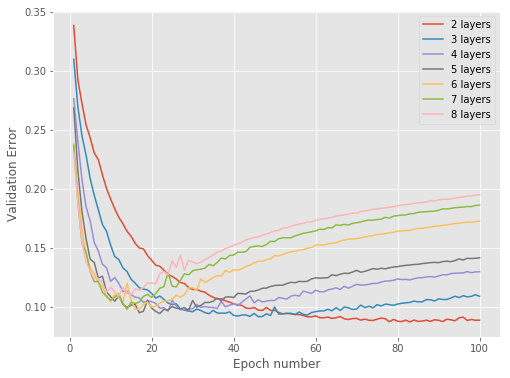

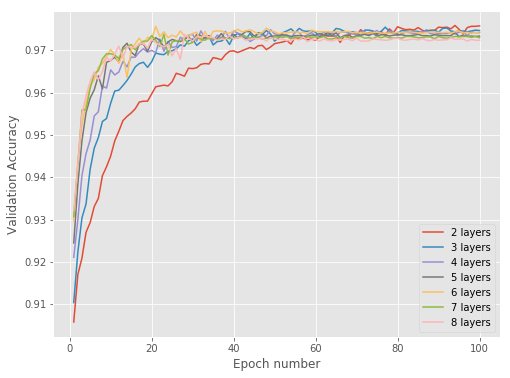

In [189]:
# Combined plot for increasing hidden layer
fig = plt.figure(figsize=(8,6))
ax_1 = fig.add_subplot(111)
fig2=plt.figure(figsize=(8,6))
ax_2 = fig2.add_subplot(111)

for (name,output) in experiment_layers_momentumLR.items():
    keys = output[1]
    stats = output[0]
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
     stats[1:, keys['error(valid)']], label='{} layers'.format(int(name)+1))
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
       stats[1:, keys['acc(valid)']], label='{} layers'.format(int(name)+1))
    
ax_1.legend(loc=0); ax_2.legend(loc=0)
ax_1.set_xlabel('Epoch number');ax_2.set_xlabel('Epoch number');
ax_1.set_ylabel('Validation Error')
ax_2.set_ylabel('Validation Accuracy')

In [191]:
fig.savefig("val_error_MSGD.pdf", format="pdf", bbox_inches="tight")
fig2.savefig("val_acc_MSGD.pdf", format="pdf", bbox_inches="tight")

`Analysis of hypothesis: SGD with momentum guides to minima`:

As seen from the graphs from this experiment, we avoided the problem of missing the shallow minima (fluctuate validation accuracy) as number of layers increases. Comparing both the experiments with and without momentum for SGD, the validation error for SGD with momentum is higher, as the error increases with additional epochs. This could be because the model would have overfit the training data.

Additional work can be done to implement early-stopping to prevent over training. This means that once the validation error reaches a level where future epochs leads to increase to the error, we terminate the training and use the model.

---
## Part 2B: Analysing effects of initialisation for ELU layers

In this section, I analyse the performance of DNN with **4,6,8** hidden layers with 3 different **weights initalisation**. SGD with momentum will be used as the learning rule.


- Fan-in = Number of neurons in the previous layer
- Fan-out = Number of nerons in the following layer

In [25]:
# Set up hyper parameters
input_layer_fan_in = input_dim # 748
input_layer_fan_out = 100
hidden_layer_fan_in = 100
hidden_layer_fan_out = 100
output_layer_fan_in = 100 
output_layer_fan_out = output_dim

### Uniform Initialisation independent of $Fan_{in}$

In [29]:
%%capture _faninexpt
from mlp.initialisers import ConstantInit, UniformInit
from mlp.learning_rules import MomentumLearningRule

experiment_init_indpFanIn = {}

# Only experiment with 2,4,8 hidden layers
for i in [3,5,7]:

    # Always reset the dataset before experiment:
    train_data.reset()
    valid_data.reset()
    test_data.reset()

    # Initialise the weights and biases
    # Calculate the parameters for initialisation
    
    input_weights_init = UniformInit(-1*np.sqrt(3/input_layer_fan_in), np.sqrt(3/input_layer_fan_in),
                                    rng=rng)
    hiddenLayer_weights_init = UniformInit(-1*np.sqrt(3/hidden_layer_fan_in), np.sqrt(3/hidden_layer_fan_in), 
                                           rng=rng)
    output_weights_init = UniformInit(-1*np.sqrt(3/output_layer_fan_in), np.sqrt(3/output_layer_fan_in),
                                     rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [AffineLayer(input_dim, hidden_dim, input_weights_init, biases_init)]
    output_layer = [func,
                    AffineLayer(hidden_dim, output_dim, output_weights_init, biases_init)]
    each_hidden_layer = [func,
                    AffineLayer(hidden_dim, hidden_dim, hiddenLayer_weights_init, biases_init)]


    # append additional layers
    model = MultipleLayerModel(input_layer + each_hidden_layer * i + output_layer)
    print(model)
    
    error = CrossEntropySoftmaxError()
    # Use Momentum with Stochastic Gradient Descent. We use the default learning_rate and mom_coeff.
    learning_rule = MomentumLearningRule() 

    experiment_init_indpFanIn[i] = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, test_data, num_epochs, stats_interval, notebook=True)

    

Epoch 1: 2.3s to complete
    error(train)=3.08e-01, acc(train)=9.08e-01, error(valid)=2.92e-01, acc(valid)=9.16e-01, error(test)=2.99e-01, acc(test)=9.13e-01, params_penalty=0.00e+00
Epoch 2: 2.2s to complete
    error(train)=2.60e-01, acc(train)=9.24e-01, error(valid)=2.50e-01, acc(valid)=9.27e-01, error(test)=2.55e-01, acc(test)=9.26e-01, params_penalty=0.00e+00
Epoch 3: 2.2s to complete
    error(train)=2.19e-01, acc(train)=9.37e-01, error(valid)=2.14e-01, acc(valid)=9.38e-01, error(test)=2.23e-01, acc(test)=9.37e-01, params_penalty=0.00e+00
Epoch 4: 2.2s to complete
    error(train)=1.93e-01, acc(train)=9.45e-01, error(valid)=1.92e-01, acc(valid)=9.45e-01, error(test)=2.01e-01, acc(test)=9.42e-01, params_penalty=0.00e+00
Epoch 5: 2.2s to complete
    error(train)=1.69e-01, acc(train)=9.51e-01, error(valid)=1.74e-01, acc(valid)=9.52e-01, error(test)=1.80e-01, acc(test)=9.47e-01, params_penalty=0.00e+00
Epoch 6: 2.2s to complete
    error(train)=1.50e-01, acc(train)=9.57e-01, error(

Epoch 46: 2.3s to complete
    error(train)=7.58e-03, acc(train)=9.99e-01, error(valid)=9.34e-02, acc(valid)=9.77e-01, error(test)=1.01e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 47: 2.2s to complete
    error(train)=8.06e-03, acc(train)=9.99e-01, error(valid)=9.93e-02, acc(valid)=9.75e-01, error(test)=1.03e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 48: 2.2s to complete
    error(train)=6.81e-03, acc(train)=9.99e-01, error(valid)=9.46e-02, acc(valid)=9.77e-01, error(test)=1.01e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 49: 2.2s to complete
    error(train)=6.32e-03, acc(train)=9.99e-01, error(valid)=9.57e-02, acc(valid)=9.77e-01, error(test)=1.03e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 50: 2.3s to complete
    error(train)=5.98e-03, acc(train)=1.00e+00, error(valid)=9.71e-02, acc(valid)=9.77e-01, error(test)=1.02e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 51: 2.2s to complete
    error(train)=5.75e-03, acc(train)=1.00e+00, 

Epoch 91: 2.5s to complete
    error(train)=1.10e-03, acc(train)=1.00e+00, error(valid)=1.17e-01, acc(valid)=9.77e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 92: 2.6s to complete
    error(train)=1.07e-03, acc(train)=1.00e+00, error(valid)=1.17e-01, acc(valid)=9.77e-01, error(test)=1.24e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 93: 2.5s to complete
    error(train)=1.04e-03, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.76e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 94: 2.5s to complete
    error(train)=1.04e-03, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.76e-01, error(test)=1.24e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 95: 2.6s to complete
    error(train)=9.85e-04, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.77e-01, error(test)=1.25e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 96: 2.6s to complete
    error(train)=9.83e-04, acc(train)=1.00e+00, 

Epoch 36: 2.8s to complete
    error(train)=5.17e-03, acc(train)=9.99e-01, error(valid)=1.27e-01, acc(valid)=9.72e-01, error(test)=1.23e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 37: 2.9s to complete
    error(train)=3.03e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.73e-01, error(test)=1.21e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 38: 2.8s to complete
    error(train)=3.06e-03, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.73e-01, error(test)=1.20e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 39: 2.8s to complete
    error(train)=2.97e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.73e-01, error(test)=1.21e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 40: 2.8s to complete
    error(train)=2.29e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.74e-01, error(test)=1.23e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 41: 2.8s to complete
    error(train)=2.05e-03, acc(train)=1.00e+00, 

Epoch 81: 2.8s to complete
    error(train)=3.67e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.75e-01, error(test)=1.52e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 82: 2.8s to complete
    error(train)=3.64e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.74e-01, error(test)=1.53e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 83: 2.8s to complete
    error(train)=3.50e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.75e-01, error(test)=1.53e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 84: 2.8s to complete
    error(train)=3.43e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.75e-01, error(test)=1.54e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 85: 2.8s to complete
    error(train)=3.37e-04, acc(train)=1.00e+00, error(valid)=1.60e-01, acc(valid)=9.75e-01, error(test)=1.54e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 86: 2.8s to complete
    error(train)=3.30e-04, acc(train)=1.00e+00, 

Epoch 26: 3.4s to complete
    error(train)=1.05e-02, acc(train)=9.97e-01, error(valid)=1.27e-01, acc(valid)=9.73e-01, error(test)=1.19e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 27: 3.4s to complete
    error(train)=1.05e-02, acc(train)=9.97e-01, error(valid)=1.30e-01, acc(valid)=9.73e-01, error(test)=1.22e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 28: 3.4s to complete
    error(train)=1.42e-02, acc(train)=9.96e-01, error(valid)=1.42e-01, acc(valid)=9.69e-01, error(test)=1.34e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 29: 3.4s to complete
    error(train)=1.05e-02, acc(train)=9.96e-01, error(valid)=1.31e-01, acc(valid)=9.72e-01, error(test)=1.31e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 30: 3.4s to complete
    error(train)=1.05e-02, acc(train)=9.97e-01, error(valid)=1.35e-01, acc(valid)=9.73e-01, error(test)=1.37e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 31: 3.4s to complete
    error(train)=1.20e-02, acc(train)=9.96e-01, 

Epoch 71: 3.4s to complete
    error(train)=1.54e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.74e-01, error(test)=1.69e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 72: 3.4s to complete
    error(train)=1.50e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.74e-01, error(test)=1.69e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 73: 3.4s to complete
    error(train)=1.46e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.74e-01, error(test)=1.69e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 74: 3.7s to complete
    error(train)=1.42e-04, acc(train)=1.00e+00, error(valid)=1.79e-01, acc(valid)=9.74e-01, error(test)=1.71e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 75: 3.4s to complete
    error(train)=1.39e-04, acc(train)=1.00e+00, error(valid)=1.80e-01, acc(valid)=9.74e-01, error(test)=1.71e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 76: 3.4s to complete
    error(train)=1.35e-04, acc(train)=1.00e+00, 

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULay

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

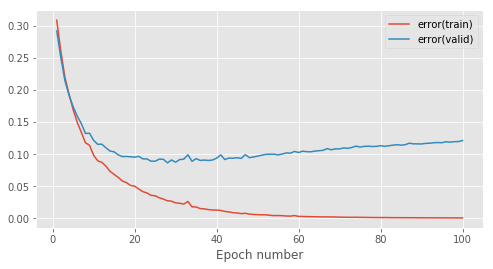

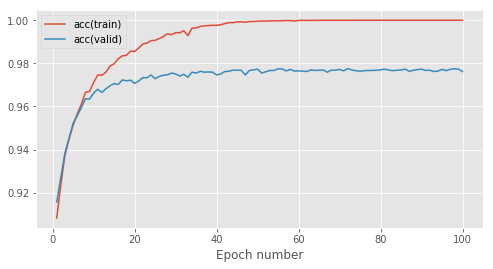

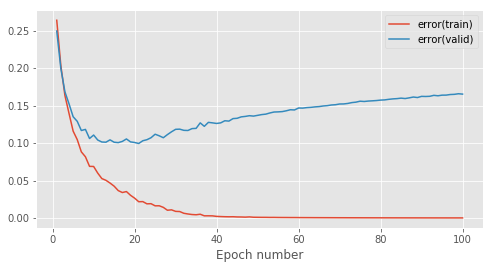

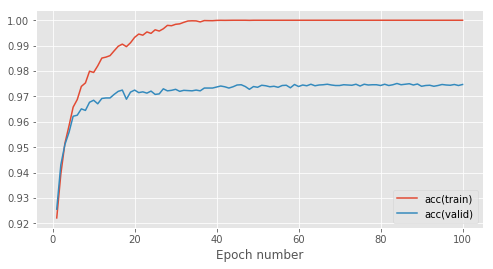

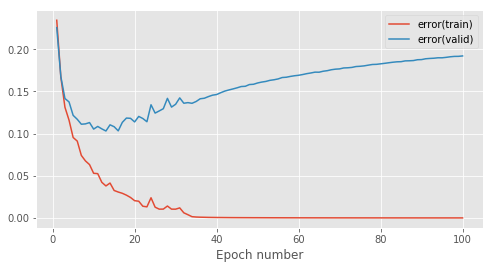

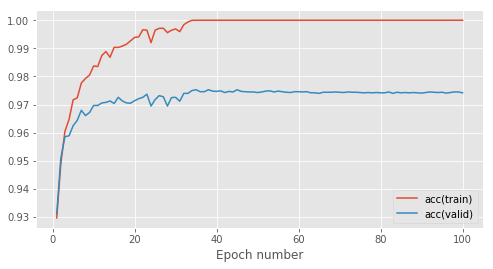

In [83]:
_faninexpt()

### Initialisation with weights independent of $Fan_{out}$

In [30]:
%%capture _fanoutexpt
from mlp.initialisers import ConstantInit, UniformInit

experiment_init_indpFanOut = {}

for i in [3,5,7]:

    # Always reset the dataset before experiment:
    train_data.reset()
    valid_data.reset()
    test_data.reset()

    # Initialise the weights and biases
    # Calculate the parameters for initialisation
    
    input_weights_init = UniformInit(-1*np.sqrt(3/hidden_layer_fan_in), 
                                     np.sqrt(3/hidden_layer_fan_in),
                                     rng=rng)
    output_weights_init = UniformInit(-1*np.sqrt(3/output_layer_fan_out), 
                                      np.sqrt(3/output_layer_fan_out),
                                      rng=rng)
    hiddenLayer_weights_init = UniformInit(-1*np.sqrt(3/hidden_layer_fan_out), 
                                           np.sqrt(3/hidden_layer_fan_out), 
                                           rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [AffineLayer(input_dim, hidden_dim, input_weights_init, biases_init)]
    output_layer = [func,
                    AffineLayer(hidden_dim, output_dim, output_weights_init, biases_init)]
    each_hidden_layer = [func,
                        AffineLayer(hidden_dim, hidden_dim, hiddenLayer_weights_init, biases_init)]


    # append additional layers
    model = MultipleLayerModel(input_layer + each_hidden_layer * i + output_layer)
    print(model)
    
    error = CrossEntropySoftmaxError()
    # Use Momentum with Stochastic Gradient Descent. We use the default learning_rate and mom_coeff.
    learning_rule = MomentumLearningRule() 

    experiment_init_indpFanOut[i] = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, test_data, num_epochs, stats_interval, notebook=True)

    

Epoch 1: 2.2s to complete
    error(train)=2.88e-01, acc(train)=9.14e-01, error(valid)=2.74e-01, acc(valid)=9.19e-01, error(test)=2.90e-01, acc(test)=9.14e-01, params_penalty=0.00e+00
Epoch 2: 2.2s to complete
    error(train)=2.18e-01, acc(train)=9.35e-01, error(valid)=2.16e-01, acc(valid)=9.37e-01, error(test)=2.27e-01, acc(test)=9.30e-01, params_penalty=0.00e+00
Epoch 3: 2.2s to complete
    error(train)=1.73e-01, acc(train)=9.49e-01, error(valid)=1.78e-01, acc(valid)=9.48e-01, error(test)=1.86e-01, acc(test)=9.44e-01, params_penalty=0.00e+00
Epoch 4: 2.2s to complete
    error(train)=1.49e-01, acc(train)=9.54e-01, error(valid)=1.62e-01, acc(valid)=9.53e-01, error(test)=1.71e-01, acc(test)=9.49e-01, params_penalty=0.00e+00
Epoch 5: 2.2s to complete
    error(train)=1.27e-01, acc(train)=9.62e-01, error(valid)=1.45e-01, acc(valid)=9.57e-01, error(test)=1.52e-01, acc(test)=9.55e-01, params_penalty=0.00e+00
Epoch 6: 2.2s to complete
    error(train)=1.19e-01, acc(train)=9.64e-01, error(

Epoch 46: 2.2s to complete
    error(train)=5.20e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.71e-01, error(test)=1.18e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 47: 2.2s to complete
    error(train)=4.87e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.71e-01, error(test)=1.17e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 48: 2.2s to complete
    error(train)=4.87e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.71e-01, error(test)=1.18e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 49: 2.2s to complete
    error(train)=4.44e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.72e-01, error(test)=1.19e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 50: 2.2s to complete
    error(train)=4.14e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.72e-01, error(test)=1.21e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 51: 2.2s to complete
    error(train)=4.67e-03, acc(train)=1.00e+00, 

Epoch 91: 2.2s to complete
    error(train)=1.07e-03, acc(train)=1.00e+00, error(valid)=1.48e-01, acc(valid)=9.72e-01, error(test)=1.40e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 92: 2.2s to complete
    error(train)=1.04e-03, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.72e-01, error(test)=1.40e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 93: 2.2s to complete
    error(train)=1.02e-03, acc(train)=1.00e+00, error(valid)=1.48e-01, acc(valid)=9.72e-01, error(test)=1.39e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 94: 2.2s to complete
    error(train)=1.00e-03, acc(train)=1.00e+00, error(valid)=1.50e-01, acc(valid)=9.72e-01, error(test)=1.41e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 95: 2.2s to complete
    error(train)=9.88e-04, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.72e-01, error(test)=1.41e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 96: 2.2s to complete
    error(train)=9.63e-04, acc(train)=1.00e+00, 

Epoch 36: 2.8s to complete
    error(train)=2.56e-03, acc(train)=1.00e+00, error(valid)=1.47e-01, acc(valid)=9.69e-01, error(test)=1.37e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 37: 2.8s to complete
    error(train)=2.47e-03, acc(train)=1.00e+00, error(valid)=1.48e-01, acc(valid)=9.68e-01, error(test)=1.38e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 38: 2.8s to complete
    error(train)=2.22e-03, acc(train)=1.00e+00, error(valid)=1.48e-01, acc(valid)=9.69e-01, error(test)=1.38e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 39: 2.8s to complete
    error(train)=2.02e-03, acc(train)=1.00e+00, error(valid)=1.50e-01, acc(valid)=9.69e-01, error(test)=1.38e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 40: 2.8s to complete
    error(train)=1.81e-03, acc(train)=1.00e+00, error(valid)=1.51e-01, acc(valid)=9.69e-01, error(test)=1.39e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 41: 2.8s to complete
    error(train)=1.81e-03, acc(train)=1.00e+00, 

Epoch 81: 2.8s to complete
    error(train)=4.37e-04, acc(train)=1.00e+00, error(valid)=1.82e-01, acc(valid)=9.69e-01, error(test)=1.65e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 82: 2.8s to complete
    error(train)=4.25e-04, acc(train)=1.00e+00, error(valid)=1.82e-01, acc(valid)=9.70e-01, error(test)=1.66e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 83: 2.8s to complete
    error(train)=4.17e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.69e-01, error(test)=1.66e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 84: 2.8s to complete
    error(train)=4.07e-04, acc(train)=1.00e+00, error(valid)=1.84e-01, acc(valid)=9.70e-01, error(test)=1.67e-01, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 85: 2.8s to complete
    error(train)=3.99e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.69e-01, error(test)=1.67e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 86: 2.8s to complete
    error(train)=3.94e-04, acc(train)=1.00e+00, 

Epoch 26: 3.4s to complete
    error(train)=4.98e-03, acc(train)=9.99e-01, error(valid)=1.49e-01, acc(valid)=9.69e-01, error(test)=1.48e-01, acc(test)=9.68e-01, params_penalty=0.00e+00
Epoch 27: 3.4s to complete
    error(train)=4.11e-03, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.68e-01, error(test)=1.47e-01, acc(test)=9.68e-01, params_penalty=0.00e+00
Epoch 28: 3.4s to complete
    error(train)=2.91e-03, acc(train)=1.00e+00, error(valid)=1.55e-01, acc(valid)=9.69e-01, error(test)=1.49e-01, acc(test)=9.68e-01, params_penalty=0.00e+00
Epoch 29: 3.4s to complete
    error(train)=2.65e-03, acc(train)=1.00e+00, error(valid)=1.56e-01, acc(valid)=9.69e-01, error(test)=1.49e-01, acc(test)=9.68e-01, params_penalty=0.00e+00
Epoch 30: 3.4s to complete
    error(train)=1.99e-03, acc(train)=1.00e+00, error(valid)=1.56e-01, acc(valid)=9.69e-01, error(test)=1.51e-01, acc(test)=9.68e-01, params_penalty=0.00e+00
Epoch 31: 3.5s to complete
    error(train)=1.74e-03, acc(train)=1.00e+00, 

Epoch 71: 3.4s to complete
    error(train)=3.04e-04, acc(train)=1.00e+00, error(valid)=1.98e-01, acc(valid)=9.69e-01, error(test)=1.88e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 72: 3.4s to complete
    error(train)=2.98e-04, acc(train)=1.00e+00, error(valid)=1.98e-01, acc(valid)=9.69e-01, error(test)=1.89e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 73: 3.4s to complete
    error(train)=2.89e-04, acc(train)=1.00e+00, error(valid)=1.99e-01, acc(valid)=9.69e-01, error(test)=1.90e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 74: 3.4s to complete
    error(train)=2.84e-04, acc(train)=1.00e+00, error(valid)=2.00e-01, acc(valid)=9.69e-01, error(test)=1.90e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 75: 3.4s to complete
    error(train)=2.78e-04, acc(train)=1.00e+00, error(valid)=2.00e-01, acc(valid)=9.68e-01, error(test)=1.90e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 76: 3.4s to complete
    error(train)=2.71e-04, acc(train)=1.00e+00, 

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULay

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

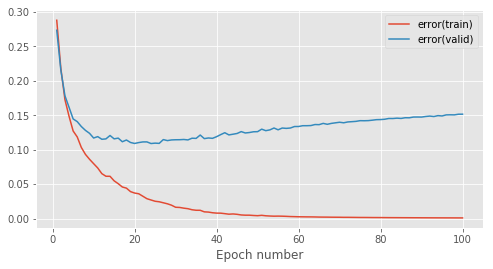

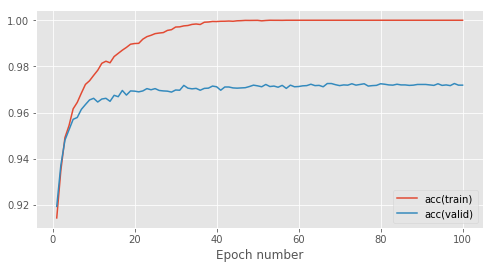

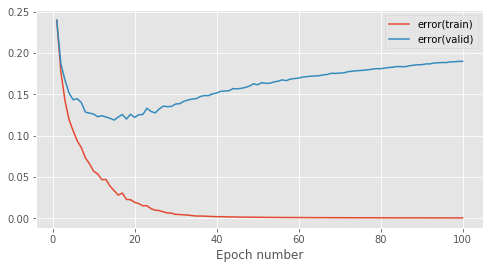

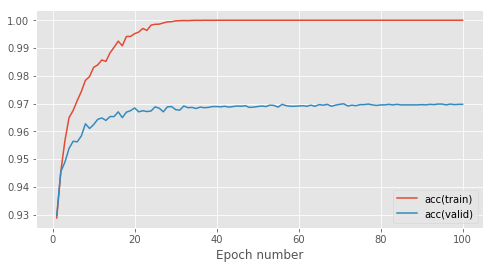

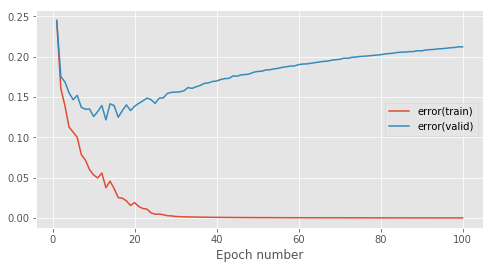

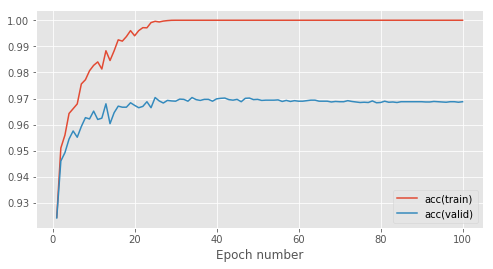

In [84]:
_fanoutexpt()

### Glorot Uniform Initialisation

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 2.3s to complete
    error(train)=3.00e-01, acc(train)=9.14e-01, error(valid)=2.82e-01, acc(valid)=9.18e-01, error(test)=2.89e-01, acc(test)=9.18e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 2.3s to complete
    error(train)=2.48e-01, acc(train)=9.26e-01, error(valid)=2.37e-01, acc(valid)=9.32e-01, error(test)=2.50e-01, acc(test)=9.28e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 2.2s to complete
    error(train)=2.13e-01, acc(train)=9.38e-01, error(valid)=2.11e-01, acc(valid)=9.41e-01, error(test)=2.20e-01, acc(test)=9.36e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 2.2s to complete
    error(train)=1.87e-01, acc(train)=9.46e-01, error(valid)=1.86e-01, acc(valid)=9.48e-01, error(test)=1.93e-01, acc(test)=9.41e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 2.3s to complete
    error(train)=1.57e-01, acc(train)=9.53e-01, error(valid)=1.65e-01, acc(valid)=9.54e-01, error(test)=1.72e-01, acc(test)=9.49e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 2.2s to complete
    error(train)=1.45e-01, acc(train)=9.57e-01, error(valid)=1.57e-01, acc(valid)=9.57e-01, error(test)=1.59e-01, acc(test)=9.52e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 2.2s to complete
    error(train)=1.29e-01, acc(train)=9.61e-01, error(valid)=1.46e-01, acc(valid)=9.58e-01, error(test)=1.45e-01, acc(test)=9.55e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 2.2s to complete
    error(train)=1.18e-01, acc(train)=9.65e-01, error(valid)=1.36e-01, acc(valid)=9.61e-01, error(test)=1.37e-01, acc(test)=9.58e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 2.3s to complete
    error(train)=1.13e-01, acc(train)=9.66e-01, error(valid)=1.34e-01, acc(valid)=9.62e-01, error(test)=1.37e-01, acc(test)=9.57e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 2.2s to complete
    error(train)=9.93e-02, acc(train)=9.71e-01, error(valid)=1.26e-01, acc(valid)=9.65e-01, error(test)=1.23e-01, acc(test)=9.62e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 2.2s to complete
    error(train)=9.17e-02, acc(train)=9.73e-01, error(valid)=1.21e-01, acc(valid)=9.66e-01, error(test)=1.21e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 2.7s to complete
    error(train)=8.96e-02, acc(train)=9.74e-01, error(valid)=1.19e-01, acc(valid)=9.66e-01, error(test)=1.16e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 2.3s to complete
    error(train)=7.98e-02, acc(train)=9.76e-01, error(valid)=1.12e-01, acc(valid)=9.67e-01, error(test)=1.11e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 2.2s to complete
    error(train)=7.53e-02, acc(train)=9.78e-01, error(valid)=1.13e-01, acc(valid)=9.68e-01, error(test)=1.12e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 2.2s to complete
    error(train)=7.15e-02, acc(train)=9.79e-01, error(valid)=1.08e-01, acc(valid)=9.68e-01, error(test)=1.06e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 2.3s to complete
    error(train)=6.67e-02, acc(train)=9.81e-01, error(valid)=1.08e-01, acc(valid)=9.68e-01, error(test)=1.06e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 2.2s to complete
    error(train)=6.00e-02, acc(train)=9.83e-01, error(valid)=1.03e-01, acc(valid)=9.70e-01, error(test)=1.04e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 2.3s to complete
    error(train)=5.64e-02, acc(train)=9.84e-01, error(valid)=1.03e-01, acc(valid)=9.70e-01, error(test)=1.02e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 2.2s to complete
    error(train)=5.21e-02, acc(train)=9.85e-01, error(valid)=9.89e-02, acc(valid)=9.70e-01, error(test)=9.77e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 2.3s to complete
    error(train)=5.02e-02, acc(train)=9.86e-01, error(valid)=1.01e-01, acc(valid)=9.71e-01, error(test)=9.83e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 2.2s to complete
    error(train)=4.65e-02, acc(train)=9.87e-01, error(valid)=9.86e-02, acc(valid)=9.72e-01, error(test)=9.54e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 2.2s to complete
    error(train)=4.56e-02, acc(train)=9.87e-01, error(valid)=9.76e-02, acc(valid)=9.71e-01, error(test)=9.64e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 2.2s to complete
    error(train)=4.23e-02, acc(train)=9.88e-01, error(valid)=9.98e-02, acc(valid)=9.71e-01, error(test)=9.54e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 2.2s to complete
    error(train)=3.87e-02, acc(train)=9.90e-01, error(valid)=9.83e-02, acc(valid)=9.72e-01, error(test)=9.50e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 2.2s to complete
    error(train)=3.76e-02, acc(train)=9.90e-01, error(valid)=9.93e-02, acc(valid)=9.72e-01, error(test)=9.46e-02, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 2.3s to complete
    error(train)=3.28e-02, acc(train)=9.92e-01, error(valid)=9.60e-02, acc(valid)=9.74e-01, error(test)=9.41e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 2.3s to complete
    error(train)=3.21e-02, acc(train)=9.92e-01, error(valid)=9.83e-02, acc(valid)=9.73e-01, error(test)=9.20e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 2.2s to complete
    error(train)=3.00e-02, acc(train)=9.93e-01, error(valid)=9.72e-02, acc(valid)=9.73e-01, error(test)=9.65e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 2.2s to complete
    error(train)=2.92e-02, acc(train)=9.93e-01, error(valid)=9.75e-02, acc(valid)=9.73e-01, error(test)=9.74e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 2.3s to complete
    error(train)=2.92e-02, acc(train)=9.93e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01, error(test)=9.43e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 2.2s to complete
    error(train)=2.46e-02, acc(train)=9.95e-01, error(valid)=9.60e-02, acc(valid)=9.73e-01, error(test)=9.11e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 2.2s to complete
    error(train)=2.36e-02, acc(train)=9.95e-01, error(valid)=9.85e-02, acc(valid)=9.72e-01, error(test)=9.41e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 2.3s to complete
    error(train)=2.30e-02, acc(train)=9.95e-01, error(valid)=9.75e-02, acc(valid)=9.74e-01, error(test)=9.51e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 2.3s to complete
    error(train)=1.94e-02, acc(train)=9.96e-01, error(valid)=9.78e-02, acc(valid)=9.73e-01, error(test)=9.20e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 2.3s to complete
    error(train)=1.98e-02, acc(train)=9.96e-01, error(valid)=1.01e-01, acc(valid)=9.74e-01, error(test)=9.35e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 2.2s to complete
    error(train)=1.80e-02, acc(train)=9.97e-01, error(valid)=9.90e-02, acc(valid)=9.73e-01, error(test)=9.51e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 2.3s to complete
    error(train)=1.63e-02, acc(train)=9.97e-01, error(valid)=9.77e-02, acc(valid)=9.74e-01, error(test)=9.38e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 2.2s to complete
    error(train)=1.70e-02, acc(train)=9.96e-01, error(valid)=1.04e-01, acc(valid)=9.73e-01, error(test)=9.89e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 2.2s to complete
    error(train)=1.47e-02, acc(train)=9.98e-01, error(valid)=1.00e-01, acc(valid)=9.75e-01, error(test)=9.86e-02, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 2.3s to complete
    error(train)=1.41e-02, acc(train)=9.98e-01, error(valid)=1.00e-01, acc(valid)=9.75e-01, error(test)=9.62e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 2.2s to complete
    error(train)=1.27e-02, acc(train)=9.98e-01, error(valid)=1.02e-01, acc(valid)=9.74e-01, error(test)=9.75e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 2.2s to complete
    error(train)=1.20e-02, acc(train)=9.98e-01, error(valid)=1.02e-01, acc(valid)=9.74e-01, error(test)=9.71e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 2.3s to complete
    error(train)=1.08e-02, acc(train)=9.99e-01, error(valid)=1.02e-01, acc(valid)=9.74e-01, error(test)=9.76e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 2.3s to complete
    error(train)=1.28e-02, acc(train)=9.98e-01, error(valid)=1.05e-01, acc(valid)=9.73e-01, error(test)=1.01e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 2.2s to complete
    error(train)=1.00e-02, acc(train)=9.99e-01, error(valid)=1.06e-01, acc(valid)=9.74e-01, error(test)=1.02e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 2.2s to complete
    error(train)=9.27e-03, acc(train)=9.99e-01, error(valid)=1.07e-01, acc(valid)=9.75e-01, error(test)=1.02e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 2.2s to complete
    error(train)=9.37e-03, acc(train)=9.99e-01, error(valid)=1.09e-01, acc(valid)=9.72e-01, error(test)=1.02e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 2.2s to complete
    error(train)=8.46e-03, acc(train)=9.99e-01, error(valid)=1.09e-01, acc(valid)=9.73e-01, error(test)=1.04e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 2.2s to complete
    error(train)=7.40e-03, acc(train)=9.99e-01, error(valid)=1.08e-01, acc(valid)=9.73e-01, error(test)=1.03e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 2.3s to complete
    error(train)=6.79e-03, acc(train)=1.00e+00, error(valid)=1.07e-01, acc(valid)=9.74e-01, error(test)=1.01e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 2.3s to complete
    error(train)=6.91e-03, acc(train)=9.99e-01, error(valid)=1.11e-01, acc(valid)=9.74e-01, error(test)=1.05e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 2.3s to complete
    error(train)=5.87e-03, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.74e-01, error(test)=1.03e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 2.2s to complete
    error(train)=5.62e-03, acc(train)=1.00e+00, error(valid)=1.10e-01, acc(valid)=9.75e-01, error(test)=1.02e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 2.3s to complete
    error(train)=5.45e-03, acc(train)=1.00e+00, error(valid)=1.11e-01, acc(valid)=9.74e-01, error(test)=1.06e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 2.2s to complete
    error(train)=5.40e-03, acc(train)=1.00e+00, error(valid)=1.12e-01, acc(valid)=9.74e-01, error(test)=1.06e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 2.2s to complete
    error(train)=4.82e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.75e-01, error(test)=1.06e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 2.2s to complete
    error(train)=4.43e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.75e-01, error(test)=1.07e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 2.3s to complete
    error(train)=4.17e-03, acc(train)=1.00e+00, error(valid)=1.14e-01, acc(valid)=9.74e-01, error(test)=1.07e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 2.2s to complete
    error(train)=4.13e-03, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.76e-01, error(test)=1.08e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 2.3s to complete
    error(train)=3.80e-03, acc(train)=1.00e+00, error(valid)=1.14e-01, acc(valid)=9.75e-01, error(test)=1.08e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 2.3s to complete
    error(train)=3.76e-03, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.74e-01, error(test)=1.08e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 2.2s to complete
    error(train)=3.53e-03, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.75e-01, error(test)=1.10e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 2.2s to complete
    error(train)=3.31e-03, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.75e-01, error(test)=1.11e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 2.3s to complete
    error(train)=3.40e-03, acc(train)=1.00e+00, error(valid)=1.17e-01, acc(valid)=9.75e-01, error(test)=1.10e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 2.2s to complete
    error(train)=2.85e-03, acc(train)=1.00e+00, error(valid)=1.17e-01, acc(valid)=9.75e-01, error(test)=1.10e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 2.2s to complete
    error(train)=2.83e-03, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.75e-01, error(test)=1.12e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 2.2s to complete
    error(train)=2.69e-03, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.74e-01, error(test)=1.11e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 2.2s to complete
    error(train)=2.57e-03, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.74e-01, error(test)=1.13e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 2.2s to complete
    error(train)=2.44e-03, acc(train)=1.00e+00, error(valid)=1.21e-01, acc(valid)=9.75e-01, error(test)=1.13e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 2.2s to complete
    error(train)=2.38e-03, acc(train)=1.00e+00, error(valid)=1.21e-01, acc(valid)=9.75e-01, error(test)=1.13e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 2.2s to complete
    error(train)=2.31e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.75e-01, error(test)=1.12e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 2.3s to complete
    error(train)=2.16e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.74e-01, error(test)=1.14e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 2.2s to complete
    error(train)=2.07e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.75e-01, error(test)=1.14e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 2.2s to complete
    error(train)=1.98e-03, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.75e-01, error(test)=1.14e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 2.3s to complete
    error(train)=1.98e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.74e-01, error(test)=1.16e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 2.2s to complete
    error(train)=1.88e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.74e-01, error(test)=1.16e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 2.3s to complete
    error(train)=1.79e-03, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.74e-01, error(test)=1.16e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 2.3s to complete
    error(train)=1.71e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.75e-01, error(test)=1.16e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 2.2s to complete
    error(train)=1.68e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.75e-01, error(test)=1.17e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 2.2s to complete
    error(train)=1.67e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.17e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 2.2s to complete
    error(train)=1.62e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.75e-01, error(test)=1.18e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 2.3s to complete
    error(train)=1.61e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.75e-01, error(test)=1.17e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 2.2s to complete
    error(train)=1.64e-03, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.74e-01, error(test)=1.19e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 2.2s to complete
    error(train)=1.43e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.75e-01, error(test)=1.18e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 2.2s to complete
    error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.74e-01, error(test)=1.19e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 2.2s to complete
    error(train)=1.38e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.75e-01, error(test)=1.19e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 2.2s to complete
    error(train)=1.46e-03, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.75e-01, error(test)=1.19e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 2.3s to complete
    error(train)=1.29e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.75e-01, error(test)=1.20e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 2.3s to complete
    error(train)=1.27e-03, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.75e-01, error(test)=1.21e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 2.2s to complete
    error(train)=1.28e-03, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.75e-01, error(test)=1.21e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 2.8s to complete
    error(train)=1.21e-03, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.75e-01, error(test)=1.22e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 2.2s to complete
    error(train)=1.18e-03, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.75e-01, error(test)=1.22e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 2.2s to complete
    error(train)=1.17e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.75e-01, error(test)=1.23e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 2.3s to complete
    error(train)=1.12e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.74e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 2.2s to complete
    error(train)=1.08e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.75e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 2.3s to complete
    error(train)=1.07e-03, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.75e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 2.2s to complete
    error(train)=1.05e-03, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.75e-01, error(test)=1.25e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 2.2s to complete
    error(train)=1.03e-03, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.75e-01, error(test)=1.23e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 2.3s to complete
    error(train)=1.04e-03, acc(train)=1.00e+00, error(valid)=1.34e-01, acc(valid)=9.75e-01, error(test)=1.25e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 2.2s to complete
    error(train)=9.90e-04, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.75e-01, error(test)=1.23e-01, acc(test)=9.73e-01, params_penalty=0.00e+00



MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 2.8s to complete
    error(train)=2.65e-01, acc(train)=9.22e-01, error(valid)=2.52e-01, acc(valid)=9.29e-01, error(test)=2.61e-01, acc(test)=9.24e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 2.8s to complete
    error(train)=2.03e-01, acc(train)=9.40e-01, error(valid)=1.95e-01, acc(valid)=9.45e-01, error(test)=2.10e-01, acc(test)=9.37e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 2.8s to complete
    error(train)=1.64e-01, acc(train)=9.51e-01, error(valid)=1.70e-01, acc(valid)=9.52e-01, error(test)=1.78e-01, acc(test)=9.46e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 2.8s to complete
    error(train)=1.34e-01, acc(train)=9.59e-01, error(valid)=1.47e-01, acc(valid)=9.59e-01, error(test)=1.52e-01, acc(test)=9.54e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 2.8s to complete
    error(train)=1.27e-01, acc(train)=9.61e-01, error(valid)=1.43e-01, acc(valid)=9.61e-01, error(test)=1.56e-01, acc(test)=9.52e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 2.8s to complete
    error(train)=1.01e-01, acc(train)=9.70e-01, error(valid)=1.21e-01, acc(valid)=9.66e-01, error(test)=1.29e-01, acc(test)=9.60e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 2.8s to complete
    error(train)=9.16e-02, acc(train)=9.73e-01, error(valid)=1.18e-01, acc(valid)=9.65e-01, error(test)=1.27e-01, acc(test)=9.60e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 2.8s to complete
    error(train)=8.05e-02, acc(train)=9.76e-01, error(valid)=1.16e-01, acc(valid)=9.65e-01, error(test)=1.16e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 2.8s to complete
    error(train)=7.75e-02, acc(train)=9.77e-01, error(valid)=1.14e-01, acc(valid)=9.67e-01, error(test)=1.18e-01, acc(test)=9.63e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 2.8s to complete
    error(train)=6.49e-02, acc(train)=9.80e-01, error(valid)=1.08e-01, acc(valid)=9.68e-01, error(test)=1.11e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 2.8s to complete
    error(train)=6.23e-02, acc(train)=9.81e-01, error(valid)=1.10e-01, acc(valid)=9.68e-01, error(test)=1.11e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 2.8s to complete
    error(train)=5.67e-02, acc(train)=9.82e-01, error(valid)=1.04e-01, acc(valid)=9.69e-01, error(test)=1.09e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 2.8s to complete
    error(train)=5.01e-02, acc(train)=9.86e-01, error(valid)=1.01e-01, acc(valid)=9.72e-01, error(test)=1.04e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 2.8s to complete
    error(train)=4.55e-02, acc(train)=9.87e-01, error(valid)=1.05e-01, acc(valid)=9.69e-01, error(test)=1.11e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 2.8s to complete
    error(train)=4.33e-02, acc(train)=9.87e-01, error(valid)=1.04e-01, acc(valid)=9.72e-01, error(test)=1.09e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 2.8s to complete
    error(train)=3.44e-02, acc(train)=9.91e-01, error(valid)=9.68e-02, acc(valid)=9.73e-01, error(test)=1.03e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 2.8s to complete
    error(train)=3.34e-02, acc(train)=9.91e-01, error(valid)=1.00e-01, acc(valid)=9.72e-01, error(test)=1.03e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 2.8s to complete
    error(train)=2.88e-02, acc(train)=9.93e-01, error(valid)=9.78e-02, acc(valid)=9.72e-01, error(test)=1.02e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 2.8s to complete
    error(train)=2.97e-02, acc(train)=9.91e-01, error(valid)=1.05e-01, acc(valid)=9.72e-01, error(test)=1.05e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 2.8s to complete
    error(train)=3.13e-02, acc(train)=9.91e-01, error(valid)=1.09e-01, acc(valid)=9.71e-01, error(test)=1.09e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 2.8s to complete
    error(train)=2.50e-02, acc(train)=9.93e-01, error(valid)=1.04e-01, acc(valid)=9.72e-01, error(test)=1.12e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 2.8s to complete
    error(train)=1.99e-02, acc(train)=9.95e-01, error(valid)=1.01e-01, acc(valid)=9.74e-01, error(test)=1.08e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 2.9s to complete
    error(train)=2.23e-02, acc(train)=9.94e-01, error(valid)=1.09e-01, acc(valid)=9.71e-01, error(test)=1.10e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 3.1s to complete
    error(train)=1.66e-02, acc(train)=9.96e-01, error(valid)=1.07e-01, acc(valid)=9.74e-01, error(test)=1.10e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 2.8s to complete
    error(train)=1.43e-02, acc(train)=9.97e-01, error(valid)=1.06e-01, acc(valid)=9.73e-01, error(test)=1.09e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 2.8s to complete
    error(train)=1.21e-02, acc(train)=9.98e-01, error(valid)=1.07e-01, acc(valid)=9.73e-01, error(test)=1.12e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 2.8s to complete
    error(train)=1.26e-02, acc(train)=9.97e-01, error(valid)=1.08e-01, acc(valid)=9.73e-01, error(test)=1.13e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 2.8s to complete
    error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=1.18e-01, acc(valid)=9.72e-01, error(test)=1.21e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 2.8s to complete
    error(train)=1.17e-02, acc(train)=9.97e-01, error(valid)=1.18e-01, acc(valid)=9.73e-01, error(test)=1.21e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 2.8s to complete
    error(train)=8.15e-03, acc(train)=9.99e-01, error(valid)=1.11e-01, acc(valid)=9.74e-01, error(test)=1.15e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 2.8s to complete
    error(train)=6.29e-03, acc(train)=9.99e-01, error(valid)=1.12e-01, acc(valid)=9.74e-01, error(test)=1.10e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 2.8s to complete
    error(train)=6.15e-03, acc(train)=9.99e-01, error(valid)=1.15e-01, acc(valid)=9.74e-01, error(test)=1.17e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 2.8s to complete
    error(train)=5.59e-03, acc(train)=9.99e-01, error(valid)=1.15e-01, acc(valid)=9.75e-01, error(test)=1.18e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 2.8s to complete
    error(train)=4.63e-03, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.74e-01, error(test)=1.21e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 2.8s to complete
    error(train)=4.87e-03, acc(train)=9.99e-01, error(valid)=1.21e-01, acc(valid)=9.74e-01, error(test)=1.24e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 2.8s to complete
    error(train)=3.22e-03, acc(train)=1.00e+00, error(valid)=1.17e-01, acc(valid)=9.76e-01, error(test)=1.19e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 2.8s to complete
    error(train)=4.26e-03, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.74e-01, error(test)=1.25e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 2.8s to complete
    error(train)=2.74e-03, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.75e-01, error(test)=1.22e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 2.8s to complete
    error(train)=2.58e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.24e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 2.8s to complete
    error(train)=2.10e-03, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.75e-01, error(test)=1.25e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 2.8s to complete
    error(train)=1.97e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.26e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 2.8s to complete
    error(train)=1.97e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.75e-01, error(test)=1.28e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 2.8s to complete
    error(train)=1.83e-03, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.75e-01, error(test)=1.27e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 2.8s to complete
    error(train)=1.63e-03, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.75e-01, error(test)=1.28e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 2.8s to complete
    error(train)=1.50e-03, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.74e-01, error(test)=1.32e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 2.8s to complete
    error(train)=1.38e-03, acc(train)=1.00e+00, error(valid)=1.30e-01, acc(valid)=9.74e-01, error(test)=1.31e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 2.8s to complete
    error(train)=1.27e-03, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.75e-01, error(test)=1.33e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 2.8s to complete
    error(train)=1.22e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.75e-01, error(test)=1.34e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 2.8s to complete
    error(train)=1.15e-03, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.75e-01, error(test)=1.34e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 2.8s to complete
    error(train)=1.15e-03, acc(train)=1.00e+00, error(valid)=1.34e-01, acc(valid)=9.74e-01, error(test)=1.34e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 2.8s to complete
    error(train)=1.07e-03, acc(train)=1.00e+00, error(valid)=1.36e-01, acc(valid)=9.74e-01, error(test)=1.37e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 2.8s to complete
    error(train)=9.93e-04, acc(train)=1.00e+00, error(valid)=1.36e-01, acc(valid)=9.74e-01, error(test)=1.37e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 2.8s to complete
    error(train)=9.83e-04, acc(train)=1.00e+00, error(valid)=1.37e-01, acc(valid)=9.75e-01, error(test)=1.39e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 2.8s to complete
    error(train)=8.97e-04, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.75e-01, error(test)=1.40e-01, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 3.4s to complete
    error(train)=8.56e-04, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.75e-01, error(test)=1.39e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 2.8s to complete
    error(train)=8.49e-04, acc(train)=1.00e+00, error(valid)=1.39e-01, acc(valid)=9.75e-01, error(test)=1.41e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 2.8s to complete
    error(train)=7.93e-04, acc(train)=1.00e+00, error(valid)=1.40e-01, acc(valid)=9.75e-01, error(test)=1.42e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 2.8s to complete
    error(train)=7.60e-04, acc(train)=1.00e+00, error(valid)=1.40e-01, acc(valid)=9.74e-01, error(test)=1.42e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 2.8s to complete
    error(train)=7.35e-04, acc(train)=1.00e+00, error(valid)=1.42e-01, acc(valid)=9.74e-01, error(test)=1.43e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 2.8s to complete
    error(train)=7.03e-04, acc(train)=1.00e+00, error(valid)=1.42e-01, acc(valid)=9.75e-01, error(test)=1.44e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 2.8s to complete
    error(train)=7.27e-04, acc(train)=1.00e+00, error(valid)=1.42e-01, acc(valid)=9.75e-01, error(test)=1.44e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 2.8s to complete
    error(train)=6.51e-04, acc(train)=1.00e+00, error(valid)=1.42e-01, acc(valid)=9.74e-01, error(test)=1.45e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 2.8s to complete
    error(train)=6.46e-04, acc(train)=1.00e+00, error(valid)=1.43e-01, acc(valid)=9.74e-01, error(test)=1.47e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 2.8s to complete
    error(train)=6.15e-04, acc(train)=1.00e+00, error(valid)=1.45e-01, acc(valid)=9.75e-01, error(test)=1.46e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 2.8s to complete
    error(train)=5.91e-04, acc(train)=1.00e+00, error(valid)=1.45e-01, acc(valid)=9.74e-01, error(test)=1.46e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 2.8s to complete
    error(train)=5.69e-04, acc(train)=1.00e+00, error(valid)=1.46e-01, acc(valid)=9.75e-01, error(test)=1.48e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 2.8s to complete
    error(train)=5.48e-04, acc(train)=1.00e+00, error(valid)=1.46e-01, acc(valid)=9.74e-01, error(test)=1.47e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 2.8s to complete
    error(train)=5.37e-04, acc(train)=1.00e+00, error(valid)=1.47e-01, acc(valid)=9.74e-01, error(test)=1.50e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 2.8s to complete
    error(train)=5.14e-04, acc(train)=1.00e+00, error(valid)=1.47e-01, acc(valid)=9.74e-01, error(test)=1.49e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 2.8s to complete
    error(train)=5.09e-04, acc(train)=1.00e+00, error(valid)=1.48e-01, acc(valid)=9.74e-01, error(test)=1.50e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 2.8s to complete
    error(train)=4.93e-04, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.74e-01, error(test)=1.50e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 2.8s to complete
    error(train)=4.82e-04, acc(train)=1.00e+00, error(valid)=1.48e-01, acc(valid)=9.75e-01, error(test)=1.50e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 2.8s to complete
    error(train)=4.56e-04, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.75e-01, error(test)=1.51e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 2.8s to complete
    error(train)=4.46e-04, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.75e-01, error(test)=1.51e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 2.8s to complete
    error(train)=4.38e-04, acc(train)=1.00e+00, error(valid)=1.50e-01, acc(valid)=9.75e-01, error(test)=1.52e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 2.8s to complete
    error(train)=4.22e-04, acc(train)=1.00e+00, error(valid)=1.50e-01, acc(valid)=9.75e-01, error(test)=1.52e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 2.8s to complete
    error(train)=4.19e-04, acc(train)=1.00e+00, error(valid)=1.51e-01, acc(valid)=9.75e-01, error(test)=1.53e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 2.9s to complete
    error(train)=4.05e-04, acc(train)=1.00e+00, error(valid)=1.52e-01, acc(valid)=9.75e-01, error(test)=1.53e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 2.8s to complete
    error(train)=3.96e-04, acc(train)=1.00e+00, error(valid)=1.52e-01, acc(valid)=9.75e-01, error(test)=1.55e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 2.8s to complete
    error(train)=3.83e-04, acc(train)=1.00e+00, error(valid)=1.52e-01, acc(valid)=9.75e-01, error(test)=1.54e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 2.8s to complete
    error(train)=3.79e-04, acc(train)=1.00e+00, error(valid)=1.53e-01, acc(valid)=9.75e-01, error(test)=1.55e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 2.8s to complete
    error(train)=3.65e-04, acc(train)=1.00e+00, error(valid)=1.53e-01, acc(valid)=9.75e-01, error(test)=1.56e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 2.8s to complete
    error(train)=3.60e-04, acc(train)=1.00e+00, error(valid)=1.54e-01, acc(valid)=9.75e-01, error(test)=1.56e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 2.8s to complete
    error(train)=3.49e-04, acc(train)=1.00e+00, error(valid)=1.54e-01, acc(valid)=9.75e-01, error(test)=1.56e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 2.8s to complete
    error(train)=3.41e-04, acc(train)=1.00e+00, error(valid)=1.55e-01, acc(valid)=9.75e-01, error(test)=1.57e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 3.5s to complete
    error(train)=3.33e-04, acc(train)=1.00e+00, error(valid)=1.55e-01, acc(valid)=9.75e-01, error(test)=1.57e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 2.8s to complete
    error(train)=3.31e-04, acc(train)=1.00e+00, error(valid)=1.55e-01, acc(valid)=9.75e-01, error(test)=1.58e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 2.8s to complete
    error(train)=3.20e-04, acc(train)=1.00e+00, error(valid)=1.56e-01, acc(valid)=9.75e-01, error(test)=1.58e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 2.8s to complete
    error(train)=3.16e-04, acc(train)=1.00e+00, error(valid)=1.56e-01, acc(valid)=9.75e-01, error(test)=1.59e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 2.8s to complete
    error(train)=3.07e-04, acc(train)=1.00e+00, error(valid)=1.57e-01, acc(valid)=9.75e-01, error(test)=1.59e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 2.8s to complete
    error(train)=3.00e-04, acc(train)=1.00e+00, error(valid)=1.57e-01, acc(valid)=9.75e-01, error(test)=1.59e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 2.8s to complete
    error(train)=2.97e-04, acc(train)=1.00e+00, error(valid)=1.57e-01, acc(valid)=9.75e-01, error(test)=1.60e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 2.8s to complete
    error(train)=2.91e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.75e-01, error(test)=1.60e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 2.8s to complete
    error(train)=2.85e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.75e-01, error(test)=1.61e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 2.8s to complete
    error(train)=2.77e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.75e-01, error(test)=1.61e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 2.8s to complete
    error(train)=2.73e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.75e-01, error(test)=1.61e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 2.8s to complete
    error(train)=2.68e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.75e-01, error(test)=1.62e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 2.8s to complete
    error(train)=2.62e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.75e-01, error(test)=1.62e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 2.8s to complete
    error(train)=2.57e-04, acc(train)=1.00e+00, error(valid)=1.60e-01, acc(valid)=9.75e-01, error(test)=1.62e-01, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 2.8s to complete
    error(train)=2.54e-04, acc(train)=1.00e+00, error(valid)=1.60e-01, acc(valid)=9.75e-01, error(test)=1.62e-01, acc(test)=9.74e-01, params_penalty=0.00e+00



MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 3.4s to complete
    error(train)=2.32e-01, acc(train)=9.31e-01, error(valid)=2.25e-01, acc(valid)=9.34e-01, error(test)=2.36e-01, acc(test)=9.32e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 3.4s to complete
    error(train)=1.86e-01, acc(train)=9.42e-01, error(valid)=1.92e-01, acc(valid)=9.44e-01, error(test)=1.98e-01, acc(test)=9.39e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 3.4s to complete
    error(train)=1.32e-01, acc(train)=9.60e-01, error(valid)=1.50e-01, acc(valid)=9.57e-01, error(test)=1.51e-01, acc(test)=9.55e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 3.4s to complete
    error(train)=1.09e-01, acc(train)=9.66e-01, error(valid)=1.35e-01, acc(valid)=9.59e-01, error(test)=1.37e-01, acc(test)=9.57e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 3.4s to complete
    error(train)=9.63e-02, acc(train)=9.70e-01, error(valid)=1.31e-01, acc(valid)=9.60e-01, error(test)=1.37e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 3.4s to complete
    error(train)=9.45e-02, acc(train)=9.70e-01, error(valid)=1.32e-01, acc(valid)=9.59e-01, error(test)=1.33e-01, acc(test)=9.59e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 3.4s to complete
    error(train)=7.50e-02, acc(train)=9.77e-01, error(valid)=1.17e-01, acc(valid)=9.65e-01, error(test)=1.25e-01, acc(test)=9.62e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 3.4s to complete
    error(train)=6.34e-02, acc(train)=9.81e-01, error(valid)=1.11e-01, acc(valid)=9.68e-01, error(test)=1.23e-01, acc(test)=9.61e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 3.4s to complete
    error(train)=5.79e-02, acc(train)=9.83e-01, error(valid)=1.10e-01, acc(valid)=9.69e-01, error(test)=1.18e-01, acc(test)=9.65e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 3.4s to complete
    error(train)=5.01e-02, acc(train)=9.85e-01, error(valid)=1.09e-01, acc(valid)=9.68e-01, error(test)=1.13e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 3.4s to complete
    error(train)=4.64e-02, acc(train)=9.86e-01, error(valid)=1.09e-01, acc(valid)=9.69e-01, error(test)=1.11e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 3.4s to complete
    error(train)=4.11e-02, acc(train)=9.88e-01, error(valid)=1.05e-01, acc(valid)=9.70e-01, error(test)=1.14e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 3.4s to complete
    error(train)=4.02e-02, acc(train)=9.87e-01, error(valid)=1.13e-01, acc(valid)=9.70e-01, error(test)=1.17e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 3.9s to complete
    error(train)=3.18e-02, acc(train)=9.90e-01, error(valid)=1.04e-01, acc(valid)=9.71e-01, error(test)=1.07e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 3.4s to complete
    error(train)=2.64e-02, acc(train)=9.93e-01, error(valid)=1.11e-01, acc(valid)=9.70e-01, error(test)=1.09e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 3.4s to complete
    error(train)=2.62e-02, acc(train)=9.92e-01, error(valid)=1.11e-01, acc(valid)=9.70e-01, error(test)=1.09e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 3.4s to complete
    error(train)=2.44e-02, acc(train)=9.93e-01, error(valid)=1.13e-01, acc(valid)=9.70e-01, error(test)=1.15e-01, acc(test)=9.66e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 3.4s to complete
    error(train)=1.96e-02, acc(train)=9.95e-01, error(valid)=1.13e-01, acc(valid)=9.70e-01, error(test)=1.11e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 3.4s to complete
    error(train)=1.92e-02, acc(train)=9.94e-01, error(valid)=1.16e-01, acc(valid)=9.70e-01, error(test)=1.20e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 3.4s to complete
    error(train)=1.81e-02, acc(train)=9.95e-01, error(valid)=1.21e-01, acc(valid)=9.69e-01, error(test)=1.18e-01, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 3.4s to complete
    error(train)=1.72e-02, acc(train)=9.95e-01, error(valid)=1.22e-01, acc(valid)=9.70e-01, error(test)=1.22e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 3.4s to complete
    error(train)=1.50e-02, acc(train)=9.96e-01, error(valid)=1.22e-01, acc(valid)=9.72e-01, error(test)=1.22e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 3.4s to complete
    error(train)=1.21e-02, acc(train)=9.97e-01, error(valid)=1.21e-01, acc(valid)=9.71e-01, error(test)=1.22e-01, acc(test)=9.70e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 3.4s to complete
    error(train)=8.62e-03, acc(train)=9.98e-01, error(valid)=1.24e-01, acc(valid)=9.73e-01, error(test)=1.19e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 3.4s to complete
    error(train)=7.21e-03, acc(train)=9.99e-01, error(valid)=1.20e-01, acc(valid)=9.73e-01, error(test)=1.26e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 3.4s to complete
    error(train)=6.94e-03, acc(train)=9.99e-01, error(valid)=1.27e-01, acc(valid)=9.72e-01, error(test)=1.28e-01, acc(test)=9.71e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 3.4s to complete
    error(train)=5.11e-03, acc(train)=9.99e-01, error(valid)=1.26e-01, acc(valid)=9.73e-01, error(test)=1.28e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 3.4s to complete
    error(train)=3.14e-03, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.74e-01, error(test)=1.24e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 3.4s to complete
    error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.74e-01, error(test)=1.28e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 3.4s to complete
    error(train)=1.83e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.73e-01, error(test)=1.31e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 3.4s to complete
    error(train)=1.88e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.73e-01, error(test)=1.33e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 3.4s to complete
    error(train)=1.35e-03, acc(train)=1.00e+00, error(valid)=1.33e-01, acc(valid)=9.74e-01, error(test)=1.35e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 3.4s to complete
    error(train)=1.78e-03, acc(train)=1.00e+00, error(valid)=1.36e-01, acc(valid)=9.73e-01, error(test)=1.37e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 3.4s to complete
    error(train)=1.06e-03, acc(train)=1.00e+00, error(valid)=1.38e-01, acc(valid)=9.73e-01, error(test)=1.38e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 3.4s to complete
    error(train)=1.01e-03, acc(train)=1.00e+00, error(valid)=1.37e-01, acc(valid)=9.73e-01, error(test)=1.38e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 3.4s to complete
    error(train)=8.34e-04, acc(train)=1.00e+00, error(valid)=1.40e-01, acc(valid)=9.73e-01, error(test)=1.40e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 3.4s to complete
    error(train)=7.48e-04, acc(train)=1.00e+00, error(valid)=1.41e-01, acc(valid)=9.73e-01, error(test)=1.42e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 3.4s to complete
    error(train)=7.91e-04, acc(train)=1.00e+00, error(valid)=1.42e-01, acc(valid)=9.73e-01, error(test)=1.45e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 3.5s to complete
    error(train)=6.35e-04, acc(train)=1.00e+00, error(valid)=1.44e-01, acc(valid)=9.73e-01, error(test)=1.45e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 3.4s to complete
    error(train)=6.00e-04, acc(train)=1.00e+00, error(valid)=1.45e-01, acc(valid)=9.74e-01, error(test)=1.46e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 3.4s to complete
    error(train)=5.65e-04, acc(train)=1.00e+00, error(valid)=1.46e-01, acc(valid)=9.73e-01, error(test)=1.47e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 3.4s to complete
    error(train)=5.45e-04, acc(train)=1.00e+00, error(valid)=1.47e-01, acc(valid)=9.74e-01, error(test)=1.47e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 3.4s to complete
    error(train)=5.03e-04, acc(train)=1.00e+00, error(valid)=1.49e-01, acc(valid)=9.74e-01, error(test)=1.49e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 3.4s to complete
    error(train)=4.87e-04, acc(train)=1.00e+00, error(valid)=1.50e-01, acc(valid)=9.74e-01, error(test)=1.50e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 3.4s to complete
    error(train)=4.50e-04, acc(train)=1.00e+00, error(valid)=1.50e-01, acc(valid)=9.74e-01, error(test)=1.51e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 3.4s to complete
    error(train)=4.60e-04, acc(train)=1.00e+00, error(valid)=1.53e-01, acc(valid)=9.73e-01, error(test)=1.52e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 3.4s to complete
    error(train)=4.22e-04, acc(train)=1.00e+00, error(valid)=1.53e-01, acc(valid)=9.73e-01, error(test)=1.54e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 3.4s to complete
    error(train)=3.93e-04, acc(train)=1.00e+00, error(valid)=1.54e-01, acc(valid)=9.74e-01, error(test)=1.54e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 3.4s to complete
    error(train)=3.71e-04, acc(train)=1.00e+00, error(valid)=1.55e-01, acc(valid)=9.73e-01, error(test)=1.55e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 3.4s to complete
    error(train)=3.62e-04, acc(train)=1.00e+00, error(valid)=1.56e-01, acc(valid)=9.74e-01, error(test)=1.56e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 3.4s to complete
    error(train)=3.42e-04, acc(train)=1.00e+00, error(valid)=1.57e-01, acc(valid)=9.73e-01, error(test)=1.56e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 3.4s to complete
    error(train)=3.27e-04, acc(train)=1.00e+00, error(valid)=1.57e-01, acc(valid)=9.74e-01, error(test)=1.57e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 3.4s to complete
    error(train)=3.11e-04, acc(train)=1.00e+00, error(valid)=1.58e-01, acc(valid)=9.74e-01, error(test)=1.58e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 3.4s to complete
    error(train)=2.99e-04, acc(train)=1.00e+00, error(valid)=1.59e-01, acc(valid)=9.74e-01, error(test)=1.59e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 3.4s to complete
    error(train)=2.89e-04, acc(train)=1.00e+00, error(valid)=1.60e-01, acc(valid)=9.74e-01, error(test)=1.60e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 3.4s to complete
    error(train)=2.79e-04, acc(train)=1.00e+00, error(valid)=1.61e-01, acc(valid)=9.74e-01, error(test)=1.60e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 3.4s to complete
    error(train)=2.68e-04, acc(train)=1.00e+00, error(valid)=1.61e-01, acc(valid)=9.74e-01, error(test)=1.61e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 3.4s to complete
    error(train)=2.60e-04, acc(train)=1.00e+00, error(valid)=1.62e-01, acc(valid)=9.74e-01, error(test)=1.62e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 3.4s to complete
    error(train)=2.53e-04, acc(train)=1.00e+00, error(valid)=1.63e-01, acc(valid)=9.74e-01, error(test)=1.63e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 3.4s to complete
    error(train)=2.43e-04, acc(train)=1.00e+00, error(valid)=1.63e-01, acc(valid)=9.74e-01, error(test)=1.63e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 3.4s to complete
    error(train)=2.36e-04, acc(train)=1.00e+00, error(valid)=1.64e-01, acc(valid)=9.74e-01, error(test)=1.64e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 3.4s to complete
    error(train)=2.28e-04, acc(train)=1.00e+00, error(valid)=1.65e-01, acc(valid)=9.74e-01, error(test)=1.64e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 3.4s to complete
    error(train)=2.24e-04, acc(train)=1.00e+00, error(valid)=1.66e-01, acc(valid)=9.73e-01, error(test)=1.66e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 3.4s to complete
    error(train)=2.13e-04, acc(train)=1.00e+00, error(valid)=1.66e-01, acc(valid)=9.74e-01, error(test)=1.66e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 4.1s to complete
    error(train)=2.08e-04, acc(train)=1.00e+00, error(valid)=1.67e-01, acc(valid)=9.73e-01, error(test)=1.66e-01, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 3.4s to complete
    error(train)=2.01e-04, acc(train)=1.00e+00, error(valid)=1.68e-01, acc(valid)=9.74e-01, error(test)=1.67e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 3.4s to complete
    error(train)=1.97e-04, acc(train)=1.00e+00, error(valid)=1.68e-01, acc(valid)=9.74e-01, error(test)=1.68e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 3.4s to complete
    error(train)=1.91e-04, acc(train)=1.00e+00, error(valid)=1.69e-01, acc(valid)=9.74e-01, error(test)=1.68e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 3.4s to complete
    error(train)=1.87e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.74e-01, error(test)=1.69e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 3.4s to complete
    error(train)=1.81e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.74e-01, error(test)=1.69e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 3.4s to complete
    error(train)=1.78e-04, acc(train)=1.00e+00, error(valid)=1.71e-01, acc(valid)=9.74e-01, error(test)=1.70e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 3.4s to complete
    error(train)=1.72e-04, acc(train)=1.00e+00, error(valid)=1.71e-01, acc(valid)=9.74e-01, error(test)=1.70e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 3.4s to complete
    error(train)=1.67e-04, acc(train)=1.00e+00, error(valid)=1.72e-01, acc(valid)=9.74e-01, error(test)=1.70e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 3.4s to complete
    error(train)=1.65e-04, acc(train)=1.00e+00, error(valid)=1.73e-01, acc(valid)=9.74e-01, error(test)=1.71e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 3.4s to complete
    error(train)=1.59e-04, acc(train)=1.00e+00, error(valid)=1.73e-01, acc(valid)=9.74e-01, error(test)=1.72e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 3.4s to complete
    error(train)=1.56e-04, acc(train)=1.00e+00, error(valid)=1.73e-01, acc(valid)=9.74e-01, error(test)=1.72e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 3.4s to complete
    error(train)=1.53e-04, acc(train)=1.00e+00, error(valid)=1.74e-01, acc(valid)=9.74e-01, error(test)=1.73e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 3.4s to complete
    error(train)=1.49e-04, acc(train)=1.00e+00, error(valid)=1.74e-01, acc(valid)=9.74e-01, error(test)=1.73e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 3.4s to complete
    error(train)=1.46e-04, acc(train)=1.00e+00, error(valid)=1.75e-01, acc(valid)=9.74e-01, error(test)=1.74e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 3.4s to complete
    error(train)=1.43e-04, acc(train)=1.00e+00, error(valid)=1.75e-01, acc(valid)=9.74e-01, error(test)=1.74e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 3.4s to complete
    error(train)=1.40e-04, acc(train)=1.00e+00, error(valid)=1.76e-01, acc(valid)=9.74e-01, error(test)=1.75e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 3.4s to complete
    error(train)=1.36e-04, acc(train)=1.00e+00, error(valid)=1.76e-01, acc(valid)=9.74e-01, error(test)=1.75e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 3.4s to complete
    error(train)=1.34e-04, acc(train)=1.00e+00, error(valid)=1.77e-01, acc(valid)=9.74e-01, error(test)=1.76e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 3.4s to complete
    error(train)=1.31e-04, acc(train)=1.00e+00, error(valid)=1.77e-01, acc(valid)=9.74e-01, error(test)=1.76e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 3.9s to complete
    error(train)=1.28e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.74e-01, error(test)=1.77e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 3.4s to complete
    error(train)=1.26e-04, acc(train)=1.00e+00, error(valid)=1.78e-01, acc(valid)=9.74e-01, error(test)=1.77e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 3.4s to complete
    error(train)=1.24e-04, acc(train)=1.00e+00, error(valid)=1.79e-01, acc(valid)=9.73e-01, error(test)=1.77e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 3.4s to complete
    error(train)=1.21e-04, acc(train)=1.00e+00, error(valid)=1.79e-01, acc(valid)=9.74e-01, error(test)=1.78e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 3.4s to complete
    error(train)=1.18e-04, acc(train)=1.00e+00, error(valid)=1.79e-01, acc(valid)=9.74e-01, error(test)=1.78e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 3.4s to complete
    error(train)=1.16e-04, acc(train)=1.00e+00, error(valid)=1.80e-01, acc(valid)=9.74e-01, error(test)=1.79e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 4.1s to complete
    error(train)=1.14e-04, acc(train)=1.00e+00, error(valid)=1.80e-01, acc(valid)=9.74e-01, error(test)=1.79e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 3.4s to complete
    error(train)=1.12e-04, acc(train)=1.00e+00, error(valid)=1.81e-01, acc(valid)=9.74e-01, error(test)=1.79e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 3.6s to complete
    error(train)=1.10e-04, acc(train)=1.00e+00, error(valid)=1.81e-01, acc(valid)=9.74e-01, error(test)=1.80e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 3.9s to complete
    error(train)=1.08e-04, acc(train)=1.00e+00, error(valid)=1.82e-01, acc(valid)=9.74e-01, error(test)=1.80e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 3.9s to complete
    error(train)=1.06e-04, acc(train)=1.00e+00, error(valid)=1.82e-01, acc(valid)=9.74e-01, error(test)=1.81e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 3.9s to complete
    error(train)=1.05e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.74e-01, error(test)=1.81e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 3.7s to complete
    error(train)=1.02e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.73e-01, error(test)=1.81e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 4.0s to complete
    error(train)=1.00e-04, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.74e-01, error(test)=1.82e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 3.7s to complete
    error(train)=9.90e-05, acc(train)=1.00e+00, error(valid)=1.83e-01, acc(valid)=9.74e-01, error(test)=1.82e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 3.6s to complete
    error(train)=9.74e-05, acc(train)=1.00e+00, error(valid)=1.84e-01, acc(valid)=9.73e-01, error(test)=1.82e-01, acc(test)=9.73e-01, params_penalty=0.00e+00


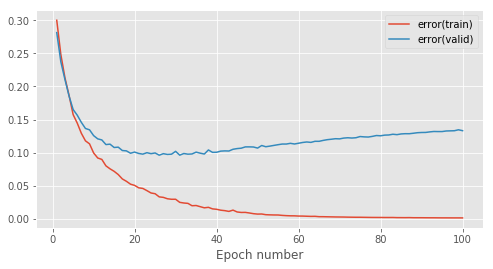

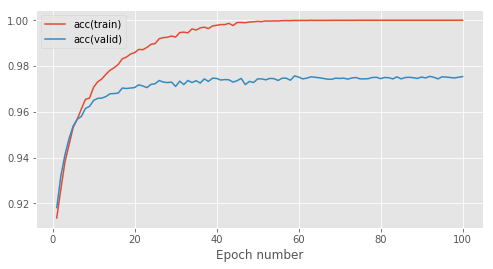

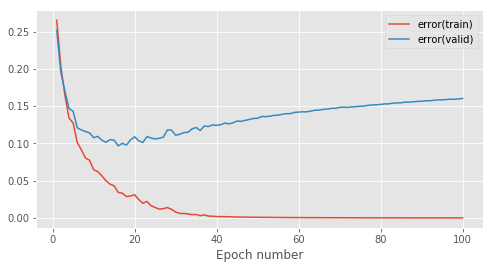

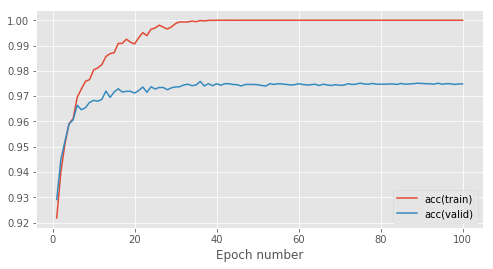

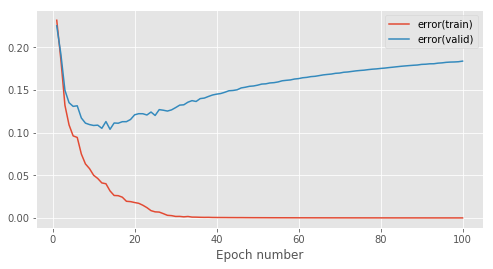

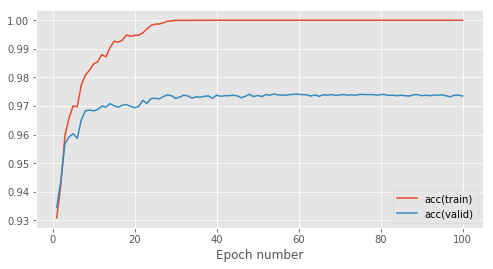

In [31]:
from mlp.initialisers import ConstantInit, GlorotUniformInit

experiment_init_glorotUniInit = {}

# Only experiment with 2,4,8 hidden layers
for i in [3,5,7]:

    # Always reset the dataset before experiment:
    train_data.reset()
    valid_data.reset()
    test_data.reset()

    # Initialise the weights and biases
    # Calculate the parameters for initialisation
    
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [AffineLayer(input_dim, hidden_dim, weights_init, biases_init)]
    output_layer = [func,
                    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)]
    each_hidden_layer = [func,
                    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)]


    # append additional layers
    model = MultipleLayerModel(input_layer + each_hidden_layer * i + output_layer)
    print(model)
    
    error = CrossEntropySoftmaxError()
    # Use Momentum with Stochastic Gradient Descent. We use the default learning_rate and mom_coeff.
    learning_rule = MomentumLearningRule() 

    experiment_init_glorotUniInit[i] = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, test_data, num_epochs, stats_interval, notebook=True)

    

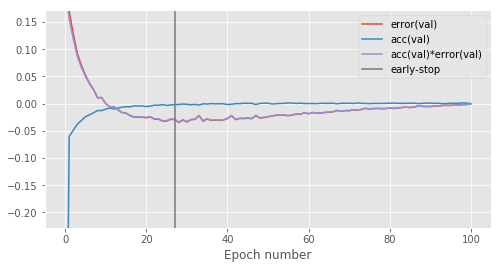

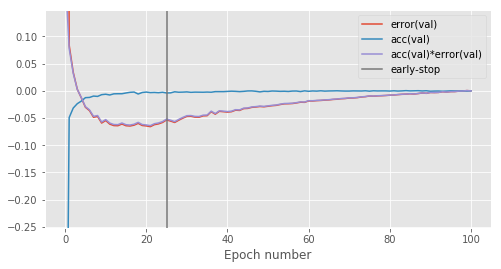

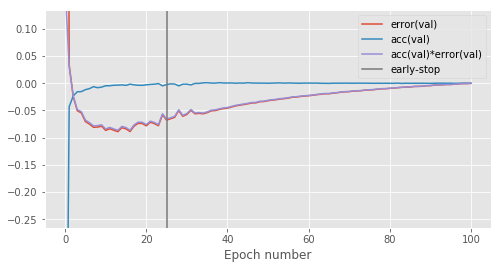

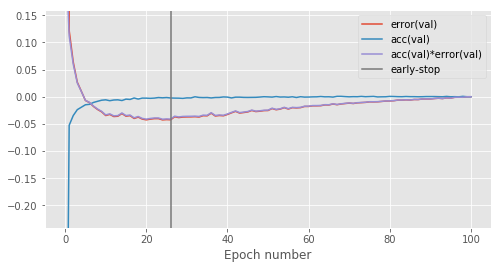

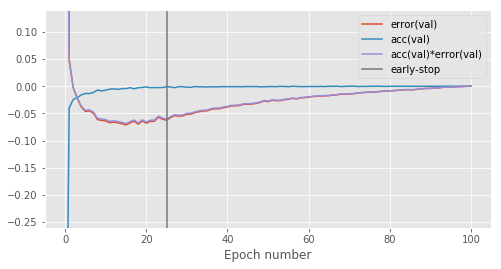

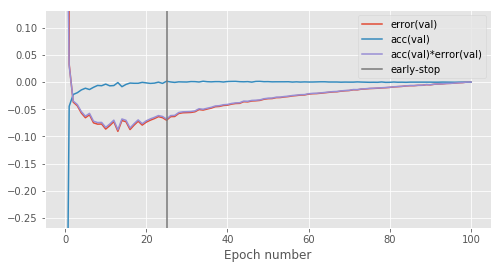

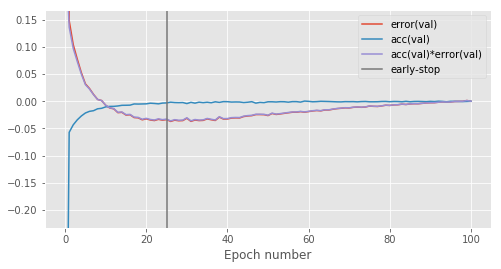

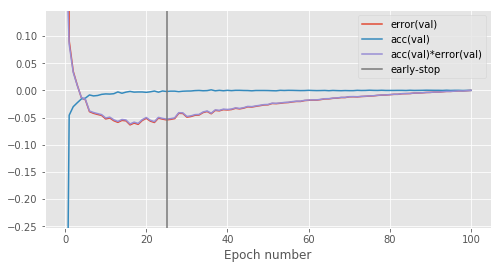

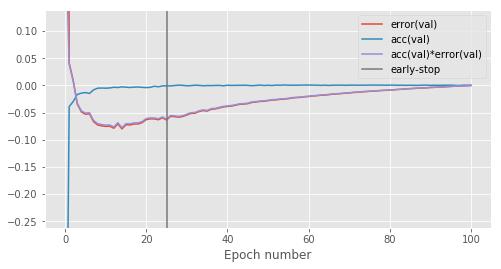

In [96]:
results = [experiment_init_indpFanIn, experiment_init_indpFanOut, experiment_init_glorotUniInit]
prefixes = ["fanin", "fanout", "glorot"]
pre_res = zip(prefixes, results)

final_valid_err= []
final_valid_acc = []
early_stopping_val_acc = []
early_stopping_val_err = []
test_err = []
test_acc = []
names = []

for prefix, result in pre_res:
    for (name, output) in result.items():
        keys = output[1]
        stats = output[0]
        best_epoch, best_valid_acc, best_test_acc, fig1, ax1 = find_best_epoch(stats, keys)

        # Store the statistics for this model
        final_valid_err.append(stats[-1, keys['error(valid)']])
        final_valid_acc.append(stats[-1, keys['acc(valid)']])
        early_stopping_val_err.append(stats[best_epoch, keys['error(valid)']])
        early_stopping_val_acc.append(stats[best_epoch, keys['acc(valid)']])
        test_err.append(stats[best_epoch, keys['error(test)']])
        test_acc.append(stats[best_epoch, keys['acc(test)']])
        name = "{0}-{1}".format(prefix, int(name)+1)
        names.append(name)

        # save the figures
        fig = output[3]
        fig.savefig("INIT-{}-err.pdf".format(name), format="pdf")
        fig = output[5]
        fig.savefig("INIT-{}-acc.pdf".format(name),format="pdf")
        fig1.savefig("INIT-{}-best-epoch.pdf".format(name), format="pdf")

In [100]:
print('|              |              FINAL            |                          EARLY STOPPING                     |')
print('| architecture | error(valid)   | acc(valid)   | error(valid)   |  acc(valid)   |  error(test) |  acc(test)  |')
print('|--------------|----------------|--------------|----------------|---------------|--------------|-------------|')
for i in range(len(names)):
    print('|{0:8}      | {1:.3e}      | {2:.3e}    | {3:.3e}      | {4:.3e}     | {5:.3e}    | {6:.3e}   |'
          .format(names[i], final_valid_err[i], final_valid_acc[i], 
                  early_stopping_val_err[i], early_stopping_val_acc[i],
                  test_err[i], test_acc[i]))
    

|              |              FINAL            |                          EARLY STOPPING                     |
| architecture | error(valid)   | acc(valid)   | error(valid)   |  acc(valid)   |  error(test) |  acc(test)  |
|--------------|----------------|--------------|----------------|---------------|--------------|-------------|
|fanin-4       | 1.212e-01      | 9.762e-01    | 9.212e-02      | 9.745e-01     | 9.331e-02    | 9.713e-01   |
|fanin-6       | 1.654e-01      | 9.747e-01    | 1.119e-01      | 9.708e-01     | 1.085e-01    | 9.697e-01   |
|fanin-8       | 1.921e-01      | 9.742e-01    | 1.243e-01      | 9.718e-01     | 1.169e-01    | 9.717e-01   |
|fanout-4      | 1.516e-01      | 9.719e-01    | 1.092e-01      | 9.696e-01     | 1.070e-01    | 9.696e-01   |
|fanout-6      | 1.898e-01      | 9.697e-01    | 1.274e-01      | 9.688e-01     | 1.224e-01    | 9.715e-01   |
|fanout-8      | 2.122e-01      | 9.688e-01    | 1.422e-01      | 9.704e-01     | 1.400e-01    | 9.692e-01   |
|

Text(0,0.5,'Validation Accuracy')

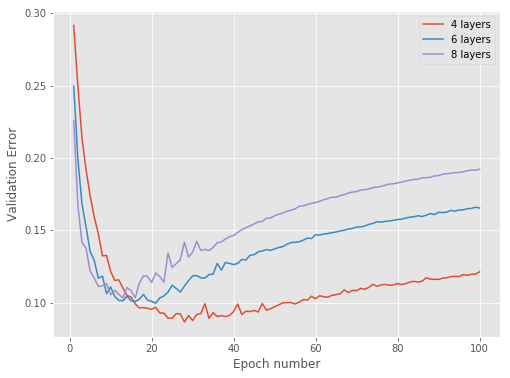

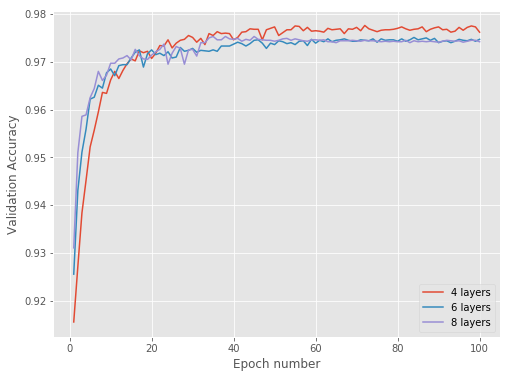

In [207]:
# Figures for FAN IN
# Combined plot for increasing hidden layer
fig = plt.figure(figsize=(8,6))
ax_1 = fig.add_subplot(111)
fig2=plt.figure(figsize=(8,6))
ax_2 = fig2.add_subplot(111)

for (name,output) in experiment_init_indpFanIn.items():
    keys = output[1]
    stats = output[0]
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
     stats[1:, keys['error(valid)']], label='{} layers'.format(int(name)+1))
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
       stats[1:, keys['acc(valid)']], label='{} layers'.format(int(name)+1))
    
ax_1.legend(loc=0); ax_2.legend(loc=0)
ax_1.set_xlabel('Epoch number');ax_2.set_xlabel('Epoch number');
ax_1.set_ylabel('Validation Error')
ax_2.set_ylabel('Validation Accuracy')

In [208]:
fig.savefig("val_error_fanin.pdf", format="pdf", bbox_inches="tight")
fig2.savefig("val_acc_fanin.pdf", format="pdf", bbox_inches="tight")

Text(0,0.5,'Validation Accuracy')

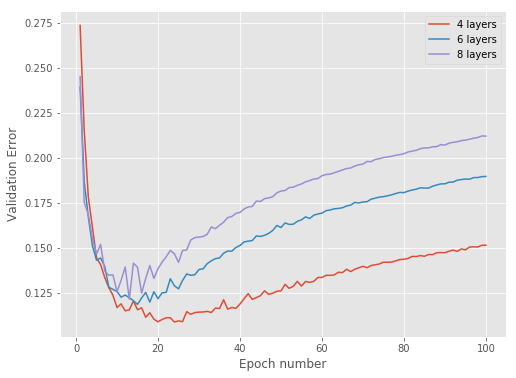

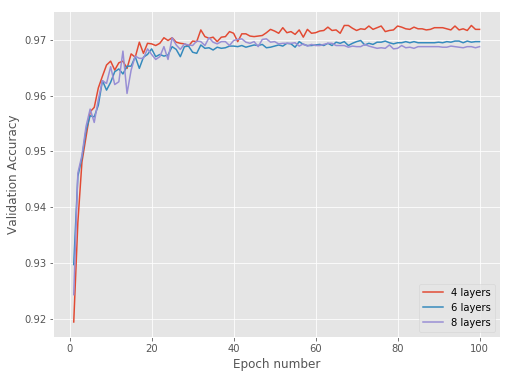

In [209]:
# Figures for FAN Out
# Combined plot for increasing hidden layer
fig = plt.figure(figsize=(8,6))
ax_1 = fig.add_subplot(111)
fig2=plt.figure(figsize=(8,6))
ax_2 = fig2.add_subplot(111)

for (name,output) in experiment_init_indpFanOut.items():
    keys = output[1]
    stats = output[0]
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
     stats[1:, keys['error(valid)']], label='{} layers'.format(int(name)+1))
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
       stats[1:, keys['acc(valid)']], label='{} layers'.format(int(name)+1))
    
ax_1.legend(loc=0); ax_2.legend(loc=0)
ax_1.set_xlabel('Epoch number');ax_2.set_xlabel('Epoch number');
ax_1.set_ylabel('Validation Error')
ax_2.set_ylabel('Validation Accuracy')

In [210]:
fig.savefig("val_error_fanout.pdf", format="pdf", bbox_inches="tight")
fig2.savefig("val_acc_fanout.pdf", format="pdf", bbox_inches="tight")

Text(0,0.5,'Validation Accuracy')

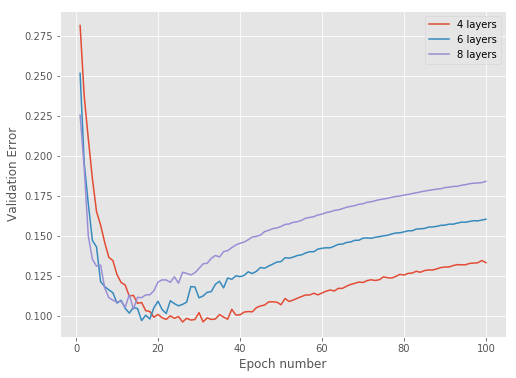

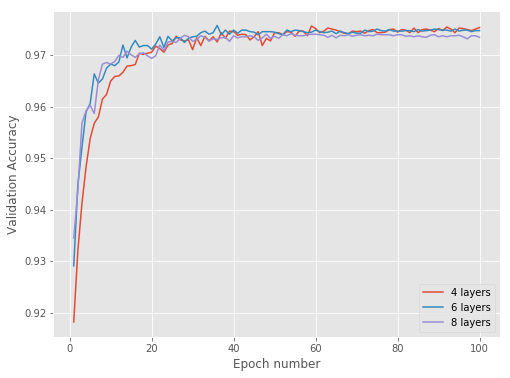

In [211]:
# Figures for Glorot init
# Combined plot for increasing hidden layer
fig = plt.figure(figsize=(8,6))
ax_1 = fig.add_subplot(111)
fig2=plt.figure(figsize=(8,6))
ax_2 = fig2.add_subplot(111)

for (name,output) in experiment_init_glorotUniInit.items():
    keys = output[1]
    stats = output[0]
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
     stats[1:, keys['error(valid)']], label='{} layers'.format(int(name)+1))
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
       stats[1:, keys['acc(valid)']], label='{} layers'.format(int(name)+1))
    
ax_1.legend(loc=0); ax_2.legend(loc=0)
ax_1.set_xlabel('Epoch number');ax_2.set_xlabel('Epoch number');
ax_1.set_ylabel('Validation Error')
ax_2.set_ylabel('Validation Accuracy')

In [212]:
fig.savefig("val_error_glorot.pdf", format="pdf", bbox_inches="tight")
fig2.savefig("val_acc_gorot.pdf", format="pdf", bbox_inches="tight")

---
### Experiments with self-normalising NN (SELU activation function)
In the original paper [1] and another blogpost [2], SELU is used with Feed-forward Neural networks architecture to create Sefl-normalising neural networks (SNN). It is shown interestingly that this internal normalisation outputs noramlised values from the activation function.

Now, in this section, we aim to investigate how varying the weights initialised in SELU affects the performance of SNNs at 1) FNN with 4 hidden layer, and 2) FNN with 6 hidden layer. Similar to previous investigations, Momentum SGD will be used.

~~~

[1] ***Self-noramlising Neural Networks***, Klambauer et al, 2017 (https://arxiv.org/pdf/1706.02515.pdf)

[2] https://medium.com/towards-data-science/selu-make-fnns-great-again-snn-8d61526802a9

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=10)
)


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 1.4s to complete
    error(train)=2.52e-01, acc(train)=9.27e-01, error(valid)=2.37e-01, acc(valid)=9.33e-01, error(test)=2.47e-01, acc(test)=9.28e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 1.4s to complete
    error(train)=1.82e-01, acc(train)=9.45e-01, error(valid)=1.84e-01, acc(valid)=9.47e-01, error(test)=1.90e-01, acc(test)=9.43e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 1.4s to complete
    error(train)=1.38e-01, acc(train)=9.58e-01, error(valid)=1.50e-01, acc(valid)=9.56e-01, error(test)=1.56e-01, acc(test)=9.53e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 1.4s to complete
    error(train)=1.09e-01, acc(train)=9.67e-01, error(valid)=1.26e-01, acc(valid)=9.64e-01, error(test)=1.34e-01, acc(test)=9.60e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 1.4s to complete
    error(train)=8.24e-02, acc(train)=9.76e-01, error(valid)=1.08e-01, acc(valid)=9.68e-01, error(test)=1.07e-01, acc(test)=9.67e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 1.4s to complete
    error(train)=7.38e-02, acc(train)=9.78e-01, error(valid)=1.08e-01, acc(valid)=9.69e-01, error(test)=1.07e-01, acc(test)=9.68e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 1.4s to complete
    error(train)=6.59e-02, acc(train)=9.80e-01, error(valid)=1.00e-01, acc(valid)=9.71e-01, error(test)=9.69e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 1.4s to complete
    error(train)=5.68e-02, acc(train)=9.83e-01, error(valid)=9.84e-02, acc(valid)=9.72e-01, error(test)=9.88e-02, acc(test)=9.69e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 1.4s to complete
    error(train)=4.75e-02, acc(train)=9.86e-01, error(valid)=9.28e-02, acc(valid)=9.73e-01, error(test)=9.36e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 1.4s to complete
    error(train)=3.93e-02, acc(train)=9.89e-01, error(valid)=9.22e-02, acc(valid)=9.74e-01, error(test)=8.73e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 1.4s to complete
    error(train)=3.78e-02, acc(train)=9.89e-01, error(valid)=8.97e-02, acc(valid)=9.74e-01, error(test)=8.50e-02, acc(test)=9.73e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 1.4s to complete
    error(train)=3.34e-02, acc(train)=9.90e-01, error(valid)=9.38e-02, acc(valid)=9.74e-01, error(test)=8.43e-02, acc(test)=9.74e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 1.4s to complete
    error(train)=3.36e-02, acc(train)=9.89e-01, error(valid)=9.28e-02, acc(valid)=9.74e-01, error(test)=8.71e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 1.4s to complete
    error(train)=2.68e-02, acc(train)=9.92e-01, error(valid)=9.22e-02, acc(valid)=9.75e-01, error(test)=8.71e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 1.4s to complete
    error(train)=3.03e-02, acc(train)=9.90e-01, error(valid)=1.04e-01, acc(valid)=9.73e-01, error(test)=9.84e-02, acc(test)=9.72e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 1.4s to complete
    error(train)=2.29e-02, acc(train)=9.93e-01, error(valid)=9.51e-02, acc(valid)=9.75e-01, error(test)=8.91e-02, acc(test)=9.77e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 1.4s to complete
    error(train)=1.68e-02, acc(train)=9.95e-01, error(valid)=9.13e-02, acc(valid)=9.77e-01, error(test)=8.86e-02, acc(test)=9.75e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 1.4s to complete
    error(train)=1.39e-02, acc(train)=9.96e-01, error(valid)=9.23e-02, acc(valid)=9.77e-01, error(test)=8.38e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 1.4s to complete
    error(train)=1.10e-02, acc(train)=9.97e-01, error(valid)=9.38e-02, acc(valid)=9.77e-01, error(test)=8.68e-02, acc(test)=9.77e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 1.4s to complete
    error(train)=1.01e-02, acc(train)=9.97e-01, error(valid)=9.74e-02, acc(valid)=9.76e-01, error(test)=8.83e-02, acc(test)=9.76e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 1.6s to complete
    error(train)=7.84e-03, acc(train)=9.99e-01, error(valid)=9.39e-02, acc(valid)=9.77e-01, error(test)=8.41e-02, acc(test)=9.77e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 1.6s to complete
    error(train)=7.36e-03, acc(train)=9.99e-01, error(valid)=9.84e-02, acc(valid)=9.76e-01, error(test)=8.68e-02, acc(test)=9.78e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 1.4s to complete
    error(train)=6.47e-03, acc(train)=9.99e-01, error(valid)=9.78e-02, acc(valid)=9.76e-01, error(test)=8.49e-02, acc(test)=9.78e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 1.4s to complete
    error(train)=4.09e-03, acc(train)=1.00e+00, error(valid)=9.74e-02, acc(valid)=9.76e-01, error(test)=8.64e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 1.4s to complete
    error(train)=3.69e-03, acc(train)=1.00e+00, error(valid)=9.66e-02, acc(valid)=9.78e-01, error(test)=8.55e-02, acc(test)=9.78e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 1.4s to complete
    error(train)=4.05e-03, acc(train)=1.00e+00, error(valid)=9.67e-02, acc(valid)=9.78e-01, error(test)=9.07e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 1.4s to complete
    error(train)=3.37e-03, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.77e-01, error(test)=8.80e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 1.5s to complete
    error(train)=5.47e-03, acc(train)=9.99e-01, error(valid)=1.09e-01, acc(valid)=9.76e-01, error(test)=9.30e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 1.4s to complete
    error(train)=2.15e-03, acc(train)=1.00e+00, error(valid)=1.00e-01, acc(valid)=9.78e-01, error(test)=8.82e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 1.4s to complete
    error(train)=2.17e-03, acc(train)=1.00e+00, error(valid)=1.02e-01, acc(valid)=9.77e-01, error(test)=9.06e-02, acc(test)=9.78e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 1.4s to complete
    error(train)=1.84e-03, acc(train)=1.00e+00, error(valid)=1.03e-01, acc(valid)=9.77e-01, error(test)=9.11e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 1.4s to complete
    error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=1.03e-01, acc(valid)=9.77e-01, error(test)=9.17e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 1.4s to complete
    error(train)=1.66e-03, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.77e-01, error(test)=9.33e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 1.4s to complete
    error(train)=1.31e-03, acc(train)=1.00e+00, error(valid)=1.05e-01, acc(valid)=9.77e-01, error(test)=9.22e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 1.4s to complete
    error(train)=1.19e-03, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.77e-01, error(test)=9.32e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 1.4s to complete
    error(train)=1.07e-03, acc(train)=1.00e+00, error(valid)=1.05e-01, acc(valid)=9.77e-01, error(test)=9.39e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 1.4s to complete
    error(train)=1.06e-03, acc(train)=1.00e+00, error(valid)=1.07e-01, acc(valid)=9.77e-01, error(test)=9.46e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 1.4s to complete
    error(train)=9.86e-04, acc(train)=1.00e+00, error(valid)=1.08e-01, acc(valid)=9.77e-01, error(test)=9.45e-02, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 1.4s to complete
    error(train)=9.88e-04, acc(train)=1.00e+00, error(valid)=1.07e-01, acc(valid)=9.77e-01, error(test)=9.49e-02, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 1.4s to complete
    error(train)=8.77e-04, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.76e-01, error(test)=9.65e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 1.4s to complete
    error(train)=8.30e-04, acc(train)=1.00e+00, error(valid)=1.09e-01, acc(valid)=9.77e-01, error(test)=9.65e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 1.4s to complete
    error(train)=8.38e-04, acc(train)=1.00e+00, error(valid)=1.10e-01, acc(valid)=9.77e-01, error(test)=9.78e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 1.4s to complete
    error(train)=7.75e-04, acc(train)=1.00e+00, error(valid)=1.11e-01, acc(valid)=9.76e-01, error(test)=9.71e-02, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 1.4s to complete
    error(train)=7.37e-04, acc(train)=1.00e+00, error(valid)=1.11e-01, acc(valid)=9.76e-01, error(test)=9.86e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 1.4s to complete
    error(train)=6.96e-04, acc(train)=1.00e+00, error(valid)=1.11e-01, acc(valid)=9.77e-01, error(test)=9.75e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 1.4s to complete
    error(train)=7.35e-04, acc(train)=1.00e+00, error(valid)=1.14e-01, acc(valid)=9.77e-01, error(test)=9.93e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 1.4s to complete
    error(train)=6.38e-04, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.77e-01, error(test)=9.95e-02, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 1.4s to complete
    error(train)=6.22e-04, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.77e-01, error(test)=9.94e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 1.4s to complete
    error(train)=5.98e-04, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.76e-01, error(test)=9.97e-02, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 1.4s to complete
    error(train)=5.72e-04, acc(train)=1.00e+00, error(valid)=1.13e-01, acc(valid)=9.77e-01, error(test)=9.98e-02, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 1.4s to complete
    error(train)=5.87e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.77e-01, error(test)=1.01e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 1.4s to complete
    error(train)=5.35e-04, acc(train)=1.00e+00, error(valid)=1.14e-01, acc(valid)=9.77e-01, error(test)=1.01e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 1.4s to complete
    error(train)=5.18e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.77e-01, error(test)=1.01e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 1.4s to complete
    error(train)=5.00e-04, acc(train)=1.00e+00, error(valid)=1.15e-01, acc(valid)=9.77e-01, error(test)=1.02e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 1.4s to complete
    error(train)=4.86e-04, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.77e-01, error(test)=1.02e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 1.4s to complete
    error(train)=4.73e-04, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.77e-01, error(test)=1.03e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 1.4s to complete
    error(train)=4.63e-04, acc(train)=1.00e+00, error(valid)=1.16e-01, acc(valid)=9.77e-01, error(test)=1.03e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 1.4s to complete
    error(train)=4.51e-04, acc(train)=1.00e+00, error(valid)=1.17e-01, acc(valid)=9.77e-01, error(test)=1.03e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 1.4s to complete
    error(train)=4.32e-04, acc(train)=1.00e+00, error(valid)=1.17e-01, acc(valid)=9.77e-01, error(test)=1.03e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 1.4s to complete
    error(train)=4.26e-04, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.77e-01, error(test)=1.04e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 1.4s to complete
    error(train)=4.13e-04, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.77e-01, error(test)=1.04e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 1.4s to complete
    error(train)=4.13e-04, acc(train)=1.00e+00, error(valid)=1.18e-01, acc(valid)=9.77e-01, error(test)=1.04e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 1.4s to complete
    error(train)=3.99e-04, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.77e-01, error(test)=1.05e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 1.4s to complete
    error(train)=3.92e-04, acc(train)=1.00e+00, error(valid)=1.19e-01, acc(valid)=9.77e-01, error(test)=1.05e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 1.4s to complete
    error(train)=3.75e-04, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.77e-01, error(test)=1.05e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 1.4s to complete
    error(train)=3.64e-04, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.77e-01, error(test)=1.06e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 1.4s to complete
    error(train)=3.56e-04, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.77e-01, error(test)=1.06e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 1.4s to complete
    error(train)=3.51e-04, acc(train)=1.00e+00, error(valid)=1.21e-01, acc(valid)=9.77e-01, error(test)=1.06e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 1.4s to complete
    error(train)=3.40e-04, acc(train)=1.00e+00, error(valid)=1.21e-01, acc(valid)=9.77e-01, error(test)=1.06e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 1.4s to complete
    error(train)=3.35e-04, acc(train)=1.00e+00, error(valid)=1.20e-01, acc(valid)=9.77e-01, error(test)=1.06e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 1.4s to complete
    error(train)=3.27e-04, acc(train)=1.00e+00, error(valid)=1.21e-01, acc(valid)=9.77e-01, error(test)=1.07e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 1.4s to complete
    error(train)=3.20e-04, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.77e-01, error(test)=1.07e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 1.4s to complete
    error(train)=3.15e-04, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.77e-01, error(test)=1.07e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 1.4s to complete
    error(train)=3.06e-04, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.77e-01, error(test)=1.08e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 1.4s to complete
    error(train)=3.05e-04, acc(train)=1.00e+00, error(valid)=1.22e-01, acc(valid)=9.77e-01, error(test)=1.08e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 1.4s to complete
    error(train)=2.95e-04, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.77e-01, error(test)=1.08e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 1.4s to complete
    error(train)=2.88e-04, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.77e-01, error(test)=1.08e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 1.4s to complete
    error(train)=2.83e-04, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.77e-01, error(test)=1.08e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 1.4s to complete
    error(train)=2.80e-04, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.77e-01, error(test)=1.09e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 1.7s to complete
    error(train)=2.74e-04, acc(train)=1.00e+00, error(valid)=1.23e-01, acc(valid)=9.77e-01, error(test)=1.09e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 1.5s to complete
    error(train)=2.68e-04, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.77e-01, error(test)=1.09e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 1.4s to complete
    error(train)=2.66e-04, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.77e-01, error(test)=1.09e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 1.4s to complete
    error(train)=2.59e-04, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.77e-01, error(test)=1.10e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 1.4s to complete
    error(train)=2.54e-04, acc(train)=1.00e+00, error(valid)=1.24e-01, acc(valid)=9.77e-01, error(test)=1.09e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 1.4s to complete
    error(train)=2.52e-04, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.77e-01, error(test)=1.10e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 1.4s to complete
    error(train)=2.45e-04, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.77e-01, error(test)=1.10e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 1.4s to complete
    error(train)=2.45e-04, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.77e-01, error(test)=1.10e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 1.4s to complete
    error(train)=2.39e-04, acc(train)=1.00e+00, error(valid)=1.25e-01, acc(valid)=9.77e-01, error(test)=1.11e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 1.4s to complete
    error(train)=2.36e-04, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.77e-01, error(test)=1.11e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 1.4s to complete
    error(train)=2.29e-04, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.77e-01, error(test)=1.11e-01, acc(test)=9.79e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 1.4s to complete
    error(train)=2.26e-04, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.77e-01, error(test)=1.11e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 1.4s to complete
    error(train)=2.23e-04, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.77e-01, error(test)=1.11e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 1.4s to complete
    error(train)=2.19e-04, acc(train)=1.00e+00, error(valid)=1.26e-01, acc(valid)=9.77e-01, error(test)=1.11e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 1.4s to complete
    error(train)=2.17e-04, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.77e-01, error(test)=1.11e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 1.4s to complete
    error(train)=2.13e-04, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.77e-01, error(test)=1.12e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 1.4s to complete
    error(train)=2.09e-04, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.77e-01, error(test)=1.12e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 1.4s to complete
    error(train)=2.07e-04, acc(train)=1.00e+00, error(valid)=1.27e-01, acc(valid)=9.77e-01, error(test)=1.12e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 1.4s to complete
    error(train)=2.04e-04, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.77e-01, error(test)=1.12e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 1.4s to complete
    error(train)=2.01e-04, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.77e-01, error(test)=1.13e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 1.4s to complete
    error(train)=1.98e-04, acc(train)=1.00e+00, error(valid)=1.28e-01, acc(valid)=9.77e-01, error(test)=1.13e-01, acc(test)=9.80e-01, params_penalty=0.00e+00


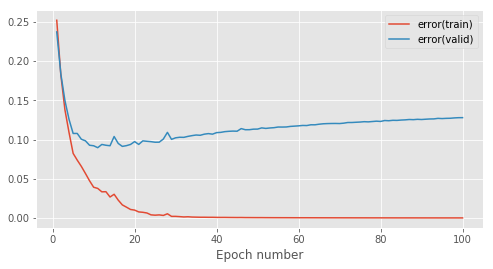

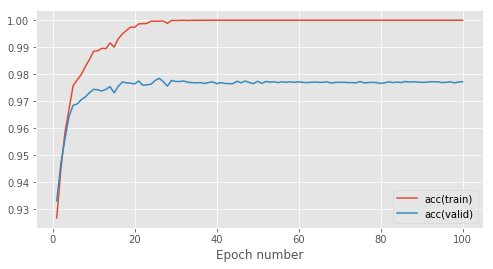

In [32]:
# First check if the previous results with SELU were similar if we were to use SELUInit 
from mlp.initialisers import SELUInit

# Check for the case of one single hidden layers as is the case of 2a:
# Always reset the dataset before experiment:
train_data.reset()
valid_data.reset()
test_data.reset()

# Initialise the weights and biases
weights_init = SELUInit(rng=rng)
biases_init = ConstantInit(0.)
m = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SELULayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SELULayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])
error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

seluinit_2_layer = train_model_and_plot_stats(
    m, error, learning_rule, train_data, valid_data, test_data, num_epochs, stats_interval, notebook=True)



In [33]:
%%capture _seluinit
experiment_init_seluinit = {}

for i in [1,3,5,7]:

    # Always reset the dataset before experiment:
    train_data.reset()
    valid_data.reset()
    test_data.reset()

    # Initialise the weights and biases
    # Calculate the parameters for initialisation
    
    weights_init = SELUInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [AffineLayer(input_dim, hidden_dim, weights_init, biases_init)]
    output_layer = [func,
                    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)]
    each_hidden_layer = [func,
                    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)]


    # append additional layers
    model = MultipleLayerModel(input_layer + each_hidden_layer * i + output_layer)
    print(model)
    
    error = CrossEntropySoftmaxError()
    # Use Momentum with Stochastic Gradient Descent. We use the default learning_rate and mom_coeff.
    learning_rule = MomentumLearningRule() 

    experiment_init_seluinit[i] = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, test_data, num_epochs, stats_interval, notebook=True)

    

Epoch 1: 1.7s to complete
    error(train)=3.97e-01, acc(train)=8.90e-01, error(valid)=3.63e-01, acc(valid)=9.04e-01, error(test)=3.75e-01, acc(test)=8.98e-01, params_penalty=0.00e+00
Epoch 2: 1.6s to complete
    error(train)=3.31e-01, acc(train)=9.06e-01, error(valid)=3.07e-01, acc(valid)=9.12e-01, error(test)=3.15e-01, acc(test)=9.12e-01, params_penalty=0.00e+00
Epoch 3: 1.7s to complete
    error(train)=3.00e-01, acc(train)=9.14e-01, error(valid)=2.80e-01, acc(valid)=9.21e-01, error(test)=2.90e-01, acc(test)=9.18e-01, params_penalty=0.00e+00
Epoch 4: 1.6s to complete
    error(train)=2.84e-01, acc(train)=9.20e-01, error(valid)=2.65e-01, acc(valid)=9.25e-01, error(test)=2.79e-01, acc(test)=9.22e-01, params_penalty=0.00e+00
Epoch 5: 1.7s to complete
    error(train)=2.70e-01, acc(train)=9.23e-01, error(valid)=2.58e-01, acc(valid)=9.26e-01, error(test)=2.65e-01, acc(test)=9.24e-01, params_penalty=0.00e+00
Epoch 6: 1.6s to complete
    error(train)=2.58e-01, acc(train)=9.26e-01, error(

Epoch 46: 1.6s to complete
    error(train)=6.04e-02, acc(train)=9.84e-01, error(valid)=1.03e-01, acc(valid)=9.70e-01, error(test)=1.01e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 47: 1.7s to complete
    error(train)=5.80e-02, acc(train)=9.84e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01, error(test)=1.00e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 48: 1.6s to complete
    error(train)=5.56e-02, acc(train)=9.85e-01, error(valid)=9.95e-02, acc(valid)=9.71e-01, error(test)=9.84e-02, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 49: 1.7s to complete
    error(train)=5.36e-02, acc(train)=9.86e-01, error(valid)=9.86e-02, acc(valid)=9.71e-01, error(test)=9.54e-02, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 50: 1.6s to complete
    error(train)=5.35e-02, acc(train)=9.85e-01, error(valid)=9.88e-02, acc(valid)=9.72e-01, error(test)=9.56e-02, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 51: 1.7s to complete
    error(train)=5.22e-02, acc(train)=9.86e-01, 

Epoch 91: 1.6s to complete
    error(train)=1.86e-02, acc(train)=9.97e-01, error(valid)=9.33e-02, acc(valid)=9.73e-01, error(test)=8.92e-02, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 92: 1.6s to complete
    error(train)=1.89e-02, acc(train)=9.96e-01, error(valid)=9.42e-02, acc(valid)=9.72e-01, error(test)=8.86e-02, acc(test)=9.76e-01, params_penalty=0.00e+00
Epoch 93: 1.6s to complete
    error(train)=1.78e-02, acc(train)=9.97e-01, error(valid)=9.37e-02, acc(valid)=9.74e-01, error(test)=8.93e-02, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 94: 1.6s to complete
    error(train)=1.80e-02, acc(train)=9.97e-01, error(valid)=9.42e-02, acc(valid)=9.74e-01, error(test)=8.99e-02, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 95: 1.6s to complete
    error(train)=1.70e-02, acc(train)=9.97e-01, error(valid)=9.26e-02, acc(valid)=9.74e-01, error(test)=8.75e-02, acc(test)=9.76e-01, params_penalty=0.00e+00
Epoch 96: 1.7s to complete
    error(train)=1.67e-02, acc(train)=9.97e-01, 

Epoch 36: 2.2s to complete
    error(train)=2.97e-02, acc(train)=9.92e-01, error(valid)=1.02e-01, acc(valid)=9.72e-01, error(test)=9.20e-02, acc(test)=9.71e-01, params_penalty=0.00e+00
Epoch 37: 2.2s to complete
    error(train)=2.58e-02, acc(train)=9.94e-01, error(valid)=9.91e-02, acc(valid)=9.74e-01, error(test)=9.12e-02, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 38: 2.2s to complete
    error(train)=2.50e-02, acc(train)=9.94e-01, error(valid)=1.01e-01, acc(valid)=9.75e-01, error(test)=9.35e-02, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 39: 2.3s to complete
    error(train)=2.28e-02, acc(train)=9.94e-01, error(valid)=1.05e-01, acc(valid)=9.73e-01, error(test)=9.30e-02, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 40: 2.2s to complete
    error(train)=2.41e-02, acc(train)=9.94e-01, error(valid)=1.07e-01, acc(valid)=9.73e-01, error(test)=9.70e-02, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 41: 2.2s to complete
    error(train)=2.08e-02, acc(train)=9.95e-01, 

Epoch 81: 2.2s to complete
    error(train)=1.67e-03, acc(train)=1.00e+00, error(valid)=1.29e-01, acc(valid)=9.75e-01, error(test)=1.14e-01, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 82: 2.2s to complete
    error(train)=1.59e-03, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.75e-01, error(test)=1.15e-01, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 83: 2.2s to complete
    error(train)=1.54e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.75e-01, error(test)=1.16e-01, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 84: 2.3s to complete
    error(train)=1.47e-03, acc(train)=1.00e+00, error(valid)=1.31e-01, acc(valid)=9.75e-01, error(test)=1.16e-01, acc(test)=9.75e-01, params_penalty=0.00e+00
Epoch 85: 2.2s to complete
    error(train)=1.39e-03, acc(train)=1.00e+00, error(valid)=1.32e-01, acc(valid)=9.75e-01, error(test)=1.16e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 86: 2.2s to complete
    error(train)=1.37e-03, acc(train)=1.00e+00, 

Epoch 26: 2.8s to complete
    error(train)=2.81e-02, acc(train)=9.92e-01, error(valid)=1.14e-01, acc(valid)=9.69e-01, error(test)=1.10e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 27: 2.8s to complete
    error(train)=2.71e-02, acc(train)=9.92e-01, error(valid)=1.14e-01, acc(valid)=9.69e-01, error(test)=1.08e-01, acc(test)=9.70e-01, params_penalty=0.00e+00
Epoch 28: 2.8s to complete
    error(train)=2.83e-02, acc(train)=9.92e-01, error(valid)=1.18e-01, acc(valid)=9.68e-01, error(test)=1.12e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 29: 2.8s to complete
    error(train)=2.30e-02, acc(train)=9.94e-01, error(valid)=1.14e-01, acc(valid)=9.68e-01, error(test)=1.12e-01, acc(test)=9.68e-01, params_penalty=0.00e+00
Epoch 30: 3.0s to complete
    error(train)=2.99e-02, acc(train)=9.90e-01, error(valid)=1.29e-01, acc(valid)=9.66e-01, error(test)=1.23e-01, acc(test)=9.67e-01, params_penalty=0.00e+00
Epoch 31: 2.9s to complete
    error(train)=1.79e-02, acc(train)=9.96e-01, 

Epoch 71: 2.8s to complete
    error(train)=5.21e-04, acc(train)=1.00e+00, error(valid)=1.68e-01, acc(valid)=9.72e-01, error(test)=1.57e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 72: 2.8s to complete
    error(train)=4.85e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.72e-01, error(test)=1.59e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 73: 2.8s to complete
    error(train)=4.79e-04, acc(train)=1.00e+00, error(valid)=1.69e-01, acc(valid)=9.73e-01, error(test)=1.60e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 74: 2.8s to complete
    error(train)=4.50e-04, acc(train)=1.00e+00, error(valid)=1.70e-01, acc(valid)=9.72e-01, error(test)=1.61e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 75: 2.8s to complete
    error(train)=4.38e-04, acc(train)=1.00e+00, error(valid)=1.72e-01, acc(valid)=9.72e-01, error(test)=1.62e-01, acc(test)=9.72e-01, params_penalty=0.00e+00
Epoch 76: 2.8s to complete
    error(train)=4.23e-04, acc(train)=1.00e+00, 

Epoch 16: 3.4s to complete
    error(train)=5.96e-02, acc(train)=9.82e-01, error(valid)=1.17e-01, acc(valid)=9.68e-01, error(test)=1.21e-01, acc(test)=9.65e-01, params_penalty=0.00e+00
Epoch 17: 3.4s to complete
    error(train)=5.76e-02, acc(train)=9.82e-01, error(valid)=1.19e-01, acc(valid)=9.67e-01, error(test)=1.21e-01, acc(test)=9.63e-01, params_penalty=0.00e+00
Epoch 18: 3.4s to complete
    error(train)=5.23e-02, acc(train)=9.83e-01, error(valid)=1.21e-01, acc(valid)=9.68e-01, error(test)=1.14e-01, acc(test)=9.65e-01, params_penalty=0.00e+00
Epoch 19: 3.8s to complete
    error(train)=4.57e-02, acc(train)=9.86e-01, error(valid)=1.11e-01, acc(valid)=9.71e-01, error(test)=1.20e-01, acc(test)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 3.4s to complete
    error(train)=4.02e-02, acc(train)=9.88e-01, error(valid)=1.09e-01, acc(valid)=9.70e-01, error(test)=1.14e-01, acc(test)=9.69e-01, params_penalty=0.00e+00
Epoch 21: 3.4s to complete
    error(train)=5.03e-02, acc(train)=9.84e-01, 

Epoch 61: 3.4s to complete
    error(train)=3.62e-04, acc(train)=1.00e+00, error(valid)=1.60e-01, acc(valid)=9.76e-01, error(test)=1.66e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 62: 3.4s to complete
    error(train)=3.46e-04, acc(train)=1.00e+00, error(valid)=1.62e-01, acc(valid)=9.76e-01, error(test)=1.68e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 63: 3.4s to complete
    error(train)=3.24e-04, acc(train)=1.00e+00, error(valid)=1.63e-01, acc(valid)=9.76e-01, error(test)=1.68e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 64: 3.4s to complete
    error(train)=3.04e-04, acc(train)=1.00e+00, error(valid)=1.65e-01, acc(valid)=9.76e-01, error(test)=1.70e-01, acc(test)=9.73e-01, params_penalty=0.00e+00
Epoch 65: 3.4s to complete
    error(train)=2.89e-04, acc(train)=1.00e+00, error(valid)=1.66e-01, acc(valid)=9.75e-01, error(test)=1.71e-01, acc(test)=9.74e-01, params_penalty=0.00e+00
Epoch 66: 3.4s to complete
    error(train)=2.79e-04, acc(train)=1.00e+00, 

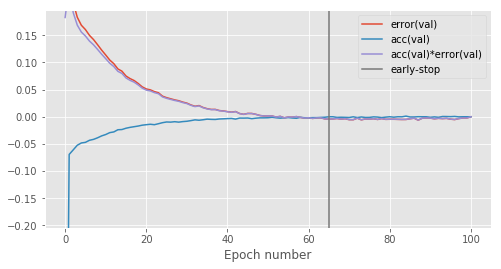

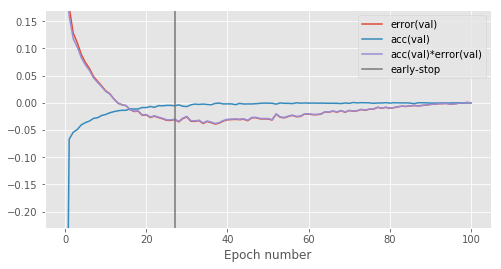

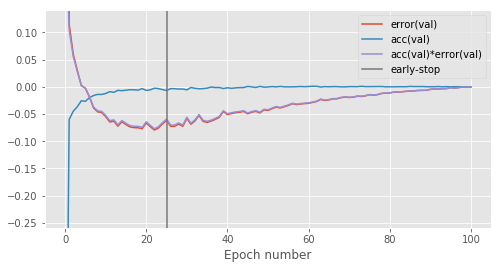

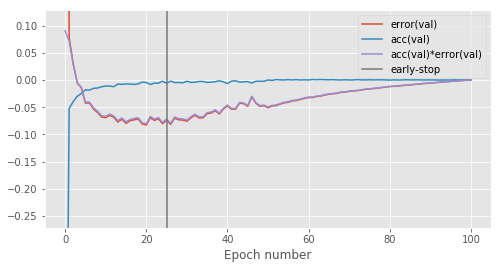

In [213]:
final_valid_err= []
final_valid_acc = []
early_stopping_val_acc = []
early_stopping_val_err = []
test_err = []
test_acc = []
names = []
prefix="selu"
for (name, output) in experiment_init_seluinit.items():
    keys = output[1]
    stats = output[0]
    best_epoch, best_valid_acc, best_test_acc, fig1, ax1 = find_best_epoch(stats, keys)

    # Store the statistics for this model
    final_valid_err.append(stats[-1, keys['error(valid)']])
    final_valid_acc.append(stats[-1, keys['acc(valid)']])
    early_stopping_val_err.append(stats[best_epoch, keys['error(valid)']])
    early_stopping_val_acc.append(stats[best_epoch, keys['acc(valid)']])
    test_err.append(stats[best_epoch, keys['error(test)']])
    test_acc.append(stats[best_epoch, keys['acc(test)']])
    name = "{0}-{1}".format(prefix, int(name)+1)
    names.append(name)

    # save the figures
    fig = output[3]
    fig.savefig("INIT-{}-err.pdf".format(name), format="pdf")
    fig = output[5]
    fig.savefig("INIT-{}-acc.pdf".format(name),format="pdf")
    fig1.savefig("INIT-{}-best-epoch.pdf".format(name), format="pdf")

In [206]:
print('|              |              FINAL            |                          EARLY STOPPING                     |')
print('| architecture | error(valid)   | acc(valid)   | error(valid)   |  acc(valid)   |  error(test) |  acc(test)  |')
print('|--------------|----------------|--------------|----------------|---------------|--------------|-------------|')
for i in range(len(names)):
    print('|{0:8}      | {1:.3e}      | {2:.3e}    | {3:.3e}      | {4:.3e}     | {5:.3e}    | {6:.3e}   |'
          .format(names[i], final_valid_err[i], final_valid_acc[i], 
                  early_stopping_val_err[i], early_stopping_val_acc[i],
                  test_err[i], test_acc[i]))

|              |              FINAL            |                          EARLY STOPPING                     |
| architecture | error(valid)   | acc(valid)   | error(valid)   |  acc(valid)   |  error(test) |  acc(test)  |
|--------------|----------------|--------------|----------------|---------------|--------------|-------------|
|selu-2        | 9.712e-02      | 9.734e-01    | 9.273e-02      | 9.734e-01     | 9.049e-02    | 9.737e-01   |
|selu-4        | 1.381e-01      | 9.752e-01    | 1.073e-01      | 9.698e-01     | 9.867e-02    | 9.698e-01   |
|selu-6        | 1.869e-01      | 9.721e-01    | 1.255e-01      | 9.654e-01     | 1.256e-01    | 9.644e-01   |
|selu-8        | 1.923e-01      | 9.751e-01    | 1.181e-01      | 9.690e-01     | 1.217e-01    | 9.684e-01   |


Text(0,0.5,'Validation Accuracy')

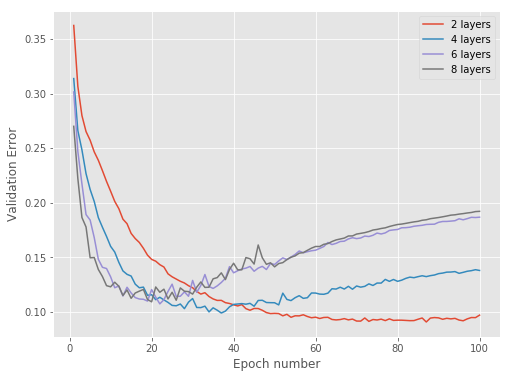

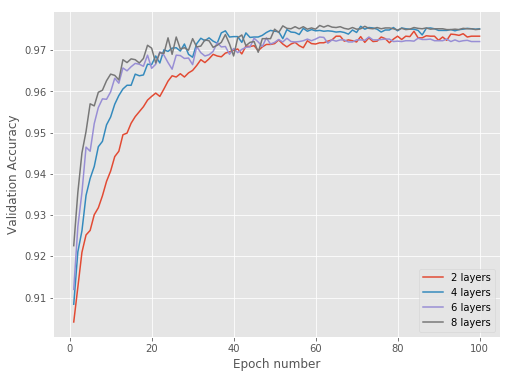

In [214]:
# Figures for SELUINIT
# Combined plot for increasing hidden layer
fig = plt.figure(figsize=(8,6))
ax_1 = fig.add_subplot(111)
fig2=plt.figure(figsize=(8,6))
ax_2 = fig2.add_subplot(111)

for (name,output) in experiment_init_seluinit.items():
    keys = output[1]
    stats = output[0]
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
     stats[1:, keys['error(valid)']], label='{} layers'.format(int(name)+1))
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
       stats[1:, keys['acc(valid)']], label='{} layers'.format(int(name)+1))
    
ax_1.legend(loc=0); ax_2.legend(loc=0)
ax_1.set_xlabel('Epoch number');ax_2.set_xlabel('Epoch number');
ax_1.set_ylabel('Validation Error')
ax_2.set_ylabel('Validation Accuracy')

In [215]:
fig.savefig("val_error_selu.pdf", format="pdf", bbox_inches="tight")
fig2.savefig("val_acc_selu.pdf", format="pdf", bbox_inches="tight")